# Description

* This notebook implement(s) the pipeline for the Advanced Lane Detection Project.

# Writeup

* The project writeup is located at : https://github.com/jailad/Self-Driving-Cars-Term1-Project4/blob/master/writeup.md


# Imports

In [249]:
# Imports

import numpy as np
import cv2
import glob # Used to read in image files of a particular pattern
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import pickle
import collections # Used to store a recent window of good fits
import math # Used for nan detection

# Packages below needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Constants

In [250]:
# Shared Constants

const_separator_line = "--------------------------------"

const_measurements_fontsize = 1
const_measurements_fontcolor = (255,255,255)

const_kernelsize = 9 # Larger Kernel size -> 'Smoother' detection

# Constants for perspective transform
const_src = np.float32([[120, 720], [550, 470], [700, 470], [1160, 720]])
const_dest = np.float32([[200,720], [200,0], [1080,0], [1080,720]])

# Constants representing paths of a few test images
const_test_straight1 = './project/test_images/straight_lines1.jpg'
const_test_straight2 = './project/test_images/straight_lines2.jpg'

const_test_image_1 = './project/test_images/test1.jpg'
const_test_image_2 = './project/test_images/test2.jpg'
const_test_image_3 = './project/test_images/test3.jpg'
const_test_image_4 = './project/test_images/test4.jpg'
const_test_image_5 = './project/test_images/test5.jpg'
const_test_image_6 = './project/test_images/test6.jpg'

const_challenge_image_paths = glob.glob('./project/challenge_images/chal*.jpg')



# Useful Utility method(s)

In [3]:

# Useful functions to selectively turn on / off logging at different levels

const_info_log_enabled = False
def infoLog(logMessage, param_separator=None):
    if const_info_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)

const_debug_log_enabled = True
def debugLog(logMessage, param_separator=None):
    if const_debug_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)
        
const_warning_log_enabled = True
def warningLog(logMessage, param_separator=None):
    if const_warning_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)
        
const_error_log_enabled = True
def errorLog(logMessage, param_separator=None):
    if const_error_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)


# Preparing for Camera Calibration and Distortion Correction

* Determine Object points and image points for a single image

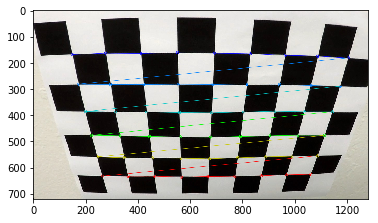

In [287]:
# Detect and DrawChessboard Corners

nx = 9
ny = 6 

image_path = './project/camera_cal/calibration2.jpg'
image = mpimg.imread(image_path)

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(image_gray, (nx, ny), None)

infoLog(ret)
infoLog(corners)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.imshow(image)

* Determine Object points and image points for all images within the Calibration Folder

In [288]:
# Detect Chess corners for all the images within the camera_cal folder
# This process gives us Object points and Image points, which can then be used for Camera Calibration

imagePaths = glob.glob('./project/camera_cal/calibration*.jpg')
outputPath = './project/camera_cal/output/'
infoLog(imagePaths)

nx = 9 
ny = 6 

num_channels = 3

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,num_channels), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # -1 implies shape is to be inferred
infoLog(objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for index, imagePath in enumerate(imagePaths):
    img = mpimg.imread(imagePath) # Reads image as an RGB image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        infoLog("Chessboard Corners found for - " + imagePath )
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = outputPath + 'corners_found'+str(index)+'.jpg'
        cv2.imwrite(write_name, img)

    else:
        debugLog("Chessboard Corners not found for - " + imagePath )
        

infoLog("Object Points")
infoLog(objpoints)

infoLog("Image Points")
infoLog(imgpoints)



Chessboard Corners not found for - ./project/camera_cal/calibration1.jpg

Chessboard Corners not found for - ./project/camera_cal/calibration4.jpg

Chessboard Corners not found for - ./project/camera_cal/calibration5.jpg

Chessboard Corners not found for - ./project/camera_cal/calibration_test.jpg


# Camera calibration and Example of Distortion Correction image


Image Shape : (720, 1280, 3)

Image Size ( Note that this is Height first then Width ) : (1280, 720)

Successfully written to ./project/camera_cal/output/calibration_test_undistorted.jpg ? :-> True


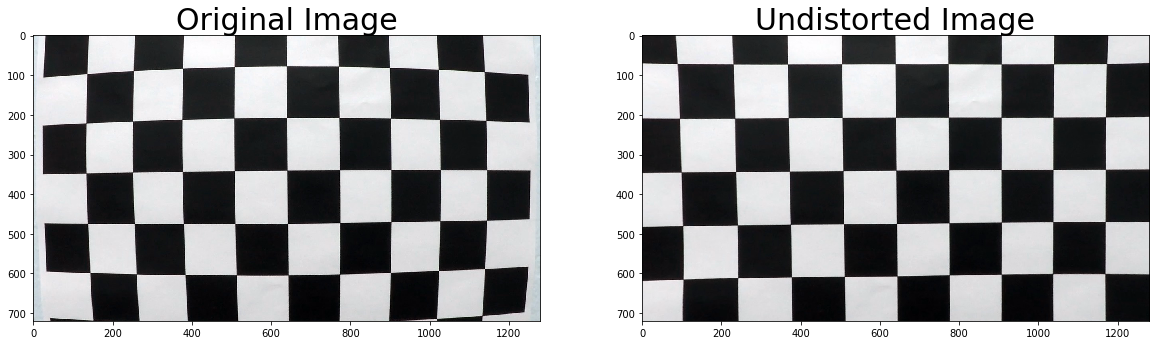

In [289]:

# Test undistortion on an image

test_image_path = './project/camera_cal/calibration_test.jpg'
undistorted_test_image_output_path = './project/camera_cal/output/calibration_test_undistorted.jpg'
wide_dist_pickle_path = './project/camera_cal/output/wide_dist_pickle.p'

img = cv2.imread(test_image_path)
debugLog("Image Shape : " + str(img.shape))
img_size = (img.shape[1], img.shape[0])
debugLog("Image Size ( Note that this is Height first then Width ) : " + str(img_size))

# Camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save Calibration results to a Pickle file
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open(wide_dist_pickle_path, "wb" ) )

# Perform Undistortion 
dst = cv2.undistort(img, mtx, dist, None, mtx)
result = cv2.imwrite(undistorted_test_image_output_path, dst)
debugLog("Successfully written to " + undistorted_test_image_output_path + " ? :-> "+ str(result) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


# Ensuring that the Distortion Correction parameters can be restored from Disk

In [290]:

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open(wide_dist_pickle_path, "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

if mtx is not None:
    debugLog("Distortion correction matrix restored successfully from Disk.")

# Convenience function to undistort an image, given the object points and image points
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Convenience function to undistort an image, given the undistortion matrix
def cal_undistort_mtx(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



Distortion correction matrix restored successfully from Disk.


# Example of Thresholded binary image

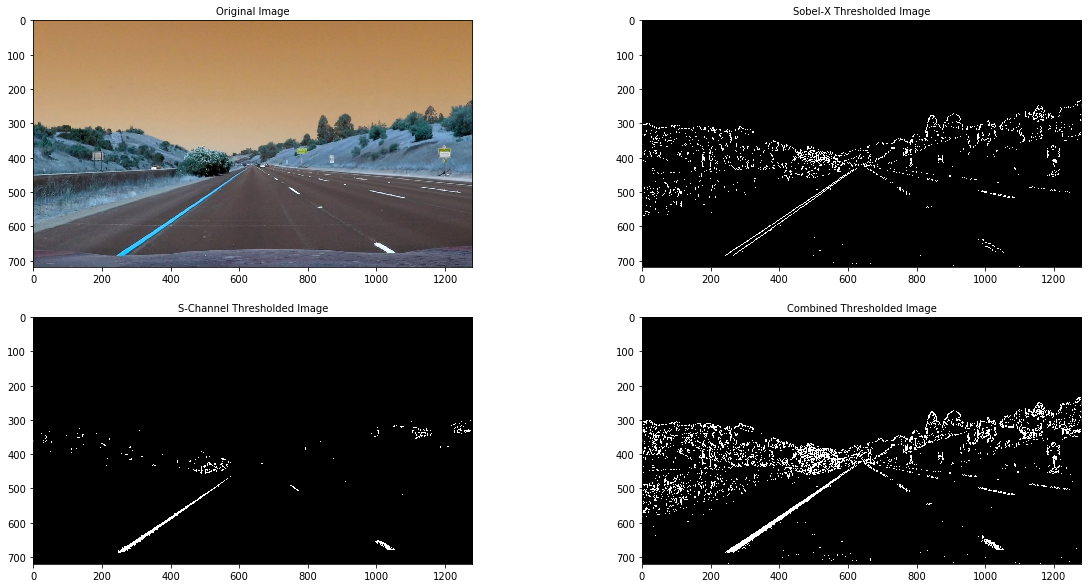

In [291]:
# Convenience function to return a Sobel thresholded Binary Image from a given image
def abs_sobel_thresh(rgb_img, orient='x', sobel_kernel = 3, grad_thresh=(0,255)):
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY) # This assumes input image is in RGB format ( i.e. as returned by MPImg)
    sobel = None
    if orient == 'x':
        sobel =  cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    else:
        sobel =  cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobelx = np.absolute(sobel)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_output = np.zeros_like(scaled_sobelx)
    binary_output[(scaled_sobelx >= grad_thresh[0]) & (scaled_sobelx <= grad_thresh[1])] = 1

    return binary_output

# Convenience function to apply S Channel Thresholding on an image
def apply_s_channel_thresholding(rgb_img, thresh=(0,255)):
    # Convert to HLS
#     img_hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS).astype(np.float)
    img_hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    # Apply threshold to S channel
    S = img_hls[:,:,2]
    binary_s = np.zeros_like(S)
    binary_s[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary_s

# Convenience function to combine the above thresholding techniques into a single method
def thresholding(img, binary_threshold=(20, 100), s_channel_threshold=(170,255), sobel_kernel_size=const_kernelsize):
    binary_thresholded_img_x = abs_sobel_thresh(img, 'x', sobel_kernel_size, binary_threshold)
    s_channel_thresholded_image = apply_s_channel_thresholding(img, s_channel_threshold)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary_thresholded_img_x)
    combined_binary[(binary_thresholded_img_x == 1) | (s_channel_thresholded_image == 1)] = 1
    return combined_binary

# Define Thresholding parameters 
local_sobel_kernel = 1
local_sobel_threshold = (30,100)
local_s_channel_threshold = (170,255)

# Perform Thresholding
img = mpimg.imread(const_test_straight1) # Reads image as an RGB image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Force to RGB format
infoLog(img.shape)
sobel_x_thresholded_image = abs_sobel_thresh(img, 'x', local_sobel_kernel, local_sobel_threshold)
s_channel_thresholded_image = apply_s_channel_thresholding(img, local_s_channel_threshold)
combined_image = thresholding(img)

# Visualize Thresholding
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(sobel_x_thresholded_image, cmap='gray')
ax2.set_title('Sobel-X Thresholded Image', fontsize=10)
ax3.imshow(s_channel_thresholded_image, cmap='gray')
ax3.set_title('S-Channel Thresholded Image', fontsize=10)
ax4.imshow(combined_image, cmap='gray')
ax4.set_title('Combined Thresholded Image', fontsize=10)



# Region of Interest Selection

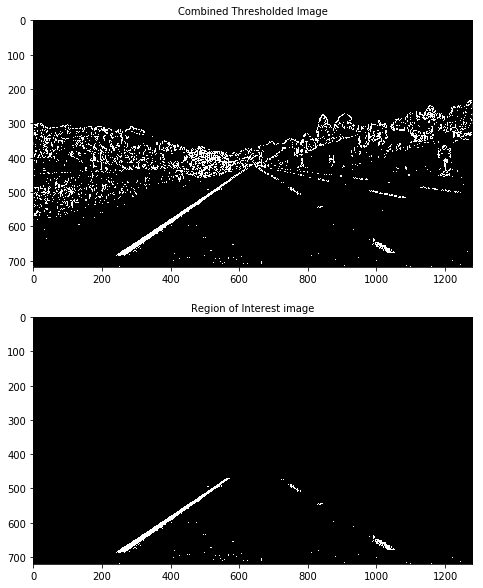

In [303]:

# Convenience function for region of interest selection
# This code is the same as my submission from Project 1 for the lane detection project.

def region_of_interest(img, vertices):

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    region_of_interest_image = cv2.bitwise_and(img, mask)
    return region_of_interest_image


image_shape = combined_image.shape
vertices = np.array([[(0,image_shape[0]),(550, 470), (750, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)

# Perform RoI Selection
region_of_interest_image = region_of_interest(combined_image, vertices)

# Visualize RoI Selection
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
ax1.imshow(combined_image, cmap='gray')
ax1.set_title('Combined Thresholded Image', fontsize=10)
ax2.imshow(region_of_interest_image, cmap='gray')
ax2.set_title('Region of Interest image', fontsize=10)


# Example of Perspective Transform

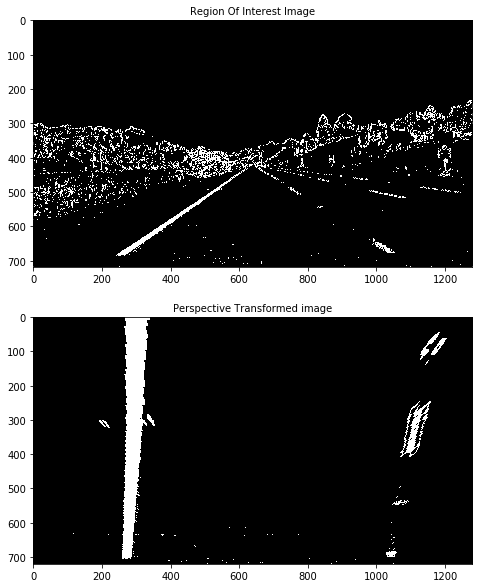

In [293]:

# Convenience function to apply a perspective transform to an image, given certain Source and Destination parameters
def warp_src_dest(img, src, dest):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

warped_image, M, Minv = warp_src_dest(region_of_interest_image, const_src, const_dest)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
ax1.imshow(combined_image, cmap='gray')
ax1.set_title('Region Of Interest Image', fontsize=10)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Perspective Transformed image', fontsize=10)



# Using Histogram technique for :
* Left lane detection.
* Right lane detection.
* Generating a Binomial fit for left lane.
* Generating a Binomial fit for right lane.

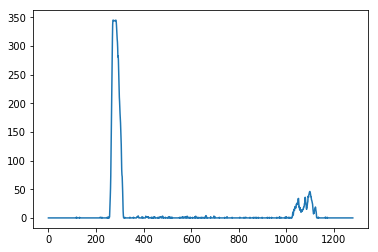

In [294]:

# Generating the Histogram

def generate_histogram(warped_image):
    histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

generate_histogram(warped_image)
plt.savefig('./project/output_images/histogram.png', bbox_inches='tight')


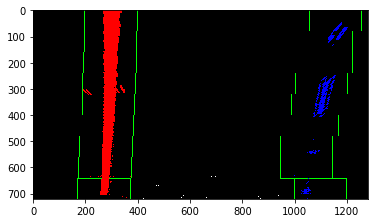

In [304]:

# Use Histogram for the botom half of the image to separate lane line(s) into left lane and right lane pixels 
# using Windowing technique.
# Once left and right lane pixels have been separated, fit a second order polynomial to the detected left and right lane(s)
# Once we have a 'fit' we generate synthetic lane line(s) using the fit and plot those on the image in yellow color.

def detect_lanes_and_fit_poly(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    infoLog(leftx.shape)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
#     plt.savefig('./project/output_images/detect_lane_lines.png', bbox_inches='tight')

    infoLog(left_fit)
    infoLog(right_fit)
    
    # Calculate and return the bottom most lane intersection points
    y_bottom = 719
    leftx_bottom = int(left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2])
    rightx_bottom = int(right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2])

    return left_fit, right_fit, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, leftx_bottom, rightx_bottom

    
left_fit, right_fit, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, leftx_bottom, rightx_bottom  = detect_lanes_and_fit_poly(warped_image)


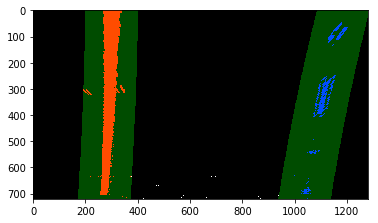

In [296]:


# Code to visualize the selection window
def visualize_selection_window(binary_warped, left_lane_inds, right_lane_inds):
    margin = 100
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

visualize_selection_window(warped_image, left_lane_inds, right_lane_inds)


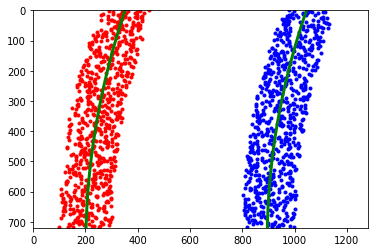

In [305]:

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-100, high=101) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-100, high=101) 
                                for y in ploty])

infoLog(leftx.shape)

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y



# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

plt.savefig('./project/output_images/fit_lane_lines.png', bbox_inches='tight')



In [306]:


# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
infoLog(str(left_curverad) + ',' + str(right_curverad))
# Example values: 1926.74 1908.48



In [302]:

# Once lane(s) have been detected, we will the region between them
# We also draw a line representing lane center
# We also draw a small ( red ) line representing center of the car

def fill_lane(warped, original_image, left_fit, right_fit):
    
    (image_height, image_width) = warped.shape
    car_center_x = int(image_width/2)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Obtain lane points corresponding to the fit
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    infoLog(np.min(left_fitx))
    infoLog(np.max(left_fitx))
    infoLog(np.min(right_fitx))
    infoLog(np.max(right_fitx))
    
    y_bottom = 719
    y_top = 0
    
    leftx_bottom = int(left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2])
    leftx_top = int(left_fit[0]*y_top**2 + left_fit[1]*y_top + left_fit[2])
    rightx_bottom = int(right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2])
    rightx_top = int(right_fit[0]*y_top**2 + right_fit[1]*y_top + right_fit[2])   
    
    centerx_bottom = int((leftx_bottom + rightx_bottom)/2)
    centerx_top = int((leftx_top + rightx_top)/2)
        
    # Calculations to get the bottom pixel
    left_bottom = (leftx_bottom, y_bottom)
    left_top = (leftx_top, y_top)
    right_bottom = (rightx_bottom, y_bottom)
    right_top = (rightx_top, y_top)
    
    center_bottom = (centerx_bottom, y_bottom)
    center_top = (centerx_top, y_top)
    
    car_center_bottom = (car_center_x, y_bottom)
    car_center_top = (car_center_x, y_bottom - 5)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw lane edges
    cv2.line(color_warp, left_bottom, left_top, (255,255, 0), 50)
    cv2.line(color_warp, right_bottom, right_top, (255,255, 0), 50)
    
    # Draw lane center
    cv2.line(color_warp, center_bottom, center_top, (255,255, 0), 10, 1)
    
    # Draw car center
    cv2.line(color_warp, car_center_bottom, car_center_top, (255,0, 0), 10, 1)
        
#     plt.imshow(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result


img = fill_lane(warped_image, img, left_fit, right_fit)
# plt.imshow(img)
# cv2.imwrite('./project/output_images/fill_lane_lines.png', img)


# Get Measurements like:
* Left Radius of curvature.
* Right Radius of curvature.
* Mean Radius of curvature. 
* Vehicle position relative to lane center.
* 'Detected' X-coordinate of bottom of left lane.
* 'Detected' X-coordinate of bottom of right lane.


In [237]:

# Get relevant measurements, based on the fit values
def get_measurements(left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    mean_curverad = (left_curverad + right_curverad) / 2.0

    # Now our radius of curvature is in meters
    infoLog(str(left_curverad) + 'm' + str(right_curverad) + 'm' + str(mean_curverad) + 'm')
    
    # Perform Distance from center calculation
    car_center = 640
    y_bottom = 719
    
    leftx_bottom = int(left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2])
    rightx_bottom = int(right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2])
    lane_center_bottom = (leftx_bottom + rightx_bottom) / 2
    
    relative_position = car_center - lane_center_bottom
    relative_position_meters = relative_position*xm_per_pix
    relative_position_string = "right of lane center" if relative_position_meters > 0 else "left of lane center"
    vehicle_position_string = "Car is " + str(np.abs(round(relative_position_meters, 4))) + " m " + relative_position_string 
    
    return left_curverad, right_curverad, mean_curverad, vehicle_position_string, relative_position_meters, leftx_bottom, rightx_bottom


left_curverad, right_curverad, mean_curverad, vehicle_position_string, relative_position_meters, leftx_bottom, rightx_bottom  = get_measurements(left_fit, right_fit)

debugLog(vehicle_position_string)



Car is 0.0793 m left of lane center



# Add the above measurements to the original image



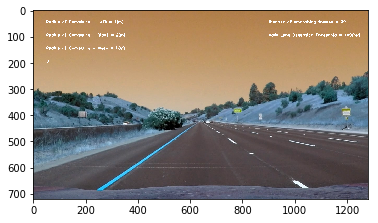

In [248]:

# Add the different relevant measurements to an input image
def add_measurements_to_image(param_img, left_curverad, right_curverad, mean_curverad, vehicle_position_string, history_frames, valid_lane_threshold):
    return_img = param_img.copy()

    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(return_img, 'Radius of Curvature - Left = %d(m)' % left_curverad, (50, 50), font, const_measurements_fontsize, const_measurements_fontcolor, 2)
    cv2.putText(return_img, 'Radius of Curvature - Right = %d(m)' % right_curverad, (50, 100), font, const_measurements_fontsize, const_measurements_fontcolor, 2)
    cv2.putText(return_img, 'Radius of Curvature - Mean = %d(m)' % mean_curverad, (50, 150), font, const_measurements_fontsize, const_measurements_fontcolor, 2)
    cv2.putText(return_img, '%s' % vehicle_position_string, (50, 200), font, const_measurements_fontsize, const_measurements_fontcolor, 2)
    cv2.putText(return_img, 'Number of smoothing frames = %d' % history_frames, (900, 50), font, const_measurements_fontsize, const_measurements_fontcolor, 2)
    cv2.putText(return_img, 'Valid Lane Detection Threshold = %d(px)' % valid_lane_threshold, (900, 100), font, const_measurements_fontsize, const_measurements_fontcolor, 2)

#     cv2.imwrite("calculations.jpg", return_img)

    return return_img

return_img = add_measurements_to_image(img, 1,2,1.5,3 , 20, 100 )

plt.imshow(return_img)


# Lane ( History ) Management Code

* Code for doing the following:
    * Keeping a track of all left and right 'fits'.
    * Keeping a track of past 'X' valid left and right fits.
    * Validating a fit.
    * Smoothing a fit. 
    * Resetting the history for a new run.

In [300]:

# The number of valid history objects to store for validation, and interpolation
const_history_size = 50
const_max_lane_bottom_intersection_x_valid_threshold = 70

# List(s) below were used to view the general trend of various calculations for the pipeline
global_left_fit_list = list()
global_right_fit_list = list()
global_left_curverad_list = list()
global_right_curverad_list = list()
global_leftx_bottom_list = list()
global_rightx_bottom_list = list()

# List(s) below was used to : 1. Store last 5 history points 2. Bottom 'X' intersection points for left lane and right lane, 3. Evaluate if the detected new intersection points made sense.
global_left_coeffs_history = collections.deque(maxlen=const_history_size)
global_right_coeffs_history = collections.deque(maxlen=const_history_size)
global_left_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)
global_right_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)

# Reset all state
def reset_history():
    global global_left_fit_list
    global global_right_fit_list
    global global_left_curverad_list
    global global_right_curverad_list
    global global_leftx_bottom_list
    global global_rightx_bottom_list
    
    global global_left_coeffs_history
    global global_right_coeffs_history
    global global_left_lane_bottom_intersection_x
    global global_right_lane_bottom_intersection_x
    
    global_left_fit_list = None
    global_right_fit_list = None
    global_left_curverad_list = None
    global_right_curverad_list = None
    global_leftx_bottom_list = None
    global_rightx_bottom_list = None
    
    global_left_fit_list = list()
    global_right_fit_list = list()
    global_left_curverad_list = list()
    global_right_curverad_list = list()
    global_leftx_bottom_list = list()
    global_rightx_bottom_list = list()
    
    global_left_coeffs_history = collections.deque(maxlen=const_history_size)
    global_right_coeffs_history = collections.deque(maxlen=const_history_size)
    global_left_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)
    global_right_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)

# Update state values with currently detected values
def update_history(param_left_fit, param_right_fit, param_left_curverad, param_right_curverad, param_leftx_bottom, param_rightx_bottom):
    global global_left_fit_list
    global global_right_fit_list
    global global_left_curverad_list
    global global_right_curverad_list
    global global_leftx_bottom_list
    global global_rightx_bottom_list
    
    global_left_fit_list.append(param_left_fit)
    global_right_fit_list.append(param_right_fit) 
    global_left_curverad_list.append(param_left_curverad)
    global_right_curverad_list.append(param_right_curverad)
    global_leftx_bottom_list.append(param_leftx_bottom)
    global_rightx_bottom_list.append(param_rightx_bottom)
    
    update_history_bottom_intersection_x(param_leftx_bottom, param_rightx_bottom)

# Update the left fit history
def update_history_left_fit(param_left_fit):
    global global_left_coeffs_history
    
    # Add the items to History
    if(param_left_fit != None):
        global_left_coeffs_history.appendleft(param_left_fit)

# Update the right fit history
def update_history_right_fit(param_right_fit):
    global global_right_coeffs_history
    
    # Add the items to History
    if(param_right_fit != None):
        global_right_coeffs_history.appendleft(param_right_fit)

# Get the average value of the past valid fit coefficients from history
def get_coeffs_from_history():
    global global_left_coeffs_history
    global global_right_coeffs_history
    
    # Add the items to History
    left_coeffs_list = list(global_left_coeffs_history)
    right_coeffs_list = list(global_right_coeffs_history)
    
    infoLog(global_left_coeffs_history)
    infoLog(global_right_coeffs_history)
    
    left_coeff_history = np.mean(left_coeffs_list, axis=0)
    right_coeff_history = np.mean(right_coeffs_list, axis=0)
    
    infoLog(left_coeff_history)
    infoLog(right_coeff_history)
    
    return left_coeff_history, right_coeff_history

# Update the historical record of the left lane bottom intersection point and right lane bottom intersection point
def update_history_bottom_intersection_x(left_bottom_intersection_x, right_bottom_intersection_x):
    global global_left_lane_bottom_intersection_x
    global global_right_lane_bottom_intersection_x
    
    # Add the items to History
    if(left_bottom_intersection_x != None):
        global_left_lane_bottom_intersection_x.appendleft(left_bottom_intersection_x)
    
    if(right_bottom_intersection_x != None):
        global_right_lane_bottom_intersection_x.appendleft(right_bottom_intersection_x)
    
    infoLog(global_left_lane_bottom_intersection_x)
    infoLog(global_right_lane_bottom_intersection_x)

# Fetch the average value of the recently detected intersection points for the left lane and the right lane
def get_bottom_intersection_points_x_from_history():
    global global_left_lane_bottom_intersection_x
    global global_right_lane_bottom_intersection_x
    
    left_bottom_intersection_point_x_history = np.mean(global_left_lane_bottom_intersection_x)
    right_bottom_intersection_point_x_history = np.mean(global_right_lane_bottom_intersection_x)
    
    infoLog(global_left_lane_bottom_intersection_x)
    infoLog(global_right_lane_bottom_intersection_x)
    
    return left_bottom_intersection_point_x_history, right_bottom_intersection_point_x_history

# Signals of a good fit:
# * bottom_left_x, and bottom_right_x are close to the average of the past few X co ordinate values
def is_lane_bottom_x_intersection_valid(current_intersection_point_x, history_intersection_point_x):
    if(math.isnan(history_intersection_point_x) == False):
        difference = abs(current_intersection_point_x-history_intersection_point_x)
        if (difference <= const_max_lane_bottom_intersection_x_valid_threshold):
            infoLog("Current point is valid.")
            return True
        else:
            debugLog("Current point : " + str(current_intersection_point_x))
            debugLog("Historical point ( mean ) : " + str(history_intersection_point_x))
            debugLog("Current point is invalid.")
            return False
    else:
        debugLog("Returning valid, because currently we do not have any history.")
        return True




# Pipeline

* Define the Pipeline.
* Execute it on a test image as a quick check.


Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


True

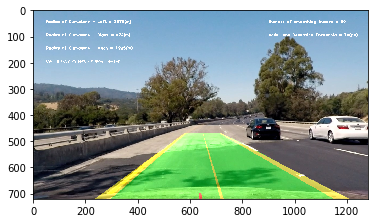

In [307]:

def pipeline_v2(imageOrPath, isImagePath = False, enable_visualization = False, write_to_disk = False):

    # If the image is a path, then read the image from Path
    image = None
    if(isImagePath == True):
        image = mpimg.imread(imageOrPath) # Reads image as an RGB image
    else:
        image = imageOrPath

    # Clear out matplotlib plot frame for each run
    plt.clf()

    # Distortion correction
    dc_image = cal_undistort_mtx(image, mtx, dist)
    
    # Thresholding
    thresholded_image = thresholding(dc_image,(40, 100),(180,255))

    # RoI selection
    image_shape = image.shape
    vertices = np.array([[(0,image_shape[0]),(550, 470), (750, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)
    region_of_interest_image = region_of_interest(thresholded_image, vertices)

    # Perspective transform
    warped_image, M, Minv = warp_src_dest(region_of_interest_image, const_src, const_dest)
    
    # Perform lane fit
    left_fit, right_fit, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, leftx_bottom, rightx_bottom = detect_lanes_and_fit_poly(warped_image)    
    
    # Evaluate Quality of fit
    ## Get historical data
    left_bottom_intersection_point_x_history, right_bottom_intersection_point_x_history = get_bottom_intersection_points_x_from_history()
    
    # Evaluate left fit 
    left_fit_valid = is_lane_bottom_x_intersection_valid(leftx_bottom, left_bottom_intersection_point_x_history)
    
    # If left fit is valid
    ## Update Left coefficient 'Window' history with this value
    if left_fit_valid == True:
        update_history_left_fit(left_fit)

    # Evaluate right fit 
    right_fit_valid = is_lane_bottom_x_intersection_valid(rightx_bottom, right_bottom_intersection_point_x_history)
    
    # If right fit is valid
    ## Update Left coefficient 'Window' history with this value
    if right_fit_valid == True:
        update_history_right_fit(right_fit)
    
    ## Fetch the 'valid' and 'smoothened' fit from history
    left_fit, right_fit = get_coeffs_from_history()
    
    # Perform necessary calculations
    left_curverad, right_curverad, mean_curverad, vehicle_position_string, relative_position_meters, leftx_bottom, rightx_bottom = get_measurements(left_fit, right_fit)
    
    # Overlay filled lane line(s) onto original image
    return_img = fill_lane(warped_image, dc_image, left_fit, right_fit)

    update_history(left_fit, right_fit, left_curverad, right_curverad, leftx_bottom, rightx_bottom)

    # Add the calculations to the image
    return_img = add_measurements_to_image(return_img, left_curverad, right_curverad, mean_curverad, vehicle_position_string, const_history_size, const_max_lane_bottom_intersection_x_valid_threshold )
           
    # Return the image
    return return_img

reset_history()
combined_img = pipeline_v2(const_test_image_4, True, True, True)
plt.imshow(combined_img)

cv2.imwrite('./project/output_images/original_image_with_lanes_calculations.png', combined_img)


# Execute the Pipeline on the Project Video


Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.
[MoviePy] >>>> Building video ./project/project_video_output.mp4
[MoviePy] Writing video ./project/project_video_output.mp4



 49%|████▊     | 614/1261 [03:09<03:27,  3.11it/s]


Current point : 725

Historical point ( mean ) : 1075.36

Current point is invalid.



 49%|████▉     | 618/1261 [03:10<03:42,  2.89it/s]


Current point : 1003

Historical point ( mean ) : 1075.76

Current point is invalid.



 67%|██████▋   | 849/1261 [04:22<02:03,  3.32it/s]


Current point : 289

Historical point ( mean ) : 359.52

Current point is invalid.



 67%|██████▋   | 850/1261 [04:23<02:10,  3.15it/s]


Current point : 287

Historical point ( mean ) : 359.02

Current point is invalid.



 67%|██████▋   | 851/1261 [04:23<02:11,  3.11it/s]


Current point : 286

Historical point ( mean ) : 358.52

Current point is invalid.



 68%|██████▊   | 852/1261 [04:23<02:06,  3.24it/s]


Current point : 283

Historical point ( mean ) : 358.0

Current point is invalid.



 68%|██████▊   | 853/1261 [04:24<02:04,  3.28it/s]


Current point : 281

Historical point ( mean ) : 357.48

Current point is invalid.



 68%|██████▊   | 854/1261 [04:24<02:10,  3.13it/s]


Current point : 278

Historical point ( mean ) : 356.96

Current point is invalid.



 68%|██████▊   | 855/1261 [04:24<02:09,  3.13it/s]


Current point : 278

Historical point ( mean ) : 356.42

Current point is invalid.



 68%|██████▊   | 856/1261 [04:25<02:04,  3.25it/s]


Current point : 279

Historical point ( mean ) : 355.88

Current point is invalid.



 68%|██████▊   | 857/1261 [04:25<02:02,  3.29it/s]


Current point : 279

Historical point ( mean ) : 355.34

Current point is invalid.



 68%|██████▊   | 858/1261 [04:25<02:08,  3.15it/s]


Current point : 277

Historical point ( mean ) : 354.78

Current point is invalid.



 68%|██████▊   | 859/1261 [04:25<02:07,  3.16it/s]


Current point : 278

Historical point ( mean ) : 354.22

Current point is invalid.



 68%|██████▊   | 860/1261 [04:26<02:03,  3.25it/s]


Current point : 279

Historical point ( mean ) : 353.66

Current point is invalid.



 68%|██████▊   | 861/1261 [04:26<02:00,  3.33it/s]


Current point : 282

Historical point ( mean ) : 353.1

Current point is invalid.



 79%|███████▉  | 1001/1261 [05:10<01:18,  3.31it/s]


Current point : 959

Historical point ( mean ) : 1072.68

Current point is invalid.



 79%|███████▉  | 1002/1261 [05:10<01:24,  3.07it/s]


Current point : 793

Historical point ( mean ) : 1073.06

Current point is invalid.



 80%|███████▉  | 1003/1261 [05:11<01:24,  3.06it/s]


Current point : 772

Historical point ( mean ) : 1073.44

Current point is invalid.



 82%|████████▏ | 1032/1261 [05:20<01:14,  3.05it/s]


Current point : 225

Historical point ( mean ) : 307.48

Current point is invalid.



 82%|████████▏ | 1034/1261 [05:21<01:15,  2.99it/s]


Current point : 231

Historical point ( mean ) : 306.7

Current point is invalid.



 82%|████████▏ | 1035/1261 [05:21<01:13,  3.07it/s]


Current point : 235

Historical point ( mean ) : 306.26

Current point is invalid.



 82%|████████▏ | 1038/1261 [05:22<01:12,  3.07it/s]


Current point : 1218

Historical point ( mean ) : 1081.08

Current point is invalid.



 82%|████████▏ | 1039/1261 [05:23<01:11,  3.09it/s]


Current point : 1166

Historical point ( mean ) : 1080.86

Current point is invalid.



 83%|████████▎ | 1042/1261 [05:24<01:12,  3.01it/s]


Current point : 847

Historical point ( mean ) : 1080.26

Current point is invalid.



 83%|████████▎ | 1043/1261 [05:24<01:11,  3.04it/s]


Current point : 214

Historical point ( mean ) : 301.44

Current point is invalid.

Current point : 620

Historical point ( mean ) : 1080.02

Current point is invalid.



 83%|████████▎ | 1044/1261 [05:24<01:11,  3.05it/s]


Current point : 716

Historical point ( mean ) : 1079.78

Current point is invalid.



 83%|████████▎ | 1045/1261 [05:25<01:11,  3.03it/s]


Current point : 754

Historical point ( mean ) : 1079.56

Current point is invalid.



 83%|████████▎ | 1046/1261 [05:25<01:09,  3.09it/s]


Current point : 743

Historical point ( mean ) : 1079.34

Current point is invalid.



 83%|████████▎ | 1047/1261 [05:25<01:09,  3.08it/s]


Current point : 731

Historical point ( mean ) : 1079.12

Current point is invalid.



 83%|████████▎ | 1048/1261 [05:26<01:14,  2.86it/s]


Current point : 728

Historical point ( mean ) : 1078.88

Current point is invalid.



 83%|████████▎ | 1049/1261 [05:26<01:13,  2.90it/s]


Current point : 673

Historical point ( mean ) : 1078.64

Current point is invalid.



 83%|████████▎ | 1050/1261 [05:26<01:11,  2.96it/s]


Current point : 711

Historical point ( mean ) : 1078.38

Current point is invalid.



 83%|████████▎ | 1051/1261 [05:27<01:16,  2.74it/s]


Current point : 735

Historical point ( mean ) : 1078.12

Current point is invalid.



100%|█████████▉| 1260/1261 [06:34<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project/project_video_output.mp4 

CPU times: user 4min 41s, sys: 6.49 s, total: 4min 47s
Wall time: 6min 37s


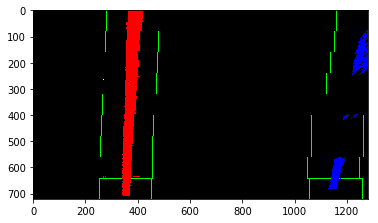

In [242]:

reset_history()
clip1 = VideoFileClip("./project/project_video.mp4")
output_clip1 = clip1.fl_image(pipeline_v2)
output1 = './project/project_video_output.mp4'
%time output_clip1.write_videofile(output1, audio=False)


# Analyze the fits generated for project video
* In the section below we :
    * Plot the various fit coefficients.
    * Plot the radius of curvature values.
* We do this to get a better understanding of :
    * How the pipeline sees the road.
    * When the pipeline fails, what does it see.
* The results of this analysis were then used retroactively in refining the pipeline for smoothing lane detections.

## Analyze Fits

In [217]:

# Analyze fits
debugLog(len(global_left_fit_list))
debugLog(len(global_right_fit_list))
debugLog(len(global_left_curverad_list))
debugLog(len(global_right_curverad_list))
debugLog(len(global_leftx_bottom_list))
debugLog(len(global_rightx_bottom_list))

left_fit_coeff_0 = [coeffs[0] for coeffs in global_left_fit_list]
left_fit_coeff_1 = [coeffs[1] for coeffs in global_left_fit_list]
left_fit_coeff_2 = [coeffs[2] for coeffs in global_left_fit_list]

right_fit_coeff_0 = [coeffs[0] for coeffs in global_right_fit_list]
right_fit_coeff_1 = [coeffs[1] for coeffs in global_right_fit_list]
right_fit_coeff_2 = [coeffs[2] for coeffs in global_right_fit_list]



1261

1261

1261

1261

1261

1261


## Analyze Left Lane Coefficient #0


2.05075148685e-05

0.000113034310087

0.000226068620174


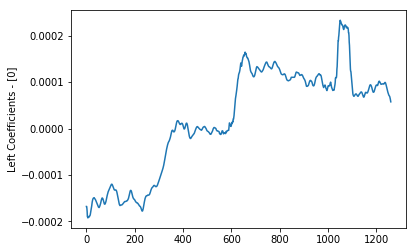

In [218]:

debugLog(np.mean(left_fit_coeff_0))
debugLog(np.std(left_fit_coeff_0))
debugLog(2*np.std(left_fit_coeff_0))

plt.plot(left_fit_coeff_0)
# plt.plot(rolling_left_fit_coeff_0)
plt.ylabel('Left Coefficients - [0]')
plt.show()


## Analyze Left Lane Coefficient #1


-0.088251773756


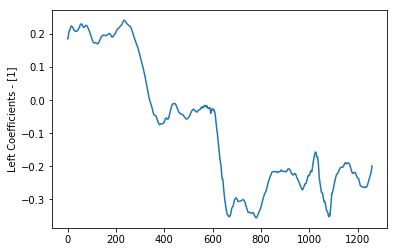

In [219]:

debugLog(np.mean(left_fit_coeff_1))

plt.plot(left_fit_coeff_1)
plt.ylabel('Left Coefficients - [1]')
plt.show()



## Analyze Left Lane Coefficient #2

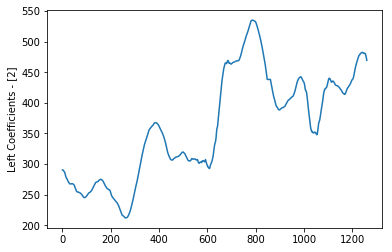

In [220]:

plt.plot(left_fit_coeff_2)
plt.ylabel('Left Coefficients - [2]')
plt.show()


## Analyze Right Lane Coefficient #0

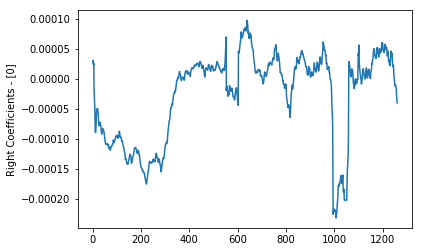

In [221]:

plt.plot(right_fit_coeff_0)
plt.ylabel('Right Coefficients - [0]')
plt.show()


## Analyze Right Lane Coefficient #1

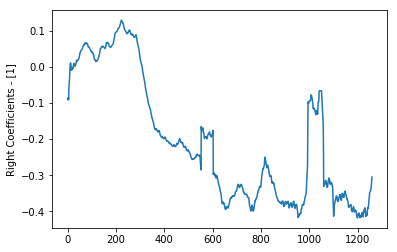

In [222]:

plt.plot(right_fit_coeff_1)
plt.ylabel('Right Coefficients - [1]')
plt.show()


## Analyze Right Lane Coefficient #2

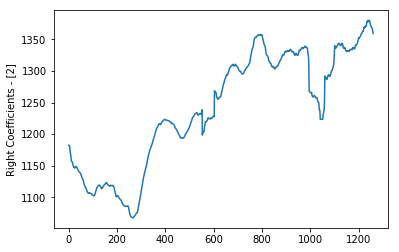

In [223]:

plt.plot(right_fit_coeff_2)
plt.ylabel('Right Coefficients - [2]')
plt.show()


## Analyze Left Radius of curvature


18426.2499438

705.031002211

4208708.34218

152730.255882

305460.511764


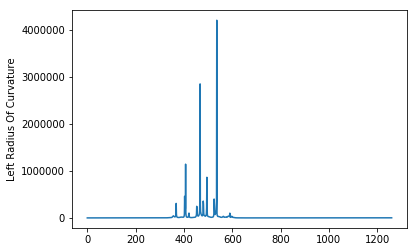

In [224]:

# Left Radius of Curvature

# Descriptive Statistics
debugLog(np.mean(global_left_curverad_list))
debugLog(np.min(global_left_curverad_list))
debugLog(np.max(global_left_curverad_list))
debugLog(np.std(global_left_curverad_list))
debugLog(2*np.std(global_left_curverad_list))

# Plot
plt.plot(global_left_curverad_list)
plt.ylabel('Left Radius Of Curvature')
plt.show()


## Analyze Right Radius of curvature


15545.5344491

710.688838482

1818947.96392

73738.1883932

147476.376786


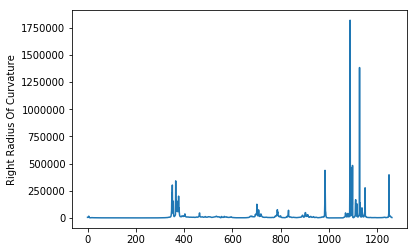

In [225]:

# Right Radius of Curvature

# Descriptive Statistics
debugLog(np.mean(global_right_curverad_list))
debugLog(np.min(global_right_curverad_list))
debugLog(np.max(global_right_curverad_list))
debugLog(np.std(global_right_curverad_list))
debugLog(2*np.std(global_right_curverad_list))

# Plot
plt.plot(global_right_curverad_list)
plt.ylabel('Right Radius Of Curvature')
plt.show()


## Analyze Left Lane Bottom - Detected intersection point


309.191911182

259

367

24.656491063

49.3129821261


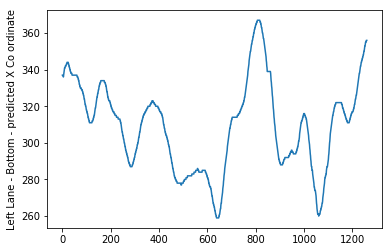

In [226]:

# Left bottom detected lane intersection point

# Descriptive Statistics
debugLog(np.mean(global_leftx_bottom_list))
debugLog(np.min(global_leftx_bottom_list))
debugLog(np.max(global_leftx_bottom_list))
debugLog(np.std(global_leftx_bottom_list))
debugLog(2*np.std(global_leftx_bottom_list))

# Plot
plt.plot(global_leftx_bottom_list)
plt.ylabel('Left Lane - Bottom - predicted X Co ordinate')
plt.show()


## Analyze Right Lane Bottom - Detected intersection point


1078.79540048

1045

1133

17.5641841735

35.128368347


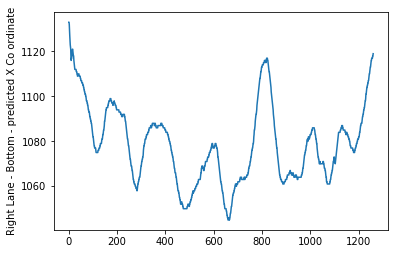

In [227]:

# Right bottom detected lane intersection point

# Descriptive Statistics
debugLog(np.mean(global_rightx_bottom_list))
debugLog(np.min(global_rightx_bottom_list))
debugLog(np.max(global_rightx_bottom_list))
debugLog(np.std(global_rightx_bottom_list))
debugLog(2*np.std(global_rightx_bottom_list))

# Plot
plt.plot(global_rightx_bottom_list)
plt.ylabel('Right Lane - Bottom - predicted X Co ordinate')
plt.show()


# Pipeline as executed on a few other test Images


Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


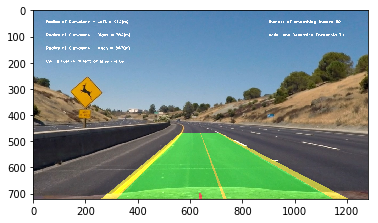

In [228]:

reset_history()
combined_img = pipeline_v2(const_test_image_2, True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


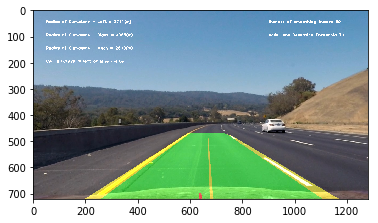

In [230]:

reset_history()
combined_img = pipeline_v2(const_test_image_3, True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


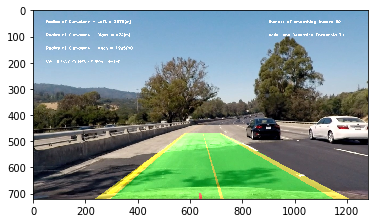

In [231]:

reset_history()
combined_img = pipeline_v2(const_test_image_4, True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


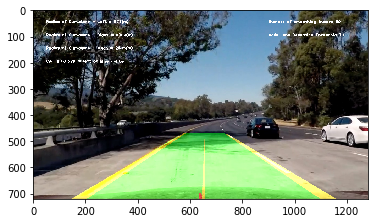

In [232]:

reset_history()
combined_img = pipeline_v2(const_test_image_5, True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


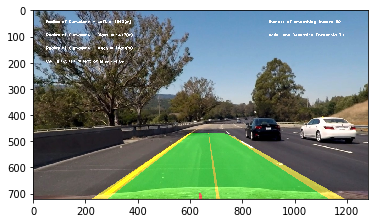

In [233]:

reset_history()
combined_img = pipeline_v2(const_test_image_6, True, True, True)
plt.imshow(combined_img)


# Pipeline as executed on a few Challenge Image(s)

* From the challenge video(s), I picked a few challenging video frame(s), and ran the pipeline on these images.


Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


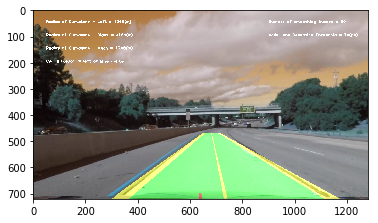

In [253]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[0], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


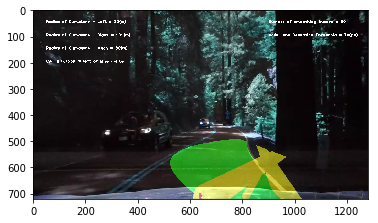

In [254]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[1], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


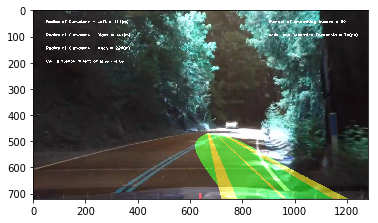

In [255]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[2], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


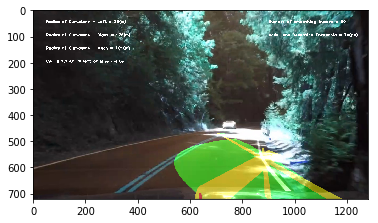

In [256]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[3], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


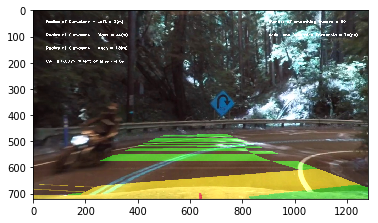

In [257]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[4], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


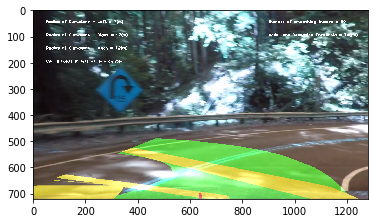

In [258]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[5], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


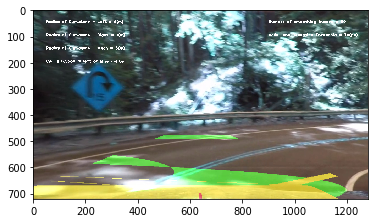

In [259]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[6], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


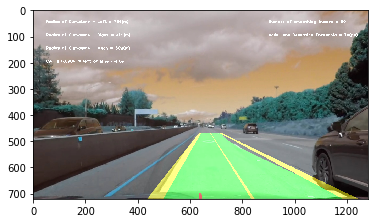

In [260]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[7], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


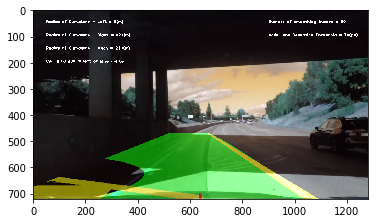

In [261]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[8], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


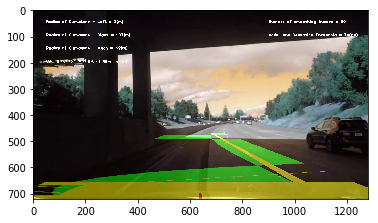

In [262]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[9], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


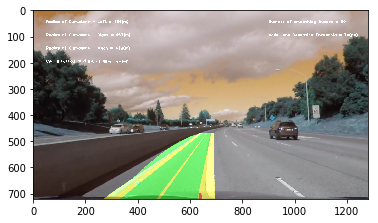

In [263]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[10], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


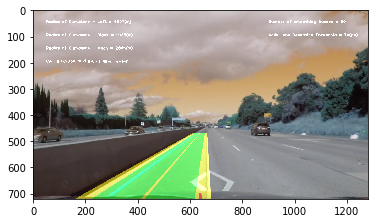

In [264]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[11], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


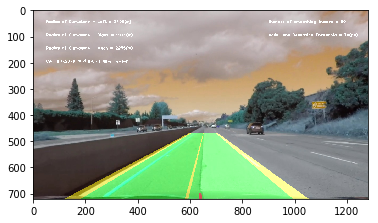

In [265]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[12], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


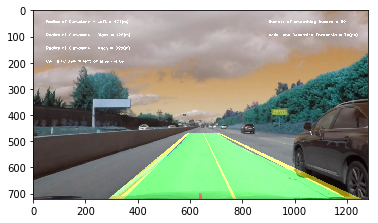

In [266]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[13], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


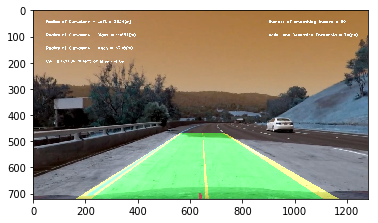

In [267]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[14], True, True, True)
plt.imshow(combined_img)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.


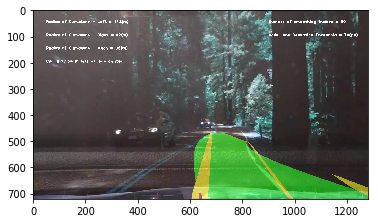

In [268]:

reset_history()
combined_img = pipeline_v2(const_challenge_image_paths[15], True, True, True)
plt.imshow(combined_img)


# Pipeline as executed on the Challenge Video

* Currently, this is leading to a TypeError because a fit cannot be found for a frame.
* The resolution strategy for this scenario, would be to pick a different set of parameters for thresholding, so that the lane(s) can be detected, and fits can be generated.

In [240]:

reset_history()

clip2 = VideoFileClip("./project/challenge_video.mp4")
output_clip2 = clip2.fl_image(pipeline_v2)
output2 = './project/challenge_video_output_v2_2.mp4'
%time output_clip2.write_videofile(output2, audio=False)



Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.
[MoviePy] >>>> Building video ./project/challenge_video_output_v2_2.mp4
[MoviePy] Writing video ./project/challenge_video_output_v2_2.mp4



  2%|▏         | 10/485 [00:02<01:50,  4.31it/s]


Current point : 216

Historical point ( mean ) : 361.2

Current point is invalid.



 10%|▉         | 47/485 [00:11<02:02,  3.58it/s]


Current point : 476

Historical point ( mean ) : 367.276595745

Current point is invalid.



 10%|▉         | 48/485 [00:11<02:12,  3.30it/s]


Current point : 450

Historical point ( mean ) : 367.5625

Current point is invalid.



 10%|█         | 50/485 [00:12<02:35,  2.79it/s]


Current point : 454

Historical point ( mean ) : 368.12

Current point is invalid.



 11%|█         | 51/485 [00:12<02:28,  2.92it/s]


Current point : 451

Historical point ( mean ) : 368.5

Current point is invalid.



 11%|█         | 53/485 [00:13<02:24,  2.98it/s]


Current point : 463

Historical point ( mean ) : 369.32

Current point is invalid.



 11%|█         | 54/485 [00:13<02:18,  3.11it/s]


Current point : 466

Historical point ( mean ) : 369.78

Current point is invalid.



 11%|█▏        | 55/485 [00:14<02:13,  3.23it/s]


Current point : 452

Historical point ( mean ) : 370.24

Current point is invalid.

Current point : 971

Historical point ( mean ) : 1043.32

Current point is invalid.



 12%|█▏        | 56/485 [00:14<02:19,  3.08it/s]


Current point : 466

Historical point ( mean ) : 370.7

Current point is invalid.

Current point : 973

Historical point ( mean ) : 1043.32

Current point is invalid.



 12%|█▏        | 57/485 [00:14<02:17,  3.12it/s]


Current point : 485

Historical point ( mean ) : 371.16

Current point is invalid.

Current point : 973

Historical point ( mean ) : 1043.34

Current point is invalid.



 12%|█▏        | 58/485 [00:15<02:12,  3.21it/s]


Current point : 471

Historical point ( mean ) : 371.58

Current point is invalid.

Current point : 964

Historical point ( mean ) : 1043.36

Current point is invalid.



 12%|█▏        | 59/485 [00:15<02:11,  3.25it/s]


Current point : 494

Historical point ( mean ) : 372.0

Current point is invalid.

Current point : 964

Historical point ( mean ) : 1043.38

Current point is invalid.



 12%|█▏        | 60/485 [00:15<02:17,  3.09it/s]


Current point : 479

Historical point ( mean ) : 372.44

Current point is invalid.

Current point : 963

Historical point ( mean ) : 1043.38

Current point is invalid.



 13%|█▎        | 61/485 [00:16<02:16,  3.10it/s]


Current point : 489

Historical point ( mean ) : 372.88

Current point is invalid.

Current point : 961

Historical point ( mean ) : 1043.4

Current point is invalid.


 13%|█▎        | 62/485 [00:16<02:11,  3.22it/s]


Current point : 487

Historical point ( mean ) : 373.32

Current point is invalid.

Current point : 964

Historical point ( mean ) : 1043.44

Current point is invalid.


 13%|█▎        | 63/485 [00:16<02:09,  3.27it/s]


Current point : 514

Historical point ( mean ) : 373.76

Current point is invalid.


 13%|█▎        | 64/485 [00:16<02:14,  3.13it/s]


Current point : 518

Historical point ( mean ) : 374.2

Current point is invalid.


 13%|█▎        | 65/485 [00:17<02:15,  3.09it/s]


Current point : 523

Historical point ( mean ) : 374.64

Current point is invalid.


 14%|█▎        | 66/485 [00:17<02:13,  3.14it/s]


Current point : 527

Historical point ( mean ) : 375.08

Current point is invalid.

Current point : 943

Historical point ( mean ) : 1043.58

Current point is invalid.


 14%|█▍        | 67/485 [00:17<02:09,  3.23it/s]


Current point : 535

Historical point ( mean ) : 375.52

Current point is invalid.

Current point : 756

Historical point ( mean ) : 1043.62

Current point is invalid.


 14%|█▍        | 68/485 [00:18<02:15,  3.09it/s]


Current point : 540

Historical point ( mean ) : 375.94

Current point is invalid.


 14%|█▍        | 69/485 [00:18<02:12,  3.14it/s]


Current point : 545

Historical point ( mean ) : 376.36

Current point is invalid.

Current point : 960

Historical point ( mean ) : 1043.68

Current point is invalid.


 14%|█▍        | 70/485 [00:18<02:08,  3.23it/s]


Current point : 548

Historical point ( mean ) : 376.76

Current point is invalid.

Current point : 968

Historical point ( mean ) : 1043.68

Current point is invalid.


 15%|█▍        | 71/485 [00:19<02:05,  3.29it/s]


Current point : 555

Historical point ( mean ) : 377.16

Current point is invalid.

Current point : 968

Historical point ( mean ) : 1043.68

Current point is invalid.


 15%|█▍        | 72/485 [00:19<02:12,  3.12it/s]


Current point : 560

Historical point ( mean ) : 377.54

Current point is invalid.


 15%|█▌        | 73/485 [00:19<02:10,  3.15it/s]


Current point : 555

Historical point ( mean ) : 377.9

Current point is invalid.

Current point : 953

Historical point ( mean ) : 1043.62

Current point is invalid.


 15%|█▌        | 74/485 [00:20<02:05,  3.27it/s]


Current point : 558

Historical point ( mean ) : 378.26

Current point is invalid.

Current point : 954

Historical point ( mean ) : 1043.56

Current point is invalid.


 15%|█▌        | 75/485 [00:20<02:03,  3.32it/s]


Current point : 483

Historical point ( mean ) : 378.62

Current point is invalid.

Current point : 899

Historical point ( mean ) : 1043.48

Current point is invalid.


 16%|█▌        | 77/485 [00:21<02:10,  3.13it/s]


Current point : 958

Historical point ( mean ) : 1043.24

Current point is invalid.


 16%|█▌        | 78/485 [00:21<02:06,  3.22it/s]


Current point : 247

Historical point ( mean ) : 379.62

Current point is invalid.

Current point : 920

Historical point ( mean ) : 1043.08

Current point is invalid.


 16%|█▋        | 79/485 [00:21<02:04,  3.25it/s]


Current point : 219

Historical point ( mean ) : 379.94

Current point is invalid.

Current point : 970

Historical point ( mean ) : 1042.9

Current point is invalid.


 16%|█▋        | 80/485 [00:21<02:09,  3.13it/s]


Current point : 203

Historical point ( mean ) : 380.24

Current point is invalid.

Current point : 932

Historical point ( mean ) : 1042.7

Current point is invalid.


 17%|█▋        | 81/485 [00:22<02:08,  3.15it/s]


Current point : 937

Historical point ( mean ) : 1042.5

Current point is invalid.


 17%|█▋        | 82/485 [00:22<02:04,  3.23it/s]


Current point : 214

Historical point ( mean ) : 380.78

Current point is invalid.

Current point : 946

Historical point ( mean ) : 1042.3

Current point is invalid.


 17%|█▋        | 83/485 [00:22<02:01,  3.30it/s]


Current point : 600

Historical point ( mean ) : 381.02

Current point is invalid.


 17%|█▋        | 84/485 [00:23<02:07,  3.15it/s]


Current point : 205

Historical point ( mean ) : 381.24

Current point is invalid.


 18%|█▊        | 85/485 [00:23<02:03,  3.24it/s]


Current point : 202

Historical point ( mean ) : 381.44

Current point is invalid.

Current point : 961

Historical point ( mean ) : 1041.66

Current point is invalid.


 18%|█▊        | 86/485 [00:23<01:57,  3.39it/s]


Current point : 205

Historical point ( mean ) : 381.62

Current point is invalid.

Current point : 621

Historical point ( mean ) : 1041.42

Current point is invalid.


 18%|█▊        | 87/485 [00:24<01:54,  3.48it/s]


Current point : 216

Historical point ( mean ) : 381.8

Current point is invalid.


 18%|█▊        | 88/485 [00:24<02:00,  3.31it/s]


Current point : 226

Historical point ( mean ) : 381.96

Current point is invalid.


 18%|█▊        | 89/485 [00:24<01:58,  3.34it/s]


Current point : 307

Historical point ( mean ) : 382.1

Current point is invalid.


 19%|█▊        | 90/485 [00:24<01:56,  3.38it/s]


Current point : 247

Historical point ( mean ) : 382.22

Current point is invalid.


 19%|█▉        | 92/485 [00:25<01:58,  3.30it/s]


Current point : 230

Historical point ( mean ) : 382.38

Current point is invalid.

Current point : 953

Historical point ( mean ) : 1039.56

Current point is invalid.


 19%|█▉        | 93/485 [00:25<01:58,  3.31it/s]


Current point : 234

Historical point ( mean ) : 382.42

Current point is invalid.


 19%|█▉        | 94/485 [00:26<01:56,  3.35it/s]


Current point : 221

Historical point ( mean ) : 382.44

Current point is invalid.

Current point : 966

Historical point ( mean ) : 1038.84

Current point is invalid.


 20%|█▉        | 95/485 [00:26<02:26,  2.67it/s]


Current point : 228

Historical point ( mean ) : 382.44

Current point is invalid.

Current point : 968

Historical point ( mean ) : 1038.5

Current point is invalid.


 20%|█▉        | 96/485 [00:27<02:21,  2.75it/s]


Current point : 236

Historical point ( mean ) : 382.42

Current point is invalid.


 20%|██        | 97/485 [00:27<02:13,  2.90it/s]


Current point : 242

Historical point ( mean ) : 382.42

Current point is invalid.

Current point : 842

Historical point ( mean ) : 1037.86

Current point is invalid.


 20%|██        | 98/485 [00:27<02:05,  3.08it/s]


Current point : 246

Historical point ( mean ) : 382.42

Current point is invalid.


 20%|██        | 99/485 [00:27<01:59,  3.23it/s]


Current point : 253

Historical point ( mean ) : 382.42

Current point is invalid.

Current point : 895

Historical point ( mean ) : 1037.28

Current point is invalid.


 21%|██        | 100/485 [00:28<02:02,  3.13it/s]


Current point : 249

Historical point ( mean ) : 382.4

Current point is invalid.


 21%|██        | 101/485 [00:28<02:01,  3.17it/s]


Current point : 258

Historical point ( mean ) : 382.38

Current point is invalid.


 21%|██        | 102/485 [00:28<01:57,  3.25it/s]


Current point : 241

Historical point ( mean ) : 382.36

Current point is invalid.


 21%|██▏       | 104/485 [00:29<01:58,  3.22it/s]


Current point : 261

Historical point ( mean ) : 382.26

Current point is invalid.


 22%|██▏       | 106/485 [00:30<01:53,  3.35it/s]


Current point : 227

Historical point ( mean ) : 382.14

Current point is invalid.


 22%|██▏       | 107/485 [00:30<01:50,  3.42it/s]


Current point : 245

Historical point ( mean ) : 382.08

Current point is invalid.

Current point : 621

Historical point ( mean ) : 1034.86

Current point is invalid.


 22%|██▏       | 108/485 [00:30<01:55,  3.26it/s]


Current point : 237

Historical point ( mean ) : 382.02

Current point is invalid.

Current point : 628

Historical point ( mean ) : 1034.48

Current point is invalid.


 22%|██▏       | 109/485 [00:30<01:55,  3.25it/s]


Current point : 258

Historical point ( mean ) : 381.96

Current point is invalid.


 23%|██▎       | 110/485 [00:31<01:52,  3.34it/s]


Current point : 268

Historical point ( mean ) : 381.9

Current point is invalid.


 23%|██▎       | 111/485 [00:31<01:50,  3.37it/s]


Current point : 252

Historical point ( mean ) : 381.84

Current point is invalid.


 23%|██▎       | 112/485 [00:31<01:57,  3.17it/s]


Current point : 230

Historical point ( mean ) : 381.78

Current point is invalid.


 23%|██▎       | 113/485 [00:32<01:57,  3.18it/s]


Current point : 243

Historical point ( mean ) : 381.72

Current point is invalid.


 24%|██▎       | 114/485 [00:32<01:54,  3.23it/s]


Current point : 247

Historical point ( mean ) : 381.66

Current point is invalid.


 24%|██▎       | 115/485 [00:32<01:53,  3.26it/s]


Current point : 236

Historical point ( mean ) : 381.6

Current point is invalid.


 24%|██▍       | 116/485 [00:33<02:00,  3.07it/s]


Current point : 234

Historical point ( mean ) : 381.54

Current point is invalid.


 24%|██▍       | 117/485 [00:33<01:58,  3.11it/s]


Current point : 223

Historical point ( mean ) : 381.48

Current point is invalid.


 25%|██▍       | 120/485 [00:34<01:56,  3.14it/s]


Current point : 221

Historical point ( mean ) : 381.26

Current point is invalid.

Current point : 954

Historical point ( mean ) : 1028.38

Current point is invalid.


 25%|██▍       | 121/485 [00:34<01:55,  3.16it/s]


Current point : 222

Historical point ( mean ) : 381.18

Current point is invalid.


 25%|██▌       | 122/485 [00:35<01:52,  3.24it/s]


Current point : 292

Historical point ( mean ) : 381.1

Current point is invalid.


 25%|██▌       | 123/485 [00:35<01:48,  3.33it/s]


Current point : 286

Historical point ( mean ) : 381.02

Current point is invalid.


 26%|██▌       | 124/485 [00:35<01:55,  3.12it/s]


Current point : 215

Historical point ( mean ) : 380.94

Current point is invalid.


 26%|██▌       | 125/485 [00:35<01:53,  3.18it/s]


Current point : 227

Historical point ( mean ) : 380.86

Current point is invalid.


 26%|██▌       | 126/485 [00:36<01:49,  3.27it/s]


Current point : 240

Historical point ( mean ) : 380.78

Current point is invalid.


 26%|██▌       | 127/485 [00:36<01:53,  3.14it/s]


Current point : 249

Historical point ( mean ) : 380.7

Current point is invalid.


 26%|██▋       | 128/485 [00:36<01:57,  3.05it/s]


Current point : 251

Historical point ( mean ) : 380.62

Current point is invalid.


 27%|██▋       | 129/485 [00:37<01:53,  3.14it/s]


Current point : 253

Historical point ( mean ) : 380.54

Current point is invalid.


 27%|██▋       | 130/485 [00:37<01:59,  2.97it/s]


Current point : 250

Historical point ( mean ) : 380.46

Current point is invalid.


 27%|██▋       | 131/485 [00:37<01:59,  2.96it/s]


Current point : 287

Historical point ( mean ) : 380.38

Current point is invalid.


 27%|██▋       | 133/485 [00:38<02:07,  2.76it/s]


Current point : 278

Historical point ( mean ) : 380.26

Current point is invalid.

Current point : 663

Historical point ( mean ) : 1018.88

Current point is invalid.


TypeError: expected non-empty vector for x

# Pipeline as executed on the Harder Challenge Video

* This runs surprisingly well, and produced a decent enough result without any specific tweaks for this video.
* It fails at the very end because of the contrast situation and the steepness of the curve.


Returning valid, because currently we do not have any history.

Returning valid, because currently we do not have any history.
[MoviePy] >>>> Building video ./project/harder_challenge_video_output_v2_2.mp4
[MoviePy] Writing video ./project/harder_challenge_video_output_v2_2.mp4



  5%|▌         | 65/1200 [00:17<06:35,  2.87it/s]


Current point : 1057

Historical point ( mean ) : 974.44

Current point is invalid.


  6%|▌         | 66/1200 [00:18<06:17,  3.01it/s]


Current point : 1048

Historical point ( mean ) : 974.64

Current point is invalid.


  6%|▌         | 69/1200 [00:19<06:16,  3.00it/s]


Current point : 1049

Historical point ( mean ) : 975.36

Current point is invalid.


  6%|▌         | 70/1200 [00:19<06:04,  3.10it/s]


Current point : 1051

Historical point ( mean ) : 975.62

Current point is invalid.


  6%|▌         | 71/1200 [00:19<06:00,  3.13it/s]


Current point : 1050

Historical point ( mean ) : 975.88

Current point is invalid.


  6%|▌         | 72/1200 [00:20<06:23,  2.94it/s]


Current point : 1073

Historical point ( mean ) : 976.14

Current point is invalid.


  6%|▌         | 73/1200 [00:20<06:24,  2.93it/s]


Current point : 1075

Historical point ( mean ) : 976.4

Current point is invalid.


  6%|▌         | 74/1200 [00:20<06:16,  2.99it/s]


Current point : 327

Historical point ( mean ) : 251.66

Current point is invalid.

Current point : 1074

Historical point ( mean ) : 976.66

Current point is invalid.


  6%|▋         | 75/1200 [00:21<06:11,  3.03it/s]


Current point : 326

Historical point ( mean ) : 251.62

Current point is invalid.

Current point : 1076

Historical point ( mean ) : 976.92

Current point is invalid.


  6%|▋         | 76/1200 [00:21<06:41,  2.80it/s]


Current point : 324

Historical point ( mean ) : 251.6

Current point is invalid.

Current point : 1086

Historical point ( mean ) : 977.18

Current point is invalid.


  6%|▋         | 77/1200 [00:21<06:45,  2.77it/s]


Current point : 326

Historical point ( mean ) : 251.6

Current point is invalid.

Current point : 1085

Historical point ( mean ) : 977.44

Current point is invalid.


  6%|▋         | 78/1200 [00:22<06:38,  2.82it/s]


Current point : 328

Historical point ( mean ) : 251.62

Current point is invalid.

Current point : 1094

Historical point ( mean ) : 977.72

Current point is invalid.


  7%|▋         | 79/1200 [00:22<06:25,  2.91it/s]


Current point : 333

Historical point ( mean ) : 251.66

Current point is invalid.

Current point : 1078

Historical point ( mean ) : 978.0

Current point is invalid.


  7%|▋         | 80/1200 [00:22<06:44,  2.77it/s]


Current point : 328

Historical point ( mean ) : 251.7

Current point is invalid.

Current point : 1083

Historical point ( mean ) : 978.28

Current point is invalid.


  7%|▋         | 81/1200 [00:23<06:43,  2.77it/s]


Current point : 330

Historical point ( mean ) : 251.76

Current point is invalid.

Current point : 1095

Historical point ( mean ) : 978.56

Current point is invalid.


  7%|▋         | 82/1200 [00:23<06:33,  2.84it/s]


Current point : 148

Historical point ( mean ) : 251.84

Current point is invalid.

Current point : 1104

Historical point ( mean ) : 978.84

Current point is invalid.


  7%|▋         | 83/1200 [00:23<06:21,  2.92it/s]


Current point : 1089

Historical point ( mean ) : 979.12

Current point is invalid.


  7%|▋         | 84/1200 [00:24<08:31,  2.18it/s]


Current point : 330

Historical point ( mean ) : 252.04

Current point is invalid.

Current point : 1079

Historical point ( mean ) : 979.38

Current point is invalid.


  7%|▋         | 85/1200 [00:25<07:56,  2.34it/s]


Current point : 329

Historical point ( mean ) : 252.14

Current point is invalid.

Current point : 1093

Historical point ( mean ) : 979.64

Current point is invalid.


  7%|▋         | 86/1200 [00:25<07:15,  2.56it/s]


Current point : 329

Historical point ( mean ) : 252.26

Current point is invalid.

Current point : 1102

Historical point ( mean ) : 979.9

Current point is invalid.


  7%|▋         | 87/1200 [00:25<06:43,  2.76it/s]


Current point : 330

Historical point ( mean ) : 252.38

Current point is invalid.

Current point : 1084

Historical point ( mean ) : 980.14

Current point is invalid.


  7%|▋         | 88/1200 [00:26<07:03,  2.63it/s]


Current point : 330

Historical point ( mean ) : 252.52

Current point is invalid.


  7%|▋         | 89/1200 [00:26<06:52,  2.69it/s]


Current point : 351

Historical point ( mean ) : 252.66

Current point is invalid.

Current point : 1053

Historical point ( mean ) : 980.64

Current point is invalid.


  8%|▊         | 90/1200 [00:26<06:38,  2.78it/s]


Current point : 349

Historical point ( mean ) : 252.8

Current point is invalid.

Current point : 1063

Historical point ( mean ) : 980.88

Current point is invalid.


  8%|▊         | 91/1200 [00:27<06:18,  2.93it/s]


Current point : 333

Historical point ( mean ) : 252.96

Current point is invalid.


  8%|▊         | 93/1200 [00:27<06:29,  2.84it/s]


Current point : 335

Historical point ( mean ) : 253.3

Current point is invalid.


  8%|▊         | 94/1200 [00:28<06:21,  2.90it/s]


Current point : 337

Historical point ( mean ) : 253.5

Current point is invalid.


  8%|▊         | 95/1200 [00:28<06:13,  2.96it/s]


Current point : 334

Historical point ( mean ) : 253.7

Current point is invalid.


  8%|▊         | 96/1200 [00:28<06:26,  2.85it/s]


Current point : 337

Historical point ( mean ) : 253.9

Current point is invalid.


  8%|▊         | 97/1200 [00:29<06:26,  2.86it/s]


Current point : 354

Historical point ( mean ) : 254.1

Current point is invalid.

Current point : 1075

Historical point ( mean ) : 983.06

Current point is invalid.


  8%|▊         | 98/1200 [00:29<06:15,  2.93it/s]


Current point : 383

Historical point ( mean ) : 254.3

Current point is invalid.


  8%|▊         | 99/1200 [00:29<06:12,  2.96it/s]


Current point : 348

Historical point ( mean ) : 254.52

Current point is invalid.


  8%|▊         | 100/1200 [00:30<06:42,  2.74it/s]


Current point : 348

Historical point ( mean ) : 254.74

Current point is invalid.

Current point : 1073

Historical point ( mean ) : 984.22

Current point is invalid.


  8%|▊         | 101/1200 [00:30<06:36,  2.77it/s]


Current point : 328

Historical point ( mean ) : 254.96

Current point is invalid.

Current point : 1227

Historical point ( mean ) : 984.64

Current point is invalid.


  8%|▊         | 102/1200 [00:30<06:30,  2.81it/s]


Current point : 327

Historical point ( mean ) : 255.2

Current point is invalid.

Current point : 1176

Historical point ( mean ) : 985.04

Current point is invalid.


  9%|▊         | 103/1200 [00:31<06:20,  2.88it/s]


Current point : 1348

Historical point ( mean ) : 985.44

Current point is invalid.


  9%|▊         | 104/1200 [00:31<06:30,  2.80it/s]


Current point : 1192

Historical point ( mean ) : 985.84

Current point is invalid.


  9%|▉         | 105/1200 [00:31<06:27,  2.83it/s]


Current point : 1172

Historical point ( mean ) : 986.24

Current point is invalid.


  9%|▉         | 106/1200 [00:32<06:10,  2.95it/s]


Current point : 1240

Historical point ( mean ) : 986.64

Current point is invalid.


  9%|▉         | 107/1200 [00:32<05:57,  3.06it/s]


Current point : 1287

Historical point ( mean ) : 987.04

Current point is invalid.


  9%|▉         | 108/1200 [00:32<06:11,  2.94it/s]


Current point : 1259

Historical point ( mean ) : 987.42

Current point is invalid.


  9%|▉         | 109/1200 [00:33<06:12,  2.93it/s]


Current point : 1224

Historical point ( mean ) : 987.8

Current point is invalid.


  9%|▉         | 110/1200 [00:33<05:57,  3.05it/s]


Current point : 1231

Historical point ( mean ) : 988.16

Current point is invalid.


  9%|▉         | 111/1200 [00:33<05:50,  3.10it/s]


Current point : 1232

Historical point ( mean ) : 988.52

Current point is invalid.


  9%|▉         | 112/1200 [00:34<06:10,  2.94it/s]


Current point : 1195

Historical point ( mean ) : 988.86

Current point is invalid.


  9%|▉         | 113/1200 [00:34<06:04,  2.98it/s]


Current point : 1181

Historical point ( mean ) : 989.2

Current point is invalid.


 10%|▉         | 114/1200 [00:34<05:55,  3.06it/s]


Current point : 1189

Historical point ( mean ) : 989.52

Current point is invalid.


 10%|▉         | 115/1200 [00:35<05:46,  3.13it/s]


Current point : 1174

Historical point ( mean ) : 989.82

Current point is invalid.


 10%|▉         | 116/1200 [00:35<06:04,  2.97it/s]


Current point : 1149

Historical point ( mean ) : 990.12

Current point is invalid.


 10%|▉         | 117/1200 [00:35<06:11,  2.92it/s]


Current point : 1115

Historical point ( mean ) : 990.42

Current point is invalid.


 10%|▉         | 118/1200 [00:36<06:06,  2.95it/s]


Current point : 1085

Historical point ( mean ) : 990.7

Current point is invalid.


 10%|█         | 124/1200 [00:38<06:08,  2.92it/s]


Current point : 336

Historical point ( mean ) : 265.3

Current point is invalid.


 10%|█         | 125/1200 [00:38<06:02,  2.97it/s]


Current point : 338

Historical point ( mean ) : 265.88

Current point is invalid.


 10%|█         | 126/1200 [00:38<05:53,  3.04it/s]


Current point : 343

Historical point ( mean ) : 266.46

Current point is invalid.


 11%|█         | 127/1200 [00:39<05:42,  3.13it/s]


Current point : 346

Historical point ( mean ) : 267.04

Current point is invalid.


 11%|█         | 128/1200 [00:39<06:00,  2.97it/s]


Current point : 348

Historical point ( mean ) : 267.62

Current point is invalid.


 11%|█         | 129/1200 [00:39<05:56,  3.00it/s]


Current point : 349

Historical point ( mean ) : 268.2

Current point is invalid.


 11%|█         | 130/1200 [00:40<05:47,  3.08it/s]


Current point : 345

Historical point ( mean ) : 268.78

Current point is invalid.


 12%|█▏        | 149/1200 [00:47<07:13,  2.42it/s]


Current point : 694

Historical point ( mean ) : 1000.4

Current point is invalid.


 12%|█▎        | 150/1200 [00:47<06:43,  2.60it/s]


Current point : 686

Historical point ( mean ) : 1000.6

Current point is invalid.


 13%|█▎        | 151/1200 [00:47<06:13,  2.81it/s]


Current point : 707

Historical point ( mean ) : 1000.8

Current point is invalid.


 13%|█▎        | 152/1200 [00:48<06:21,  2.75it/s]


Current point : 700

Historical point ( mean ) : 1001.0

Current point is invalid.


 13%|█▎        | 154/1200 [00:48<05:47,  3.01it/s]


Current point : 681

Historical point ( mean ) : 1001.42

Current point is invalid.


 13%|█▎        | 155/1200 [00:48<05:33,  3.13it/s]


Current point : 680

Historical point ( mean ) : 1001.64

Current point is invalid.


 13%|█▎        | 156/1200 [00:49<05:49,  2.99it/s]


Current point : 689

Historical point ( mean ) : 1001.86

Current point is invalid.


 13%|█▎        | 157/1200 [00:49<05:47,  3.00it/s]


Current point : 668

Historical point ( mean ) : 1002.08

Current point is invalid.


 13%|█▎        | 158/1200 [00:49<05:35,  3.11it/s]


Current point : 669

Historical point ( mean ) : 1002.3

Current point is invalid.


 13%|█▎        | 159/1200 [00:50<05:28,  3.17it/s]


Current point : 675

Historical point ( mean ) : 1002.52

Current point is invalid.


 13%|█▎        | 160/1200 [00:50<05:54,  2.93it/s]


Current point : 670

Historical point ( mean ) : 1002.74

Current point is invalid.


 13%|█▎        | 161/1200 [00:50<05:48,  2.98it/s]


Current point : 575

Historical point ( mean ) : 1002.96

Current point is invalid.


 14%|█▎        | 162/1200 [00:51<05:34,  3.10it/s]


Current point : 600

Historical point ( mean ) : 1003.18

Current point is invalid.


 14%|█▎        | 163/1200 [00:51<05:28,  3.15it/s]


Current point : 652

Historical point ( mean ) : 1003.4

Current point is invalid.


 14%|█▎        | 164/1200 [00:51<05:41,  3.03it/s]


Current point : 644

Historical point ( mean ) : 1003.62

Current point is invalid.


 14%|█▍        | 165/1200 [00:52<05:34,  3.10it/s]


Current point : 649

Historical point ( mean ) : 1003.84

Current point is invalid.


 14%|█▍        | 166/1200 [00:52<05:23,  3.20it/s]


Current point : 655

Historical point ( mean ) : 1004.06

Current point is invalid.


 14%|█▍        | 167/1200 [00:52<05:12,  3.30it/s]


Current point : 694

Historical point ( mean ) : 1004.28

Current point is invalid.


 14%|█▍        | 168/1200 [00:53<05:30,  3.13it/s]


Current point : 658

Historical point ( mean ) : 1004.5

Current point is invalid.


 14%|█▍        | 169/1200 [00:53<05:26,  3.16it/s]


Current point : 662

Historical point ( mean ) : 1004.72

Current point is invalid.


 14%|█▍        | 170/1200 [00:53<05:15,  3.27it/s]


Current point : 678

Historical point ( mean ) : 1004.9

Current point is invalid.


 14%|█▍        | 171/1200 [00:54<05:10,  3.32it/s]


Current point : 668

Historical point ( mean ) : 1005.04

Current point is invalid.


 14%|█▍        | 172/1200 [00:54<05:30,  3.11it/s]


Current point : 679

Historical point ( mean ) : 1005.16

Current point is invalid.


 15%|█▍        | 178/1200 [00:56<05:04,  3.36it/s]


Current point : 881

Historical point ( mean ) : 1006.42

Current point is invalid.


 15%|█▌        | 181/1200 [00:57<05:21,  3.17it/s]


Current point : 600

Historical point ( mean ) : 1007.32

Current point is invalid.


 15%|█▌        | 183/1200 [00:57<04:59,  3.39it/s]


Current point : 615

Historical point ( mean ) : 1008.0

Current point is invalid.


 15%|█▌        | 184/1200 [00:58<05:21,  3.16it/s]


Current point : 701

Historical point ( mean ) : 1008.34

Current point is invalid.


 15%|█▌        | 185/1200 [00:58<05:23,  3.13it/s]


Current point : 665

Historical point ( mean ) : 1008.68

Current point is invalid.


 16%|█▌        | 186/1200 [00:58<05:10,  3.26it/s]


Current point : 633

Historical point ( mean ) : 1009.02

Current point is invalid.


 16%|█▌        | 187/1200 [00:58<05:04,  3.32it/s]


Current point : 455

Historical point ( mean ) : 300.92

Current point is invalid.

Current point : 663

Historical point ( mean ) : 1009.34

Current point is invalid.


 16%|█▌        | 188/1200 [00:59<05:22,  3.14it/s]


Current point : 410

Historical point ( mean ) : 300.66

Current point is invalid.

Current point : 645

Historical point ( mean ) : 1009.64

Current point is invalid.


 16%|█▌        | 189/1200 [00:59<05:17,  3.18it/s]


Current point : 412

Historical point ( mean ) : 300.38

Current point is invalid.

Current point : 571

Historical point ( mean ) : 1009.92

Current point is invalid.


 16%|█▌        | 190/1200 [00:59<05:09,  3.27it/s]


Current point : 517

Historical point ( mean ) : 300.08

Current point is invalid.

Current point : 681

Historical point ( mean ) : 1010.2

Current point is invalid.


 16%|█▌        | 191/1200 [01:00<05:03,  3.32it/s]


Current point : 540

Historical point ( mean ) : 299.76

Current point is invalid.

Current point : 671

Historical point ( mean ) : 1010.46

Current point is invalid.


 16%|█▌        | 192/1200 [01:00<05:27,  3.08it/s]


Current point : 518

Historical point ( mean ) : 299.42

Current point is invalid.

Current point : 694

Historical point ( mean ) : 1010.72

Current point is invalid.


 16%|█▌        | 193/1200 [01:00<05:30,  3.05it/s]


Current point : 534

Historical point ( mean ) : 299.06

Current point is invalid.

Current point : 732

Historical point ( mean ) : 1010.98

Current point is invalid.


 16%|█▌        | 194/1200 [01:01<05:20,  3.14it/s]


Current point : 472

Historical point ( mean ) : 298.68

Current point is invalid.

Current point : 703

Historical point ( mean ) : 1011.22

Current point is invalid.


 16%|█▋        | 195/1200 [01:01<05:17,  3.16it/s]


Current point : 673

Historical point ( mean ) : 298.28

Current point is invalid.

Current point : 744

Historical point ( mean ) : 1011.46

Current point is invalid.


 16%|█▋        | 196/1200 [01:01<05:38,  2.96it/s]


Current point : 675

Historical point ( mean ) : 297.88

Current point is invalid.

Current point : 714

Historical point ( mean ) : 1011.7

Current point is invalid.


 16%|█▋        | 197/1200 [01:02<05:41,  2.94it/s]


Current point : 667

Historical point ( mean ) : 297.46

Current point is invalid.

Current point : 723

Historical point ( mean ) : 1011.94

Current point is invalid.


 16%|█▋        | 198/1200 [01:02<05:29,  3.04it/s]


Current point : 492

Historical point ( mean ) : 1012.18

Current point is invalid.


 17%|█▋        | 199/1200 [01:02<05:30,  3.03it/s]


Current point : 1088

Historical point ( mean ) : 1012.4

Current point is invalid.


 17%|█▋        | 200/1200 [01:03<05:50,  2.85it/s]


Current point : -7

Historical point ( mean ) : 1012.62

Current point is invalid.


 17%|█▋        | 201/1200 [01:03<05:44,  2.90it/s]


Current point : 169

Historical point ( mean ) : 295.66

Current point is invalid.

Current point : 1109

Historical point ( mean ) : 1012.84

Current point is invalid.


 17%|█▋        | 202/1200 [01:03<05:32,  3.00it/s]


Current point : 167

Historical point ( mean ) : 295.2

Current point is invalid.

Current point : 1105

Historical point ( mean ) : 1013.06

Current point is invalid.


 17%|█▋        | 203/1200 [01:04<05:29,  3.03it/s]


Current point : 166

Historical point ( mean ) : 294.74

Current point is invalid.

Current point : 1100

Historical point ( mean ) : 1013.28

Current point is invalid.


 17%|█▋        | 204/1200 [01:04<05:55,  2.80it/s]


Current point : 187

Historical point ( mean ) : 294.3

Current point is invalid.

Current point : 1124

Historical point ( mean ) : 1013.48

Current point is invalid.


 17%|█▋        | 205/1200 [01:05<05:47,  2.86it/s]


Current point : 207

Historical point ( mean ) : 293.86

Current point is invalid.

Current point : 1134

Historical point ( mean ) : 1013.68

Current point is invalid.


 17%|█▋        | 206/1200 [01:05<05:32,  2.99it/s]


Current point : 221

Historical point ( mean ) : 293.44

Current point is invalid.

Current point : 1135

Historical point ( mean ) : 1013.88

Current point is invalid.


 17%|█▋        | 207/1200 [01:05<05:24,  3.06it/s]


Current point : 218

Historical point ( mean ) : 293.02

Current point is invalid.

Current point : 1133

Historical point ( mean ) : 1014.08

Current point is invalid.


 17%|█▋        | 208/1200 [01:06<05:39,  2.92it/s]


Current point : 1178

Historical point ( mean ) : 1014.28

Current point is invalid.


 17%|█▋        | 209/1200 [01:06<05:36,  2.95it/s]


Current point : 1143

Historical point ( mean ) : 1014.48

Current point is invalid.


 18%|█▊        | 210/1200 [01:06<05:34,  2.96it/s]


Current point : 1116

Historical point ( mean ) : 1014.68

Current point is invalid.


 18%|█▊        | 211/1200 [01:06<05:27,  3.02it/s]


Current point : 1092

Historical point ( mean ) : 1014.88

Current point is invalid.


 18%|█▊        | 220/1200 [01:10<06:11,  2.64it/s]


Current point : 375

Historical point ( mean ) : 288.32

Current point is invalid.


 18%|█▊        | 222/1200 [01:11<05:54,  2.76it/s]


Current point : 1139

Historical point ( mean ) : 1017.32

Current point is invalid.


 19%|█▊        | 223/1200 [01:11<05:44,  2.84it/s]


Current point : 1132

Historical point ( mean ) : 1017.5

Current point is invalid.


 19%|█▊        | 224/1200 [01:12<06:02,  2.69it/s]


Current point : 1149

Historical point ( mean ) : 1017.64

Current point is invalid.


 19%|█▉        | 225/1200 [01:12<05:57,  2.73it/s]


Current point : 1139

Historical point ( mean ) : 1017.76

Current point is invalid.


 19%|█▉        | 226/1200 [01:12<05:46,  2.81it/s]


Current point : 1138

Historical point ( mean ) : 1017.86

Current point is invalid.


 19%|█▉        | 227/1200 [01:13<05:38,  2.87it/s]


Current point : 358

Historical point ( mean ) : 287.68

Current point is invalid.

Current point : 1137

Historical point ( mean ) : 1017.94

Current point is invalid.


 19%|█▉        | 228/1200 [01:13<05:56,  2.73it/s]


Current point : 361

Historical point ( mean ) : 287.72

Current point is invalid.

Current point : 1136

Historical point ( mean ) : 1017.98

Current point is invalid.


 19%|█▉        | 229/1200 [01:13<05:54,  2.74it/s]


Current point : 364

Historical point ( mean ) : 287.78

Current point is invalid.

Current point : 1138

Historical point ( mean ) : 1018.02

Current point is invalid.


 19%|█▉        | 230/1200 [01:14<05:40,  2.85it/s]


Current point : 1151

Historical point ( mean ) : 1018.04

Current point is invalid.


 19%|█▉        | 231/1200 [01:14<05:31,  2.92it/s]


Current point : 1144

Historical point ( mean ) : 1018.04

Current point is invalid.


 19%|█▉        | 232/1200 [01:14<05:53,  2.74it/s]


Current point : 1147

Historical point ( mean ) : 1018.04

Current point is invalid.


 19%|█▉        | 233/1200 [01:15<05:48,  2.77it/s]


Current point : 1163

Historical point ( mean ) : 1018.02

Current point is invalid.


 23%|██▎       | 277/1200 [01:31<06:22,  2.41it/s]


Current point : 780

Historical point ( mean ) : 1028.46

Current point is invalid.


 23%|██▎       | 278/1200 [01:31<05:58,  2.57it/s]


Current point : 129

Historical point ( mean ) : 308.92

Current point is invalid.


 23%|██▎       | 279/1200 [01:32<05:46,  2.66it/s]


Current point : 154

Historical point ( mean ) : 309.08

Current point is invalid.


 24%|██▍       | 293/1200 [01:37<05:44,  2.63it/s]


Current point : 1121

Historical point ( mean ) : 1035.22

Current point is invalid.


 26%|██▌       | 314/1200 [01:44<05:36,  2.63it/s]


Current point : 942

Historical point ( mean ) : 1039.72

Current point is invalid.


 26%|██▋       | 316/1200 [01:45<05:45,  2.56it/s]


Current point : 938

Historical point ( mean ) : 1039.24

Current point is invalid.


 26%|██▋       | 317/1200 [01:46<06:32,  2.25it/s]


Current point : 955

Historical point ( mean ) : 1039.0

Current point is invalid.


 27%|██▋       | 327/1200 [01:50<06:11,  2.35it/s]


Current point : 926

Historical point ( mean ) : 1036.22

Current point is invalid.


 27%|██▋       | 328/1200 [01:50<06:11,  2.35it/s]


Current point : 925

Historical point ( mean ) : 1035.92

Current point is invalid.


 27%|██▋       | 329/1200 [01:50<05:51,  2.48it/s]


Current point : 936

Historical point ( mean ) : 1035.62

Current point is invalid.


 28%|██▊       | 330/1200 [01:51<05:29,  2.64it/s]


Current point : 951

Historical point ( mean ) : 1035.34

Current point is invalid.


 28%|██▊       | 333/1200 [01:52<05:18,  2.73it/s]


Current point : 953

Historical point ( mean ) : 1034.34

Current point is invalid.


 28%|██▊       | 335/1200 [01:52<05:04,  2.84it/s]


Current point : 1128

Historical point ( mean ) : 1033.56

Current point is invalid.


 28%|██▊       | 336/1200 [01:53<05:02,  2.85it/s]


Current point : 1244

Historical point ( mean ) : 1033.16

Current point is invalid.


 28%|██▊       | 337/1200 [01:53<04:55,  2.92it/s]


Current point : 1329

Historical point ( mean ) : 1032.76

Current point is invalid.


 28%|██▊       | 338/1200 [01:54<05:09,  2.79it/s]


Current point : 1149

Historical point ( mean ) : 1032.36

Current point is invalid.


 28%|██▊       | 341/1200 [01:55<04:47,  2.98it/s]


Current point : 594

Historical point ( mean ) : 312.08

Current point is invalid.

Current point : 882

Historical point ( mean ) : 1031.16

Current point is invalid.


 28%|██▊       | 342/1200 [01:55<05:09,  2.77it/s]


Current point : 390

Historical point ( mean ) : 312.98

Current point is invalid.

Current point : 895

Historical point ( mean ) : 1030.74

Current point is invalid.


 29%|██▊       | 343/1200 [01:55<05:14,  2.73it/s]


Current point : 537

Historical point ( mean ) : 313.88

Current point is invalid.

Current point : 888

Historical point ( mean ) : 1030.3

Current point is invalid.


 29%|██▊       | 344/1200 [01:56<05:01,  2.84it/s]


Current point : 408

Historical point ( mean ) : 314.78

Current point is invalid.


 29%|██▉       | 345/1200 [01:56<04:55,  2.90it/s]


Current point : 567

Historical point ( mean ) : 315.66

Current point is invalid.

Current point : 885

Historical point ( mean ) : 1029.4

Current point is invalid.


 29%|██▉       | 346/1200 [01:56<05:16,  2.70it/s]


Current point : 428

Historical point ( mean ) : 316.54

Current point is invalid.

Current point : 882

Historical point ( mean ) : 1028.9

Current point is invalid.


 29%|██▉       | 347/1200 [01:57<05:10,  2.74it/s]


Current point : 437

Historical point ( mean ) : 317.4

Current point is invalid.

Current point : 659

Historical point ( mean ) : 1028.38

Current point is invalid.


 29%|██▉       | 348/1200 [01:57<04:59,  2.85it/s]


Current point : 880

Historical point ( mean ) : 1027.86

Current point is invalid.


 29%|██▉       | 349/1200 [01:57<05:01,  2.82it/s]


Current point : 616

Historical point ( mean ) : 1027.32

Current point is invalid.


 29%|██▉       | 350/1200 [01:58<05:02,  2.81it/s]


Current point : 616

Historical point ( mean ) : 1026.78

Current point is invalid.


 29%|██▉       | 351/1200 [01:58<04:58,  2.85it/s]


Current point : 550

Historical point ( mean ) : 1026.24

Current point is invalid.


 29%|██▉       | 352/1200 [01:58<04:47,  2.95it/s]


Current point : 411

Historical point ( mean ) : 321.54

Current point is invalid.

Current point : 506

Historical point ( mean ) : 1025.7

Current point is invalid.


 29%|██▉       | 353/1200 [01:59<04:39,  3.03it/s]


Current point : 421

Historical point ( mean ) : 1025.16

Current point is invalid.


 30%|██▉       | 354/1200 [01:59<05:02,  2.80it/s]


Current point : 653

Historical point ( mean ) : 1024.64

Current point is invalid.


 30%|██▉       | 355/1200 [02:00<05:00,  2.81it/s]


Current point : 1177

Historical point ( mean ) : 1024.12

Current point is invalid.


 30%|██▉       | 356/1200 [02:00<04:50,  2.91it/s]


Current point : 1124

Historical point ( mean ) : 1023.62

Current point is invalid.


 30%|██▉       | 357/1200 [02:00<04:52,  2.88it/s]


Current point : 1137

Historical point ( mean ) : 1023.14

Current point is invalid.


 30%|██▉       | 358/1200 [02:01<05:12,  2.70it/s]


Current point : 1167

Historical point ( mean ) : 1022.7

Current point is invalid.


 30%|██▉       | 359/1200 [02:01<05:09,  2.72it/s]


Current point : 1152

Historical point ( mean ) : 1022.28

Current point is invalid.


 30%|███       | 360/1200 [02:01<04:59,  2.80it/s]


Current point : 1113

Historical point ( mean ) : 1021.88

Current point is invalid.


 30%|███       | 361/1200 [02:02<04:49,  2.90it/s]


Current point : 588

Historical point ( mean ) : 327.96

Current point is invalid.

Current point : 1110

Historical point ( mean ) : 1021.52

Current point is invalid.


 30%|███       | 362/1200 [02:02<04:56,  2.83it/s]


Current point : 1120

Historical point ( mean ) : 1021.2

Current point is invalid.


 30%|███       | 363/1200 [02:02<04:52,  2.87it/s]


Current point : 424

Historical point ( mean ) : 329.12

Current point is invalid.

Current point : 886

Historical point ( mean ) : 1020.9

Current point is invalid.


 30%|███       | 364/1200 [02:03<04:41,  2.97it/s]


Current point : 416

Historical point ( mean ) : 329.68

Current point is invalid.

Current point : 851

Historical point ( mean ) : 1020.62

Current point is invalid.


 30%|███       | 365/1200 [02:03<04:35,  3.03it/s]


Current point : 497

Historical point ( mean ) : 330.22

Current point is invalid.

Current point : 755

Historical point ( mean ) : 1020.34

Current point is invalid.


 30%|███       | 366/1200 [02:03<04:52,  2.85it/s]


Current point : 478

Historical point ( mean ) : 330.74

Current point is invalid.

Current point : 812

Historical point ( mean ) : 1020.1

Current point is invalid.


 31%|███       | 367/1200 [02:04<04:56,  2.81it/s]


Current point : 487

Historical point ( mean ) : 331.24

Current point is invalid.

Current point : 768

Historical point ( mean ) : 1019.86

Current point is invalid.


 31%|███       | 368/1200 [02:04<04:49,  2.87it/s]


Current point : 469

Historical point ( mean ) : 331.72

Current point is invalid.

Current point : 749

Historical point ( mean ) : 1019.62

Current point is invalid.


 31%|███       | 369/1200 [02:04<04:40,  2.97it/s]


Current point : 429

Historical point ( mean ) : 332.18

Current point is invalid.

Current point : 743

Historical point ( mean ) : 1019.4

Current point is invalid.


 31%|███       | 370/1200 [02:05<04:55,  2.81it/s]


Current point : 1179

Historical point ( mean ) : 1019.22

Current point is invalid.


 31%|███       | 371/1200 [02:05<05:05,  2.71it/s]


Current point : 1126

Historical point ( mean ) : 1019.06

Current point is invalid.


 31%|███       | 372/1200 [02:06<05:05,  2.71it/s]


Current point : 244

Historical point ( mean ) : 333.48

Current point is invalid.

Current point : 1152

Historical point ( mean ) : 1018.92

Current point is invalid.


 31%|███       | 373/1200 [02:06<04:56,  2.79it/s]


Current point : 216

Historical point ( mean ) : 333.88

Current point is invalid.

Current point : 1153

Historical point ( mean ) : 1018.78

Current point is invalid.


 31%|███       | 374/1200 [02:06<04:49,  2.86it/s]


Current point : 237

Historical point ( mean ) : 334.26

Current point is invalid.

Current point : 1201

Historical point ( mean ) : 1018.66

Current point is invalid.


 31%|███▏      | 375/1200 [02:07<04:56,  2.79it/s]


Current point : 1110

Historical point ( mean ) : 1018.56

Current point is invalid.


 31%|███▏      | 376/1200 [02:07<04:50,  2.84it/s]


Current point : 549

Historical point ( mean ) : 1018.5

Current point is invalid.


 33%|███▎      | 394/1200 [02:13<04:36,  2.92it/s]


Current point : 1187

Historical point ( mean ) : 1018.7

Current point is invalid.


 33%|███▎      | 395/1200 [02:14<04:57,  2.71it/s]


Current point : 1194

Historical point ( mean ) : 1018.76

Current point is invalid.


 33%|███▎      | 396/1200 [02:14<04:59,  2.69it/s]


Current point : 1197

Historical point ( mean ) : 1018.82

Current point is invalid.


 33%|███▎      | 397/1200 [02:15<04:49,  2.77it/s]


Current point : 1191

Historical point ( mean ) : 1018.88

Current point is invalid.


 33%|███▎      | 398/1200 [02:15<04:41,  2.85it/s]


Current point : 1170

Historical point ( mean ) : 1018.94

Current point is invalid.


 33%|███▎      | 399/1200 [02:15<05:04,  2.63it/s]


Current point : 1161

Historical point ( mean ) : 1019.0

Current point is invalid.


 33%|███▎      | 400/1200 [02:16<04:59,  2.67it/s]


Current point : 1176

Historical point ( mean ) : 1019.06

Current point is invalid.


 33%|███▎      | 401/1200 [02:16<04:50,  2.75it/s]


Current point : 1201

Historical point ( mean ) : 1019.12

Current point is invalid.


 34%|███▎      | 402/1200 [02:16<04:44,  2.80it/s]


Current point : 1196

Historical point ( mean ) : 1019.18

Current point is invalid.


 34%|███▎      | 403/1200 [02:17<05:04,  2.62it/s]


Current point : 1191

Historical point ( mean ) : 1019.24

Current point is invalid.


 34%|███▎      | 404/1200 [02:17<05:01,  2.64it/s]


Current point : 1189

Historical point ( mean ) : 1019.3

Current point is invalid.


 34%|███▍      | 405/1200 [02:18<04:53,  2.71it/s]


Current point : 257

Historical point ( mean ) : 329.56

Current point is invalid.

Current point : 1174

Historical point ( mean ) : 1019.36

Current point is invalid.


 34%|███▍      | 406/1200 [02:18<04:48,  2.75it/s]


Current point : 259

Historical point ( mean ) : 329.08

Current point is invalid.

Current point : 1168

Historical point ( mean ) : 1019.42

Current point is invalid.


 34%|███▍      | 407/1200 [02:18<04:57,  2.66it/s]


Current point : 1173

Historical point ( mean ) : 1019.48

Current point is invalid.


 34%|███▍      | 408/1200 [02:19<04:48,  2.74it/s]


Current point : 1162

Historical point ( mean ) : 1019.54

Current point is invalid.


 34%|███▍      | 409/1200 [02:19<05:01,  2.63it/s]


Current point : 255

Historical point ( mean ) : 327.58

Current point is invalid.

Current point : 1176

Historical point ( mean ) : 1019.6

Current point is invalid.


 34%|███▍      | 410/1200 [02:19<04:56,  2.66it/s]


Current point : 252

Historical point ( mean ) : 327.06

Current point is invalid.

Current point : 1178

Historical point ( mean ) : 1019.66

Current point is invalid.


 34%|███▍      | 411/1200 [02:20<04:45,  2.76it/s]


Current point : 250

Historical point ( mean ) : 326.56

Current point is invalid.

Current point : 1186

Historical point ( mean ) : 1019.72

Current point is invalid.


 34%|███▍      | 412/1200 [02:20<04:34,  2.87it/s]


Current point : 250

Historical point ( mean ) : 326.06

Current point is invalid.

Current point : 1190

Historical point ( mean ) : 1019.78

Current point is invalid.


 34%|███▍      | 413/1200 [02:20<04:56,  2.66it/s]


Current point : 247

Historical point ( mean ) : 325.54

Current point is invalid.

Current point : 1202

Historical point ( mean ) : 1019.84

Current point is invalid.


 34%|███▍      | 414/1200 [02:21<04:56,  2.65it/s]


Current point : 247

Historical point ( mean ) : 325.02

Current point is invalid.

Current point : 1196

Historical point ( mean ) : 1019.9

Current point is invalid.


 35%|███▍      | 415/1200 [02:21<04:47,  2.73it/s]


Current point : 241

Historical point ( mean ) : 324.5

Current point is invalid.

Current point : 1201

Historical point ( mean ) : 1019.96

Current point is invalid.


 35%|███▍      | 416/1200 [02:22<04:38,  2.82it/s]


Current point : 248

Historical point ( mean ) : 323.98

Current point is invalid.

Current point : 1198

Historical point ( mean ) : 1020.02

Current point is invalid.


 35%|███▍      | 417/1200 [02:22<04:55,  2.65it/s]


Current point : 240

Historical point ( mean ) : 323.46

Current point is invalid.

Current point : 1197

Historical point ( mean ) : 1020.08

Current point is invalid.


 35%|███▍      | 418/1200 [02:22<04:52,  2.67it/s]


Current point : 230

Historical point ( mean ) : 322.94

Current point is invalid.

Current point : 1158

Historical point ( mean ) : 1020.14

Current point is invalid.


 35%|███▍      | 419/1200 [02:23<04:42,  2.76it/s]


Current point : 243

Historical point ( mean ) : 322.42

Current point is invalid.

Current point : 1194

Historical point ( mean ) : 1020.2

Current point is invalid.


 35%|███▌      | 420/1200 [02:23<04:35,  2.83it/s]


Current point : 226

Historical point ( mean ) : 321.9

Current point is invalid.

Current point : 1189

Historical point ( mean ) : 1020.26

Current point is invalid.


 35%|███▌      | 421/1200 [02:23<04:46,  2.72it/s]


Current point : 223

Historical point ( mean ) : 321.4

Current point is invalid.

Current point : 1196

Historical point ( mean ) : 1020.32

Current point is invalid.


 35%|███▌      | 422/1200 [02:24<04:45,  2.72it/s]


Current point : 214

Historical point ( mean ) : 320.9

Current point is invalid.

Current point : 1198

Historical point ( mean ) : 1020.38

Current point is invalid.


 35%|███▌      | 423/1200 [02:24<04:32,  2.86it/s]


Current point : 205

Historical point ( mean ) : 320.4

Current point is invalid.

Current point : 1201

Historical point ( mean ) : 1020.44

Current point is invalid.


 35%|███▌      | 424/1200 [02:24<04:25,  2.92it/s]


Current point : 203

Historical point ( mean ) : 319.9

Current point is invalid.

Current point : 1209

Historical point ( mean ) : 1020.5

Current point is invalid.


 35%|███▌      | 425/1200 [02:25<04:47,  2.70it/s]


Current point : 198

Historical point ( mean ) : 319.4

Current point is invalid.

Current point : 1222

Historical point ( mean ) : 1020.56

Current point is invalid.


 36%|███▌      | 426/1200 [02:25<04:44,  2.72it/s]


Current point : 221

Historical point ( mean ) : 318.94

Current point is invalid.

Current point : 1221

Historical point ( mean ) : 1020.62

Current point is invalid.


 36%|███▌      | 427/1200 [02:26<04:37,  2.79it/s]


Current point : 232

Historical point ( mean ) : 318.5

Current point is invalid.

Current point : 1212

Historical point ( mean ) : 1020.68

Current point is invalid.


 36%|███▌      | 428/1200 [02:26<04:28,  2.87it/s]


Current point : 1233

Historical point ( mean ) : 1020.76

Current point is invalid.


 36%|███▌      | 429/1200 [02:26<04:45,  2.70it/s]


Current point : 1215

Historical point ( mean ) : 1020.86

Current point is invalid.


 36%|███▌      | 430/1200 [02:27<04:39,  2.76it/s]


Current point : 1225

Historical point ( mean ) : 1020.96

Current point is invalid.


 36%|███▌      | 431/1200 [02:27<04:27,  2.88it/s]


Current point : 1205

Historical point ( mean ) : 1021.06

Current point is invalid.


 36%|███▌      | 432/1200 [02:27<04:22,  2.93it/s]


Current point : 1179

Historical point ( mean ) : 1021.16

Current point is invalid.


 36%|███▌      | 433/1200 [02:28<04:49,  2.65it/s]


Current point : 1163

Historical point ( mean ) : 1021.24

Current point is invalid.


 36%|███▌      | 434/1200 [02:28<04:45,  2.68it/s]


Current point : 1156

Historical point ( mean ) : 1021.3

Current point is invalid.


 36%|███▋      | 435/1200 [02:28<04:39,  2.74it/s]


Current point : 1179

Historical point ( mean ) : 1021.34

Current point is invalid.


 36%|███▋      | 436/1200 [02:29<04:26,  2.87it/s]


Current point : 1158

Historical point ( mean ) : 1021.36

Current point is invalid.


 36%|███▋      | 437/1200 [02:29<04:46,  2.66it/s]


Current point : 1162

Historical point ( mean ) : 1021.36

Current point is invalid.


 36%|███▋      | 438/1200 [02:30<04:40,  2.72it/s]


Current point : 1175

Historical point ( mean ) : 1021.32

Current point is invalid.


 37%|███▋      | 440/1200 [02:30<04:22,  2.89it/s]


Current point : 1154

Historical point ( mean ) : 1021.16

Current point is invalid.


 37%|███▋      | 441/1200 [02:31<04:39,  2.71it/s]


Current point : 1154

Historical point ( mean ) : 1021.08

Current point is invalid.


 39%|███▉      | 465/1200 [02:39<03:53,  3.15it/s]


Current point : 898

Historical point ( mean ) : 1021.62

Current point is invalid.


 39%|███▉      | 466/1200 [02:39<03:49,  3.20it/s]


Current point : 945

Historical point ( mean ) : 1021.78

Current point is invalid.


 39%|███▉      | 469/1200 [02:40<03:51,  3.15it/s]


Current point : 946

Historical point ( mean ) : 1022.28

Current point is invalid.


 39%|███▉      | 470/1200 [02:40<03:45,  3.23it/s]


Current point : 922

Historical point ( mean ) : 1022.46

Current point is invalid.


 39%|███▉      | 471/1200 [02:41<04:07,  2.95it/s]


Current point : 889

Historical point ( mean ) : 1022.64

Current point is invalid.


 39%|███▉      | 472/1200 [02:41<03:58,  3.05it/s]


Current point : 834

Historical point ( mean ) : 1022.82

Current point is invalid.


 39%|███▉      | 473/1200 [02:42<04:18,  2.82it/s]


Current point : 891

Historical point ( mean ) : 1023.0

Current point is invalid.


 40%|███▉      | 474/1200 [02:42<04:18,  2.80it/s]


Current point : 927

Historical point ( mean ) : 1023.18

Current point is invalid.


 40%|███▉      | 475/1200 [02:42<04:10,  2.89it/s]


Current point : 943

Historical point ( mean ) : 1023.36

Current point is invalid.


 40%|███▉      | 476/1200 [02:43<04:24,  2.74it/s]


Current point : 951

Historical point ( mean ) : 1023.54

Current point is invalid.


 40%|███▉      | 479/1200 [02:44<04:16,  2.82it/s]


Current point : 899

Historical point ( mean ) : 1024.04

Current point is invalid.


 40%|████      | 480/1200 [02:44<04:05,  2.93it/s]


Current point : 931

Historical point ( mean ) : 1024.2

Current point is invalid.


 40%|████      | 481/1200 [02:44<04:12,  2.84it/s]


Current point : 943

Historical point ( mean ) : 1024.36

Current point is invalid.


 40%|████      | 482/1200 [02:45<04:12,  2.84it/s]


Current point : 209

Historical point ( mean ) : 289.84

Current point is invalid.


 40%|████      | 485/1200 [02:46<04:19,  2.75it/s]


Current point : 215

Historical point ( mean ) : 288.1

Current point is invalid.


 40%|████      | 486/1200 [02:46<04:15,  2.79it/s]


Current point : 212

Historical point ( mean ) : 287.56

Current point is invalid.


 41%|████      | 487/1200 [02:46<04:00,  2.96it/s]


Current point : 209

Historical point ( mean ) : 287.04

Current point is invalid.


 41%|████      | 488/1200 [02:47<03:52,  3.06it/s]


Current point : 208

Historical point ( mean ) : 286.54

Current point is invalid.


 41%|████      | 489/1200 [02:47<03:59,  2.96it/s]


Current point : 205

Historical point ( mean ) : 286.06

Current point is invalid.


 41%|████      | 490/1200 [02:47<03:53,  3.04it/s]


Current point : 204

Historical point ( mean ) : 285.58

Current point is invalid.


 41%|████      | 491/1200 [02:48<04:08,  2.86it/s]


Current point : 201

Historical point ( mean ) : 285.1

Current point is invalid.


 41%|████      | 492/1200 [02:48<04:01,  2.93it/s]


Current point : 200

Historical point ( mean ) : 284.62

Current point is invalid.


 41%|████      | 493/1200 [02:48<03:52,  3.04it/s]


Current point : 199

Historical point ( mean ) : 284.14

Current point is invalid.


 41%|████      | 494/1200 [02:49<03:45,  3.12it/s]


Current point : 201

Historical point ( mean ) : 283.7

Current point is invalid.


 41%|████▏     | 495/1200 [02:49<03:56,  2.98it/s]


Current point : 200

Historical point ( mean ) : 283.26

Current point is invalid.


 41%|████▏     | 496/1200 [02:49<03:52,  3.03it/s]


Current point : 196

Historical point ( mean ) : 282.84

Current point is invalid.


 41%|████▏     | 497/1200 [02:50<03:50,  3.06it/s]


Current point : 196

Historical point ( mean ) : 282.4

Current point is invalid.


 42%|████▏     | 498/1200 [02:50<03:43,  3.13it/s]


Current point : 195

Historical point ( mean ) : 281.96

Current point is invalid.


 42%|████▏     | 499/1200 [02:50<04:00,  2.91it/s]


Current point : 194

Historical point ( mean ) : 281.54

Current point is invalid.


 42%|████▏     | 500/1200 [02:51<03:55,  2.97it/s]


Current point : 194

Historical point ( mean ) : 281.16

Current point is invalid.

Current point : 953

Historical point ( mean ) : 1024.84

Current point is invalid.


 42%|████▏     | 501/1200 [02:51<03:49,  3.04it/s]


Current point : 193

Historical point ( mean ) : 280.78

Current point is invalid.

Current point : 948

Historical point ( mean ) : 1024.66

Current point is invalid.


 42%|████▏     | 502/1200 [02:51<03:43,  3.13it/s]


Current point : 192

Historical point ( mean ) : 280.4

Current point is invalid.

Current point : 945

Historical point ( mean ) : 1024.46

Current point is invalid.


 42%|████▏     | 503/1200 [02:52<03:57,  2.93it/s]


Current point : 190

Historical point ( mean ) : 280.02

Current point is invalid.

Current point : 944

Historical point ( mean ) : 1024.26

Current point is invalid.


 42%|████▏     | 504/1200 [02:52<03:54,  2.96it/s]


Current point : 186

Historical point ( mean ) : 279.64

Current point is invalid.

Current point : 943

Historical point ( mean ) : 1024.04

Current point is invalid.


 42%|████▏     | 505/1200 [02:52<03:46,  3.06it/s]


Current point : 182

Historical point ( mean ) : 279.26

Current point is invalid.

Current point : 943

Historical point ( mean ) : 1023.8

Current point is invalid.


 42%|████▏     | 506/1200 [02:53<03:41,  3.14it/s]


Current point : 179

Historical point ( mean ) : 278.9

Current point is invalid.

Current point : 939

Historical point ( mean ) : 1023.54

Current point is invalid.


 42%|████▏     | 507/1200 [02:53<04:01,  2.87it/s]


Current point : 179

Historical point ( mean ) : 278.54

Current point is invalid.

Current point : 939

Historical point ( mean ) : 1023.26

Current point is invalid.


 42%|████▏     | 508/1200 [02:53<03:59,  2.89it/s]


Current point : 179

Historical point ( mean ) : 278.18

Current point is invalid.

Current point : 941

Historical point ( mean ) : 1022.98

Current point is invalid.


 42%|████▏     | 509/1200 [02:54<05:00,  2.30it/s]


Current point : 181

Historical point ( mean ) : 277.8

Current point is invalid.

Current point : 932

Historical point ( mean ) : 1022.66

Current point is invalid.


 42%|████▎     | 510/1200 [02:54<04:31,  2.54it/s]


Current point : 179

Historical point ( mean ) : 277.42

Current point is invalid.

Current point : 928

Historical point ( mean ) : 1022.32

Current point is invalid.


 43%|████▎     | 511/1200 [02:55<04:26,  2.58it/s]


Current point : 178

Historical point ( mean ) : 277.04

Current point is invalid.

Current point : 926

Historical point ( mean ) : 1021.96

Current point is invalid.


 43%|████▎     | 512/1200 [02:55<04:08,  2.77it/s]


Current point : 179

Historical point ( mean ) : 276.64

Current point is invalid.

Current point : 928

Historical point ( mean ) : 1021.58

Current point is invalid.


 43%|████▎     | 513/1200 [02:55<04:18,  2.66it/s]


Current point : 177

Historical point ( mean ) : 276.28

Current point is invalid.

Current point : 932

Historical point ( mean ) : 1021.2

Current point is invalid.


 43%|████▎     | 514/1200 [02:56<04:06,  2.79it/s]


Current point : 176

Historical point ( mean ) : 275.94

Current point is invalid.

Current point : 934

Historical point ( mean ) : 1020.8

Current point is invalid.


 43%|████▎     | 515/1200 [02:56<03:55,  2.91it/s]


Current point : 176

Historical point ( mean ) : 275.62

Current point is invalid.

Current point : 934

Historical point ( mean ) : 1020.4

Current point is invalid.


 43%|████▎     | 516/1200 [02:56<03:46,  3.02it/s]


Current point : 175

Historical point ( mean ) : 275.34

Current point is invalid.

Current point : 936

Historical point ( mean ) : 1020.0

Current point is invalid.


 43%|████▎     | 517/1200 [02:57<03:41,  3.08it/s]


Current point : 175

Historical point ( mean ) : 275.08

Current point is invalid.

Current point : 938

Historical point ( mean ) : 1019.6

Current point is invalid.


 43%|████▎     | 518/1200 [02:57<03:52,  2.93it/s]


Current point : 176

Historical point ( mean ) : 274.84

Current point is invalid.

Current point : 940

Historical point ( mean ) : 1019.2

Current point is invalid.


 43%|████▎     | 519/1200 [02:57<03:52,  2.93it/s]


Current point : 177

Historical point ( mean ) : 274.64

Current point is invalid.

Current point : 940

Historical point ( mean ) : 1018.78

Current point is invalid.


 43%|████▎     | 520/1200 [02:58<03:47,  2.99it/s]


Current point : 178

Historical point ( mean ) : 274.46

Current point is invalid.

Current point : 942

Historical point ( mean ) : 1018.36

Current point is invalid.


 43%|████▎     | 521/1200 [02:58<03:42,  3.05it/s]


Current point : 181

Historical point ( mean ) : 274.3

Current point is invalid.

Current point : 944

Historical point ( mean ) : 1017.94

Current point is invalid.


 44%|████▎     | 522/1200 [02:58<04:00,  2.82it/s]


Current point : 186

Historical point ( mean ) : 274.14

Current point is invalid.

Current point : 947

Historical point ( mean ) : 1017.52

Current point is invalid.


 44%|████▎     | 523/1200 [02:59<03:53,  2.90it/s]


Current point : 191

Historical point ( mean ) : 273.98

Current point is invalid.


 44%|████▎     | 524/1200 [02:59<03:45,  2.99it/s]


Current point : 196

Historical point ( mean ) : 273.84

Current point is invalid.


 44%|████▍     | 525/1200 [02:59<03:38,  3.09it/s]


Current point : 198

Historical point ( mean ) : 273.7

Current point is invalid.


 48%|████▊     | 576/1200 [03:16<03:17,  3.17it/s]


Current point : 516

Historical point ( mean ) : 250.78

Current point is invalid.


 48%|████▊     | 577/1200 [03:16<03:13,  3.21it/s]


Current point : 512

Historical point ( mean ) : 250.32

Current point is invalid.


 48%|████▊     | 579/1200 [03:17<03:20,  3.09it/s]


Current point : 448

Historical point ( mean ) : 249.48

Current point is invalid.


 48%|████▊     | 580/1200 [03:17<03:14,  3.19it/s]


Current point : 574

Historical point ( mean ) : 249.12

Current point is invalid.


 48%|████▊     | 581/1200 [03:17<03:11,  3.23it/s]


Current point : 509

Historical point ( mean ) : 248.78

Current point is invalid.


 48%|████▊     | 582/1200 [03:18<03:27,  2.97it/s]


Current point : 569

Historical point ( mean ) : 248.46

Current point is invalid.


 49%|████▊     | 583/1200 [03:18<03:24,  3.02it/s]


Current point : 480

Historical point ( mean ) : 248.16

Current point is invalid.


 49%|████▊     | 584/1200 [03:18<03:18,  3.10it/s]


Current point : 397

Historical point ( mean ) : 247.88

Current point is invalid.


 49%|████▉     | 585/1200 [03:18<03:12,  3.20it/s]


Current point : 450

Historical point ( mean ) : 247.62

Current point is invalid.

Current point : 1054

Historical point ( mean ) : 980.86

Current point is invalid.


 49%|████▉     | 586/1200 [03:19<03:22,  3.03it/s]


Current point : 593

Historical point ( mean ) : 247.38

Current point is invalid.

Current point : 1062

Historical point ( mean ) : 980.96

Current point is invalid.


 49%|████▉     | 587/1200 [03:19<03:22,  3.03it/s]


Current point : 398

Historical point ( mean ) : 247.16

Current point is invalid.

Current point : 1055

Historical point ( mean ) : 981.08

Current point is invalid.


 49%|████▉     | 588/1200 [03:19<03:14,  3.14it/s]


Current point : 594

Historical point ( mean ) : 246.96

Current point is invalid.


 49%|████▉     | 589/1200 [03:20<03:12,  3.17it/s]


Current point : 426

Historical point ( mean ) : 246.78

Current point is invalid.


 49%|████▉     | 590/1200 [03:20<03:24,  2.99it/s]


Current point : 599

Historical point ( mean ) : 246.62

Current point is invalid.


 49%|████▉     | 591/1200 [03:20<03:21,  3.03it/s]


Current point : 618

Historical point ( mean ) : 246.48

Current point is invalid.


 49%|████▉     | 592/1200 [03:21<03:15,  3.11it/s]


Current point : 326

Historical point ( mean ) : 246.36

Current point is invalid.

Current point : 1056

Historical point ( mean ) : 982.26

Current point is invalid.


 49%|████▉     | 593/1200 [03:21<03:07,  3.24it/s]


Current point : 512

Historical point ( mean ) : 246.26

Current point is invalid.


 50%|████▉     | 594/1200 [03:21<03:20,  3.03it/s]


Current point : 619

Historical point ( mean ) : 246.18

Current point is invalid.


 50%|████▉     | 595/1200 [03:22<03:17,  3.06it/s]


Current point : 617

Historical point ( mean ) : 246.12

Current point is invalid.


 50%|████▉     | 596/1200 [03:22<03:12,  3.14it/s]


Current point : 612

Historical point ( mean ) : 246.08

Current point is invalid.


 50%|████▉     | 597/1200 [03:22<03:07,  3.22it/s]


Current point : 614

Historical point ( mean ) : 246.06

Current point is invalid.


 50%|████▉     | 598/1200 [03:23<03:19,  3.02it/s]


Current point : 605

Historical point ( mean ) : 246.06

Current point is invalid.


 50%|████▉     | 599/1200 [03:23<03:16,  3.05it/s]


Current point : 587

Historical point ( mean ) : 246.08

Current point is invalid.


 50%|█████     | 600/1200 [03:23<03:08,  3.19it/s]


Current point : 626

Historical point ( mean ) : 246.14

Current point is invalid.


 50%|█████     | 601/1200 [03:24<03:05,  3.23it/s]


Current point : 677

Historical point ( mean ) : 246.22

Current point is invalid.


 50%|█████     | 602/1200 [03:24<03:15,  3.06it/s]


Current point : 340

Historical point ( mean ) : 246.32

Current point is invalid.


 50%|█████     | 603/1200 [03:24<03:12,  3.10it/s]


Current point : 553

Historical point ( mean ) : 246.44

Current point is invalid.


 50%|█████     | 604/1200 [03:25<03:06,  3.20it/s]


Current point : 432

Historical point ( mean ) : 246.58

Current point is invalid.


 50%|█████     | 605/1200 [03:25<03:02,  3.27it/s]


Current point : 620

Historical point ( mean ) : 246.72

Current point is invalid.


 50%|█████     | 606/1200 [03:25<03:16,  3.02it/s]


Current point : 317

Historical point ( mean ) : 246.88

Current point is invalid.


 51%|█████     | 607/1200 [03:26<03:10,  3.11it/s]


Current point : 331

Historical point ( mean ) : 247.06

Current point is invalid.


 51%|█████     | 608/1200 [03:26<03:04,  3.20it/s]


Current point : 323

Historical point ( mean ) : 247.26

Current point is invalid.


 51%|█████     | 610/1200 [03:27<03:13,  3.04it/s]


Current point : 320

Historical point ( mean ) : 247.72

Current point is invalid.


 51%|█████     | 611/1200 [03:27<03:13,  3.04it/s]


Current point : 323

Historical point ( mean ) : 247.98

Current point is invalid.


 52%|█████▏    | 623/1200 [03:31<03:59,  2.41it/s]


Current point : 338

Historical point ( mean ) : 252.82

Current point is invalid.


 52%|█████▏    | 625/1200 [03:32<03:23,  2.82it/s]


Current point : 345

Historical point ( mean ) : 253.78

Current point is invalid.


 52%|█████▏    | 626/1200 [03:32<03:24,  2.81it/s]


Current point : 330

Historical point ( mean ) : 254.26

Current point is invalid.


 52%|█████▏    | 627/1200 [03:32<03:16,  2.92it/s]


Current point : 345

Historical point ( mean ) : 254.74

Current point is invalid.


 52%|█████▏    | 629/1200 [03:33<02:59,  3.18it/s]


Current point : 336

Historical point ( mean ) : 255.72

Current point is invalid.


 52%|█████▎    | 630/1200 [03:33<03:15,  2.91it/s]


Current point : 327

Historical point ( mean ) : 256.22

Current point is invalid.


 53%|█████▎    | 631/1200 [03:34<03:11,  2.97it/s]


Current point : 344

Historical point ( mean ) : 256.72

Current point is invalid.


 53%|█████▎    | 640/1200 [03:37<03:08,  2.97it/s]


Current point : 1119

Historical point ( mean ) : 1013.54

Current point is invalid.


 54%|█████▍    | 647/1200 [03:39<03:33,  2.60it/s]


Current point : 355

Historical point ( mean ) : 267.58

Current point is invalid.


 54%|█████▍    | 648/1200 [03:40<03:31,  2.60it/s]


Current point : 396

Historical point ( mean ) : 268.42

Current point is invalid.


 54%|█████▍    | 649/1200 [03:40<03:42,  2.48it/s]


Current point : 381

Historical point ( mean ) : 269.26

Current point is invalid.


 54%|█████▍    | 650/1200 [03:41<03:31,  2.60it/s]


Current point : 382

Historical point ( mean ) : 270.1

Current point is invalid.


 54%|█████▍    | 651/1200 [03:41<03:32,  2.59it/s]


Current point : 398

Historical point ( mean ) : 270.94

Current point is invalid.


 54%|█████▍    | 652/1200 [03:41<03:35,  2.54it/s]


Current point : 386

Historical point ( mean ) : 271.78

Current point is invalid.


 54%|█████▍    | 653/1200 [03:42<03:44,  2.44it/s]


Current point : 375

Historical point ( mean ) : 272.62

Current point is invalid.


 55%|█████▍    | 654/1200 [03:42<03:39,  2.49it/s]


Current point : 392

Historical point ( mean ) : 273.46

Current point is invalid.


 55%|█████▍    | 655/1200 [03:43<03:49,  2.37it/s]


Current point : 394

Historical point ( mean ) : 274.3

Current point is invalid.


 55%|█████▍    | 656/1200 [03:43<03:44,  2.43it/s]


Current point : 407

Historical point ( mean ) : 275.14

Current point is invalid.


 55%|█████▍    | 657/1200 [03:43<03:34,  2.53it/s]


Current point : 393

Historical point ( mean ) : 275.98

Current point is invalid.


 55%|█████▍    | 658/1200 [03:44<03:29,  2.59it/s]


Current point : 408

Historical point ( mean ) : 276.82

Current point is invalid.


 55%|█████▍    | 659/1200 [03:44<03:53,  2.32it/s]


Current point : 416

Historical point ( mean ) : 277.66

Current point is invalid.


 55%|█████▌    | 660/1200 [03:45<03:51,  2.34it/s]


Current point : 421

Historical point ( mean ) : 278.46

Current point is invalid.


 55%|█████▌    | 661/1200 [03:45<03:44,  2.40it/s]


Current point : 418

Historical point ( mean ) : 279.26

Current point is invalid.


 55%|█████▌    | 662/1200 [03:46<04:22,  2.05it/s]


Current point : 421

Historical point ( mean ) : 280.06

Current point is invalid.


 55%|█████▌    | 663/1200 [03:46<04:30,  1.99it/s]


Current point : 405

Historical point ( mean ) : 280.8

Current point is invalid.


 55%|█████▌    | 664/1200 [03:47<04:50,  1.85it/s]


Current point : 410

Historical point ( mean ) : 281.52

Current point is invalid.


 55%|█████▌    | 665/1200 [03:47<04:39,  1.91it/s]


Current point : 393

Historical point ( mean ) : 282.2

Current point is invalid.

Current point : 1093

Historical point ( mean ) : 1012.96

Current point is invalid.


 56%|█████▌    | 666/1200 [03:48<04:14,  2.10it/s]


Current point : 383

Historical point ( mean ) : 282.84

Current point is invalid.


 56%|█████▌    | 667/1200 [03:48<04:13,  2.11it/s]


Current point : 366

Historical point ( mean ) : 283.44

Current point is invalid.


 56%|█████▌    | 669/1200 [03:49<03:45,  2.36it/s]


Current point : 852

Historical point ( mean ) : 1012.4

Current point is invalid.


 56%|█████▌    | 670/1200 [03:49<03:31,  2.50it/s]


Current point : 830

Historical point ( mean ) : 1012.32

Current point is invalid.


 56%|█████▌    | 671/1200 [03:50<03:39,  2.41it/s]


Current point : 810

Historical point ( mean ) : 1012.26

Current point is invalid.


 56%|█████▌    | 672/1200 [03:50<03:36,  2.44it/s]


Current point : 806

Historical point ( mean ) : 1012.2

Current point is invalid.


 56%|█████▌    | 673/1200 [03:51<03:24,  2.58it/s]


Current point : 361

Historical point ( mean ) : 286.98

Current point is invalid.

Current point : 794

Historical point ( mean ) : 1012.18

Current point is invalid.


 56%|█████▌    | 674/1200 [03:51<03:17,  2.67it/s]


Current point : 359

Historical point ( mean ) : 287.56

Current point is invalid.

Current point : 733

Historical point ( mean ) : 1012.16

Current point is invalid.


 56%|█████▋    | 675/1200 [03:51<03:29,  2.50it/s]


Current point : 372

Historical point ( mean ) : 288.1

Current point is invalid.

Current point : 748

Historical point ( mean ) : 1012.18

Current point is invalid.


 56%|█████▋    | 676/1200 [03:52<03:23,  2.57it/s]


Current point : 361

Historical point ( mean ) : 288.64

Current point is invalid.

Current point : 730

Historical point ( mean ) : 1012.22

Current point is invalid.


 56%|█████▋    | 677/1200 [03:52<03:13,  2.70it/s]


Current point : 866

Historical point ( mean ) : 1012.28

Current point is invalid.


 57%|█████▋    | 682/1200 [03:54<02:54,  2.96it/s]


Current point : 637

Historical point ( mean ) : 292.22

Current point is invalid.

Current point : 1083

Historical point ( mean ) : 1012.8

Current point is invalid.


 57%|█████▋    | 683/1200 [03:54<03:13,  2.67it/s]


Current point : 549

Historical point ( mean ) : 292.84

Current point is invalid.

Current point : 1091

Historical point ( mean ) : 1012.96

Current point is invalid.


 57%|█████▋    | 684/1200 [03:55<03:12,  2.68it/s]


Current point : 580

Historical point ( mean ) : 293.44

Current point is invalid.


 57%|█████▋    | 685/1200 [03:55<03:57,  2.16it/s]


Current point : 620

Historical point ( mean ) : 294.02

Current point is invalid.


 57%|█████▋    | 686/1200 [03:56<03:35,  2.38it/s]


Current point : 612

Historical point ( mean ) : 294.56

Current point is invalid.

Current point : 1097

Historical point ( mean ) : 1013.62

Current point is invalid.


 57%|█████▋    | 687/1200 [03:56<03:33,  2.40it/s]


Current point : 1097

Historical point ( mean ) : 1013.9

Current point is invalid.


 57%|█████▋    | 688/1200 [03:56<03:23,  2.52it/s]


Current point : 605

Historical point ( mean ) : 295.56

Current point is invalid.

Current point : 1131

Historical point ( mean ) : 1014.18

Current point is invalid.


 57%|█████▋    | 689/1200 [03:57<03:10,  2.68it/s]


Current point : 1124

Historical point ( mean ) : 1014.46

Current point is invalid.


 57%|█████▊    | 690/1200 [03:57<03:02,  2.80it/s]


Current point : 1137

Historical point ( mean ) : 1014.72

Current point is invalid.


 58%|█████▊    | 691/1200 [03:57<03:08,  2.70it/s]


Current point : 601

Historical point ( mean ) : 297.1

Current point is invalid.

Current point : 1135

Historical point ( mean ) : 1014.98

Current point is invalid.


 58%|█████▊    | 692/1200 [03:58<03:08,  2.70it/s]


Current point : 598

Historical point ( mean ) : 297.6

Current point is invalid.

Current point : 1139

Historical point ( mean ) : 1015.24

Current point is invalid.


 58%|█████▊    | 693/1200 [03:58<03:03,  2.77it/s]


Current point : 603

Historical point ( mean ) : 298.08

Current point is invalid.


 58%|█████▊    | 694/1200 [03:58<02:58,  2.84it/s]


Current point : 603

Historical point ( mean ) : 298.54

Current point is invalid.

Current point : 688

Historical point ( mean ) : 1015.78

Current point is invalid.


 58%|█████▊    | 695/1200 [03:59<03:03,  2.75it/s]


Current point : 602

Historical point ( mean ) : 298.98

Current point is invalid.

Current point : 658

Historical point ( mean ) : 1016.06

Current point is invalid.


 58%|█████▊    | 696/1200 [03:59<03:02,  2.76it/s]


Current point : 597

Historical point ( mean ) : 299.38

Current point is invalid.

Current point : 656

Historical point ( mean ) : 1016.34

Current point is invalid.


 58%|█████▊    | 697/1200 [04:00<02:54,  2.89it/s]


Current point : 598

Historical point ( mean ) : 299.76

Current point is invalid.

Current point : 658

Historical point ( mean ) : 1016.62

Current point is invalid.


 58%|█████▊    | 698/1200 [04:00<02:49,  2.95it/s]


Current point : 596

Historical point ( mean ) : 300.14

Current point is invalid.

Current point : 660

Historical point ( mean ) : 1016.88

Current point is invalid.


 58%|█████▊    | 699/1200 [04:00<03:01,  2.76it/s]


Current point : 598

Historical point ( mean ) : 300.52

Current point is invalid.

Current point : 660

Historical point ( mean ) : 1017.14

Current point is invalid.


 58%|█████▊    | 700/1200 [04:01<03:02,  2.74it/s]


Current point : 593

Historical point ( mean ) : 300.9

Current point is invalid.

Current point : 684

Historical point ( mean ) : 1017.4

Current point is invalid.


 58%|█████▊    | 701/1200 [04:01<02:55,  2.84it/s]


Current point : 598

Historical point ( mean ) : 301.28

Current point is invalid.

Current point : 690

Historical point ( mean ) : 1017.66

Current point is invalid.


 58%|█████▊    | 702/1200 [04:01<02:48,  2.95it/s]


Current point : 607

Historical point ( mean ) : 301.66

Current point is invalid.

Current point : 665

Historical point ( mean ) : 1017.9

Current point is invalid.


 59%|█████▊    | 703/1200 [04:02<03:00,  2.75it/s]


Current point : 603

Historical point ( mean ) : 302.04

Current point is invalid.

Current point : 739

Historical point ( mean ) : 1018.14

Current point is invalid.


 59%|█████▊    | 704/1200 [04:02<02:59,  2.76it/s]


Current point : 581

Historical point ( mean ) : 302.42

Current point is invalid.

Current point : 655

Historical point ( mean ) : 1018.38

Current point is invalid.


 59%|█████▉    | 705/1200 [04:02<02:53,  2.86it/s]


Current point : 638

Historical point ( mean ) : 302.8

Current point is invalid.

Current point : 1235

Historical point ( mean ) : 1018.62

Current point is invalid.


 59%|█████▉    | 706/1200 [04:03<02:48,  2.94it/s]


Current point : 643

Historical point ( mean ) : 303.18

Current point is invalid.

Current point : 926

Historical point ( mean ) : 1018.86

Current point is invalid.


 59%|█████▉    | 707/1200 [04:03<02:55,  2.81it/s]


Current point : 610

Historical point ( mean ) : 303.56

Current point is invalid.

Current point : 623

Historical point ( mean ) : 1019.1

Current point is invalid.


 59%|█████▉    | 708/1200 [04:03<02:54,  2.83it/s]


Current point : 599

Historical point ( mean ) : 303.94

Current point is invalid.

Current point : 612

Historical point ( mean ) : 1019.32

Current point is invalid.


 59%|█████▉    | 709/1200 [04:04<02:48,  2.91it/s]


Current point : 646

Historical point ( mean ) : 1019.54

Current point is invalid.


 59%|█████▉    | 710/1200 [04:04<02:44,  2.97it/s]


Current point : 640

Historical point ( mean ) : 304.72

Current point is invalid.

Current point : 661

Historical point ( mean ) : 1019.76

Current point is invalid.


 59%|█████▉    | 711/1200 [04:04<02:55,  2.79it/s]


Current point : 528

Historical point ( mean ) : 305.12

Current point is invalid.

Current point : 1925

Historical point ( mean ) : 1019.98

Current point is invalid.


 59%|█████▉    | 712/1200 [04:05<02:52,  2.83it/s]


Current point : 194

Historical point ( mean ) : 305.52

Current point is invalid.

Current point : 1149

Historical point ( mean ) : 1020.22

Current point is invalid.


 59%|█████▉    | 713/1200 [04:05<02:44,  2.97it/s]


Current point : 178

Historical point ( mean ) : 305.92

Current point is invalid.

Current point : 1182

Historical point ( mean ) : 1020.46

Current point is invalid.


 60%|█████▉    | 714/1200 [04:05<02:40,  3.03it/s]


Current point : 144

Historical point ( mean ) : 306.32

Current point is invalid.

Current point : 635

Historical point ( mean ) : 1020.7

Current point is invalid.


 60%|█████▉    | 715/1200 [04:06<02:49,  2.86it/s]


Current point : 634

Historical point ( mean ) : 306.72

Current point is invalid.

Current point : 632

Historical point ( mean ) : 1020.94

Current point is invalid.


 60%|█████▉    | 716/1200 [04:06<02:50,  2.83it/s]


Current point : 626

Historical point ( mean ) : 307.12

Current point is invalid.

Current point : 625

Historical point ( mean ) : 1021.18

Current point is invalid.


 60%|█████▉    | 717/1200 [04:07<02:53,  2.79it/s]


Current point : 627

Historical point ( mean ) : 307.52

Current point is invalid.

Current point : 626

Historical point ( mean ) : 1021.4

Current point is invalid.


 60%|█████▉    | 718/1200 [04:07<02:49,  2.84it/s]


Current point : 623

Historical point ( mean ) : 307.92

Current point is invalid.

Current point : 622

Historical point ( mean ) : 1021.62

Current point is invalid.


 60%|█████▉    | 719/1200 [04:07<02:39,  3.02it/s]


Current point : 647

Historical point ( mean ) : 308.28

Current point is invalid.

Current point : 714

Historical point ( mean ) : 1021.82

Current point is invalid.


 60%|██████    | 720/1200 [04:07<02:37,  3.05it/s]


Current point : 410

Historical point ( mean ) : 308.6

Current point is invalid.


 60%|██████    | 721/1200 [04:08<02:40,  2.98it/s]


Current point : 411

Historical point ( mean ) : 308.9

Current point is invalid.

Current point : 890

Historical point ( mean ) : 1022.22

Current point is invalid.


 60%|██████    | 722/1200 [04:08<02:39,  3.01it/s]


Current point : 407

Historical point ( mean ) : 309.16

Current point is invalid.

Current point : 866

Historical point ( mean ) : 1022.42

Current point is invalid.


 60%|██████    | 723/1200 [04:09<02:46,  2.86it/s]


Current point : 875

Historical point ( mean ) : 1022.62

Current point is invalid.


 60%|██████    | 724/1200 [04:09<02:42,  2.93it/s]


Current point : 859

Historical point ( mean ) : 1022.82

Current point is invalid.


 60%|██████    | 725/1200 [04:09<02:36,  3.04it/s]


Current point : 876

Historical point ( mean ) : 1023.02

Current point is invalid.


 60%|██████    | 726/1200 [04:10<02:44,  2.88it/s]


Current point : 892

Historical point ( mean ) : 1023.22

Current point is invalid.


 61%|██████    | 727/1200 [04:10<02:43,  2.90it/s]


Current point : 381

Historical point ( mean ) : 310.68

Current point is invalid.

Current point : 882

Historical point ( mean ) : 1023.42

Current point is invalid.


 61%|██████    | 728/1200 [04:10<02:37,  2.99it/s]


Current point : 844

Historical point ( mean ) : 1023.62

Current point is invalid.


 61%|██████    | 729/1200 [04:10<02:31,  3.10it/s]


Current point : 848

Historical point ( mean ) : 1023.82

Current point is invalid.


 61%|██████    | 732/1200 [04:12<02:31,  3.08it/s]


Current point : 1129

Historical point ( mean ) : 1024.34

Current point is invalid.


 61%|██████    | 733/1200 [04:12<02:28,  3.15it/s]


Current point : 1133

Historical point ( mean ) : 1024.52

Current point is invalid.


 61%|██████    | 734/1200 [04:12<02:39,  2.92it/s]


Current point : 1131

Historical point ( mean ) : 1024.7

Current point is invalid.


 61%|██████▏   | 735/1200 [04:13<02:38,  2.93it/s]


Current point : 1152

Historical point ( mean ) : 1024.84

Current point is invalid.


 61%|██████▏   | 736/1200 [04:13<02:32,  3.04it/s]


Current point : 1148

Historical point ( mean ) : 1024.92

Current point is invalid.


 61%|██████▏   | 737/1200 [04:13<02:28,  3.11it/s]


Current point : 1152

Historical point ( mean ) : 1025.0

Current point is invalid.


 62%|██████▏   | 738/1200 [04:14<02:37,  2.93it/s]


Current point : 1106

Historical point ( mean ) : 1025.08

Current point is invalid.


 62%|██████▏   | 739/1200 [04:14<02:34,  2.99it/s]


Current point : 1114

Historical point ( mean ) : 1025.16

Current point is invalid.


 62%|██████▏   | 740/1200 [04:14<02:33,  3.01it/s]


Current point : 398

Historical point ( mean ) : 315.98

Current point is invalid.

Current point : 1111

Historical point ( mean ) : 1025.24

Current point is invalid.


 62%|██████▏   | 741/1200 [04:14<02:25,  3.15it/s]


Current point : 388

Historical point ( mean ) : 316.44

Current point is invalid.

Current point : 1100

Historical point ( mean ) : 1025.32

Current point is invalid.


 62%|██████▏   | 742/1200 [04:15<02:32,  3.00it/s]


Current point : 387

Historical point ( mean ) : 316.9

Current point is invalid.


 65%|██████▌   | 781/1200 [04:28<02:21,  2.96it/s]


Current point : 953

Historical point ( mean ) : 1025.66

Current point is invalid.


 65%|██████▌   | 782/1200 [04:29<02:29,  2.80it/s]


Current point : 941

Historical point ( mean ) : 1025.44

Current point is invalid.


 66%|██████▌   | 786/1200 [04:30<02:38,  2.62it/s]


Current point : 952

Historical point ( mean ) : 1024.44

Current point is invalid.


 66%|██████▌   | 788/1200 [04:31<02:33,  2.69it/s]


Current point : 949

Historical point ( mean ) : 1023.86

Current point is invalid.


 66%|██████▌   | 789/1200 [04:31<02:29,  2.74it/s]


Current point : 935

Historical point ( mean ) : 1023.56

Current point is invalid.


 66%|██████▌   | 790/1200 [04:32<02:39,  2.56it/s]


Current point : 945

Historical point ( mean ) : 1023.26

Current point is invalid.


 66%|██████▌   | 791/1200 [04:32<02:37,  2.60it/s]


Current point : 917

Historical point ( mean ) : 1022.96

Current point is invalid.


 67%|██████▋   | 808/1200 [04:39<02:26,  2.68it/s]


Current point : 1089

Historical point ( mean ) : 1015.24

Current point is invalid.


 68%|██████▊   | 811/1200 [04:40<02:23,  2.72it/s]


Current point : 1086

Historical point ( mean ) : 1014.22

Current point is invalid.


 68%|██████▊   | 816/1200 [04:42<02:28,  2.59it/s]


Current point : 630

Historical point ( mean ) : 342.0

Current point is invalid.


 68%|██████▊   | 817/1200 [04:42<02:29,  2.56it/s]


Current point : 532

Historical point ( mean ) : 341.92

Current point is invalid.

Current point : 645

Historical point ( mean ) : 1013.2

Current point is invalid.


 68%|██████▊   | 818/1200 [04:43<02:23,  2.65it/s]


Current point : 531

Historical point ( mean ) : 341.82

Current point is invalid.

Current point : 645

Historical point ( mean ) : 1013.12

Current point is invalid.


 68%|██████▊   | 819/1200 [04:43<02:17,  2.78it/s]


Current point : 545

Historical point ( mean ) : 341.7

Current point is invalid.

Current point : 649

Historical point ( mean ) : 1013.06

Current point is invalid.


 68%|██████▊   | 820/1200 [04:43<02:11,  2.89it/s]


Current point : 596

Historical point ( mean ) : 341.58

Current point is invalid.

Current point : 1114

Historical point ( mean ) : 1013.0

Current point is invalid.


 68%|██████▊   | 821/1200 [04:44<02:17,  2.75it/s]


Current point : 635

Historical point ( mean ) : 341.46

Current point is invalid.

Current point : 659

Historical point ( mean ) : 1012.96

Current point is invalid.


 68%|██████▊   | 822/1200 [04:44<02:15,  2.78it/s]


Current point : 631

Historical point ( mean ) : 341.34

Current point is invalid.

Current point : 703

Historical point ( mean ) : 1012.92

Current point is invalid.


 69%|██████▊   | 823/1200 [04:44<02:11,  2.88it/s]


Current point : 628

Historical point ( mean ) : 341.22

Current point is invalid.

Current point : 655

Historical point ( mean ) : 1012.88

Current point is invalid.


 69%|██████▊   | 824/1200 [04:45<02:05,  3.00it/s]


Current point : 626

Historical point ( mean ) : 341.1

Current point is invalid.

Current point : 665

Historical point ( mean ) : 1012.84

Current point is invalid.


 69%|██████▉   | 825/1200 [04:45<02:12,  2.83it/s]


Current point : 627

Historical point ( mean ) : 340.98

Current point is invalid.

Current point : 682

Historical point ( mean ) : 1012.82

Current point is invalid.


 69%|██████▉   | 826/1200 [04:45<02:12,  2.82it/s]


Current point : 601

Historical point ( mean ) : 340.88

Current point is invalid.

Current point : 1083

Historical point ( mean ) : 1012.8

Current point is invalid.


 69%|██████▉   | 827/1200 [04:46<02:06,  2.95it/s]


Current point : 583

Historical point ( mean ) : 340.76

Current point is invalid.


 69%|██████▉   | 828/1200 [04:46<02:03,  3.02it/s]


Current point : 495

Historical point ( mean ) : 340.66

Current point is invalid.


 69%|██████▉   | 829/1200 [04:46<02:10,  2.84it/s]


Current point : 567

Historical point ( mean ) : 340.56

Current point is invalid.


 69%|██████▉   | 830/1200 [04:47<02:09,  2.85it/s]


Current point : 564

Historical point ( mean ) : 340.48

Current point is invalid.


 69%|██████▉   | 831/1200 [04:47<02:04,  2.98it/s]


Current point : 549

Historical point ( mean ) : 340.42

Current point is invalid.

Current point : 1098

Historical point ( mean ) : 1013.04

Current point is invalid.


 69%|██████▉   | 832/1200 [04:47<02:01,  3.02it/s]


Current point : 250

Historical point ( mean ) : 340.36

Current point is invalid.

Current point : 1102

Historical point ( mean ) : 1013.16

Current point is invalid.


 69%|██████▉   | 833/1200 [04:48<02:09,  2.84it/s]


Current point : 205

Historical point ( mean ) : 340.3

Current point is invalid.

Current point : 1109

Historical point ( mean ) : 1013.28

Current point is invalid.


 70%|██████▉   | 834/1200 [04:48<02:08,  2.85it/s]


Current point : 1117

Historical point ( mean ) : 1013.42

Current point is invalid.


 70%|██████▉   | 835/1200 [04:48<02:03,  2.94it/s]


Current point : 1121

Historical point ( mean ) : 1013.58

Current point is invalid.


 70%|██████▉   | 836/1200 [04:49<02:00,  3.03it/s]


Current point : 233

Historical point ( mean ) : 340.12

Current point is invalid.

Current point : 1127

Historical point ( mean ) : 1013.76

Current point is invalid.


 70%|██████▉   | 837/1200 [04:49<02:07,  2.85it/s]


Current point : 433

Historical point ( mean ) : 340.04

Current point is invalid.

Current point : 1128

Historical point ( mean ) : 1013.94

Current point is invalid.


 70%|██████▉   | 838/1200 [04:49<02:06,  2.86it/s]


Current point : 1134

Historical point ( mean ) : 1014.14

Current point is invalid.


 70%|██████▉   | 839/1200 [04:50<02:02,  2.94it/s]


Current point : 1132

Historical point ( mean ) : 1014.34

Current point is invalid.


 70%|███████   | 840/1200 [04:50<01:59,  3.01it/s]


Current point : 1124

Historical point ( mean ) : 1014.54

Current point is invalid.


 70%|███████   | 841/1200 [04:50<02:06,  2.83it/s]


Current point : 1143

Historical point ( mean ) : 1014.74

Current point is invalid.


 70%|███████   | 842/1200 [04:51<02:07,  2.82it/s]


Current point : 1144

Historical point ( mean ) : 1014.94

Current point is invalid.


 70%|███████   | 843/1200 [04:51<02:03,  2.90it/s]


Current point : 1163

Historical point ( mean ) : 1015.14

Current point is invalid.


 70%|███████   | 844/1200 [04:51<02:01,  2.94it/s]


Current point : 427

Historical point ( mean ) : 339.56

Current point is invalid.

Current point : 1155

Historical point ( mean ) : 1015.38

Current point is invalid.


 70%|███████   | 845/1200 [04:52<02:07,  2.79it/s]


Current point : 1154

Historical point ( mean ) : 1015.64

Current point is invalid.


 70%|███████   | 846/1200 [04:52<02:09,  2.74it/s]


Current point : 635

Historical point ( mean ) : 339.52

Current point is invalid.

Current point : 1142

Historical point ( mean ) : 1015.92

Current point is invalid.


 71%|███████   | 847/1200 [04:53<02:05,  2.82it/s]


Current point : 641

Historical point ( mean ) : 339.5

Current point is invalid.

Current point : 1215

Historical point ( mean ) : 1016.16

Current point is invalid.


 71%|███████   | 848/1200 [04:53<02:02,  2.88it/s]


Current point : 691

Historical point ( mean ) : 339.48

Current point is invalid.

Current point : 1179

Historical point ( mean ) : 1016.38

Current point is invalid.


 71%|███████   | 849/1200 [04:53<02:08,  2.73it/s]


Current point : 682

Historical point ( mean ) : 339.46

Current point is invalid.

Current point : 1146

Historical point ( mean ) : 1016.6

Current point is invalid.


 71%|███████   | 850/1200 [04:54<02:08,  2.72it/s]


Current point : 474

Historical point ( mean ) : 339.44

Current point is invalid.

Current point : 1150

Historical point ( mean ) : 1016.84

Current point is invalid.


 71%|███████   | 851/1200 [04:54<02:04,  2.81it/s]


Current point : 573

Historical point ( mean ) : 339.4

Current point is invalid.

Current point : 1118

Historical point ( mean ) : 1017.08

Current point is invalid.


 71%|███████   | 852/1200 [04:54<02:01,  2.87it/s]


Current point : 624

Historical point ( mean ) : 339.34

Current point is invalid.

Current point : 1108

Historical point ( mean ) : 1017.32

Current point is invalid.


 71%|███████   | 853/1200 [04:55<02:12,  2.61it/s]


Current point : 600

Historical point ( mean ) : 339.26

Current point is invalid.

Current point : 1092

Historical point ( mean ) : 1017.56

Current point is invalid.


 71%|███████▏  | 855/1200 [04:55<02:08,  2.69it/s]


Current point : 575

Historical point ( mean ) : 339.04

Current point is invalid.


 71%|███████▏  | 856/1200 [04:56<02:14,  2.55it/s]


Current point : 645

Historical point ( mean ) : 338.92

Current point is invalid.

Current point : 1107

Historical point ( mean ) : 1018.42

Current point is invalid.


 71%|███████▏  | 857/1200 [04:56<02:12,  2.59it/s]


Current point : 624

Historical point ( mean ) : 338.8

Current point is invalid.

Current point : 1097

Historical point ( mean ) : 1018.74

Current point is invalid.


 72%|███████▏  | 858/1200 [04:57<02:19,  2.46it/s]


Current point : 619

Historical point ( mean ) : 338.66

Current point is invalid.


 72%|███████▏  | 859/1200 [04:57<02:13,  2.56it/s]


Current point : 631

Historical point ( mean ) : 338.52

Current point is invalid.

Current point : 1092

Historical point ( mean ) : 1019.46

Current point is invalid.


 72%|███████▏  | 860/1200 [04:57<02:10,  2.60it/s]


Current point : 646

Historical point ( mean ) : 338.38

Current point is invalid.

Current point : 1099

Historical point ( mean ) : 1019.82

Current point is invalid.


 72%|███████▏  | 861/1200 [04:58<02:06,  2.67it/s]


Current point : 635

Historical point ( mean ) : 338.24

Current point is invalid.

Current point : 1091

Historical point ( mean ) : 1020.16

Current point is invalid.


 72%|███████▏  | 862/1200 [04:58<02:02,  2.77it/s]


Current point : 565

Historical point ( mean ) : 338.1

Current point is invalid.

Current point : 1096

Historical point ( mean ) : 1020.5

Current point is invalid.


 72%|███████▏  | 863/1200 [04:59<02:04,  2.71it/s]


Current point : 547

Historical point ( mean ) : 337.98

Current point is invalid.

Current point : 1096

Historical point ( mean ) : 1020.8

Current point is invalid.


 72%|███████▏  | 864/1200 [04:59<02:11,  2.56it/s]


Current point : 445

Historical point ( mean ) : 337.88

Current point is invalid.

Current point : 1094

Historical point ( mean ) : 1021.08

Current point is invalid.


 72%|███████▏  | 865/1200 [04:59<02:11,  2.54it/s]


Current point : 434

Historical point ( mean ) : 337.78

Current point is invalid.

Current point : 1093

Historical point ( mean ) : 1021.32

Current point is invalid.


 72%|███████▏  | 866/1200 [05:00<02:10,  2.57it/s]


Current point : 422

Historical point ( mean ) : 337.7

Current point is invalid.

Current point : 1095

Historical point ( mean ) : 1021.54

Current point is invalid.


 72%|███████▏  | 867/1200 [05:00<02:14,  2.47it/s]


Current point : 508

Historical point ( mean ) : 337.62

Current point is invalid.

Current point : 806

Historical point ( mean ) : 1021.76

Current point is invalid.


 72%|███████▏  | 868/1200 [05:01<02:13,  2.48it/s]


Current point : 514

Historical point ( mean ) : 337.54

Current point is invalid.

Current point : 876

Historical point ( mean ) : 1021.98

Current point is invalid.


 72%|███████▏  | 869/1200 [05:01<02:19,  2.38it/s]


Current point : 453

Historical point ( mean ) : 337.46

Current point is invalid.

Current point : 1148

Historical point ( mean ) : 1022.2

Current point is invalid.


 72%|███████▎  | 870/1200 [05:02<02:21,  2.33it/s]


Current point : 431

Historical point ( mean ) : 337.38

Current point is invalid.

Current point : 1152

Historical point ( mean ) : 1022.42

Current point is invalid.


 73%|███████▎  | 871/1200 [05:02<02:18,  2.38it/s]


Current point : 412

Historical point ( mean ) : 337.3

Current point is invalid.

Current point : 1147

Historical point ( mean ) : 1022.64

Current point is invalid.


 73%|███████▎  | 872/1200 [05:02<02:13,  2.45it/s]


Current point : 625

Historical point ( mean ) : 337.22

Current point is invalid.

Current point : 841

Historical point ( mean ) : 1022.86

Current point is invalid.


 73%|███████▎  | 873/1200 [05:03<02:09,  2.52it/s]


Current point : 625

Historical point ( mean ) : 337.14

Current point is invalid.

Current point : 837

Historical point ( mean ) : 1023.08

Current point is invalid.


 73%|███████▎  | 874/1200 [05:03<02:14,  2.43it/s]


Current point : 628

Historical point ( mean ) : 337.06

Current point is invalid.

Current point : 840

Historical point ( mean ) : 1023.3

Current point is invalid.


 73%|███████▎  | 875/1200 [05:04<02:46,  1.96it/s]


Current point : 638

Historical point ( mean ) : 336.98

Current point is invalid.

Current point : 830

Historical point ( mean ) : 1023.52

Current point is invalid.


 73%|███████▎  | 876/1200 [05:04<02:31,  2.14it/s]


Current point : 610

Historical point ( mean ) : 336.9

Current point is invalid.

Current point : 668

Historical point ( mean ) : 1023.74

Current point is invalid.


 73%|███████▎  | 877/1200 [05:05<02:22,  2.27it/s]


Current point : 640

Historical point ( mean ) : 336.82

Current point is invalid.

Current point : 732

Historical point ( mean ) : 1023.96

Current point is invalid.


 73%|███████▎  | 878/1200 [05:05<02:19,  2.30it/s]


Current point : 413

Historical point ( mean ) : 336.74

Current point is invalid.


 73%|███████▎  | 879/1200 [05:05<02:14,  2.39it/s]


Current point : 423

Historical point ( mean ) : 336.66

Current point is invalid.


 73%|███████▎  | 880/1200 [05:06<02:06,  2.53it/s]


Current point : 1098

Historical point ( mean ) : 1024.48

Current point is invalid.


 73%|███████▎  | 881/1200 [05:06<01:59,  2.67it/s]


Current point : 1099

Historical point ( mean ) : 1024.62

Current point is invalid.


 74%|███████▎  | 882/1200 [05:07<02:04,  2.55it/s]


Current point : 1131

Historical point ( mean ) : 1024.76

Current point is invalid.


 74%|███████▎  | 883/1200 [05:07<02:00,  2.64it/s]


Current point : 1145

Historical point ( mean ) : 1024.9

Current point is invalid.


 74%|███████▎  | 884/1200 [05:07<01:54,  2.76it/s]


Current point : 1154

Historical point ( mean ) : 1025.04

Current point is invalid.


 74%|███████▍  | 885/1200 [05:07<01:49,  2.87it/s]


Current point : 1151

Historical point ( mean ) : 1025.18

Current point is invalid.


 74%|███████▍  | 886/1200 [05:08<01:57,  2.67it/s]


Current point : 1152

Historical point ( mean ) : 1025.32

Current point is invalid.


 74%|███████▍  | 887/1200 [05:08<01:54,  2.74it/s]


Current point : 1153

Historical point ( mean ) : 1025.46

Current point is invalid.


 74%|███████▍  | 888/1200 [05:09<01:49,  2.86it/s]


Current point : 1133

Historical point ( mean ) : 1025.6

Current point is invalid.


 74%|███████▍  | 889/1200 [05:09<01:44,  2.97it/s]


Current point : 1114

Historical point ( mean ) : 1025.74

Current point is invalid.


 74%|███████▍  | 890/1200 [05:09<01:49,  2.82it/s]


Current point : 1127

Historical point ( mean ) : 1025.88

Current point is invalid.


 74%|███████▍  | 891/1200 [05:10<01:48,  2.85it/s]


Current point : 1113

Historical point ( mean ) : 1026.02

Current point is invalid.


 74%|███████▍  | 893/1200 [05:10<01:40,  3.06it/s]


Current point : 1127

Historical point ( mean ) : 1026.34

Current point is invalid.


 74%|███████▍  | 894/1200 [05:11<01:45,  2.90it/s]


Current point : 1122

Historical point ( mean ) : 1026.52

Current point is invalid.


 75%|███████▍  | 895/1200 [05:11<01:44,  2.91it/s]


Current point : 1117

Historical point ( mean ) : 1026.7

Current point is invalid.


 75%|███████▍  | 896/1200 [05:11<01:41,  3.00it/s]


Current point : 1112

Historical point ( mean ) : 1026.88

Current point is invalid.


 75%|███████▍  | 898/1200 [05:12<01:43,  2.91it/s]


Current point : 1117

Historical point ( mean ) : 1027.24

Current point is invalid.


 75%|███████▍  | 899/1200 [05:12<01:43,  2.90it/s]


Current point : 1119

Historical point ( mean ) : 1027.42

Current point is invalid.


 75%|███████▌  | 900/1200 [05:13<01:38,  3.04it/s]


Current point : 1126

Historical point ( mean ) : 1027.6

Current point is invalid.


 75%|███████▌  | 901/1200 [05:13<01:37,  3.08it/s]


Current point : 1121

Historical point ( mean ) : 1027.78

Current point is invalid.


 75%|███████▌  | 902/1200 [05:13<01:42,  2.91it/s]


Current point : 1103

Historical point ( mean ) : 1027.96

Current point is invalid.


 76%|███████▌  | 910/1200 [05:16<01:42,  2.82it/s]


Current point : 649

Historical point ( mean ) : 1029.24

Current point is invalid.


 76%|███████▌  | 911/1200 [05:16<01:44,  2.78it/s]


Current point : 661

Historical point ( mean ) : 1029.4

Current point is invalid.


 76%|███████▌  | 912/1200 [05:17<01:40,  2.88it/s]


Current point : 655

Historical point ( mean ) : 1029.56

Current point is invalid.


 76%|███████▌  | 914/1200 [05:17<01:43,  2.77it/s]


Current point : 610

Historical point ( mean ) : 339.26

Current point is invalid.


 76%|███████▋  | 917/1200 [05:19<01:41,  2.79it/s]


Current point : 597

Historical point ( mean ) : 339.54

Current point is invalid.


 77%|███████▋  | 919/1200 [05:19<01:32,  3.05it/s]


Current point : 595

Historical point ( mean ) : 339.72

Current point is invalid.

Current point : 632

Historical point ( mean ) : 1030.96

Current point is invalid.


 77%|███████▋  | 920/1200 [05:19<01:35,  2.92it/s]


Current point : 427

Historical point ( mean ) : 339.82

Current point is invalid.


 77%|███████▋  | 921/1200 [05:20<01:36,  2.90it/s]


Current point : 586

Historical point ( mean ) : 339.92

Current point is invalid.


 77%|███████▋  | 922/1200 [05:20<01:33,  2.98it/s]


Current point : 412

Historical point ( mean ) : 340.02

Current point is invalid.


 79%|███████▉  | 948/1200 [05:29<01:22,  3.06it/s]


Current point : 228

Historical point ( mean ) : 340.54

Current point is invalid.


 79%|███████▉  | 950/1200 [05:30<01:19,  3.13it/s]


Current point : 200

Historical point ( mean ) : 340.36

Current point is invalid.


 79%|███████▉  | 953/1200 [05:31<01:20,  3.07it/s]


Current point : 152

Historical point ( mean ) : 340.12

Current point is invalid.


 80%|███████▉  | 954/1200 [05:31<01:19,  3.11it/s]


Current point : 136

Historical point ( mean ) : 340.04

Current point is invalid.


 80%|███████▉  | 955/1200 [05:31<01:16,  3.20it/s]


Current point : 143

Historical point ( mean ) : 339.96

Current point is invalid.


 80%|███████▉  | 956/1200 [05:32<01:20,  3.04it/s]


Current point : -75

Historical point ( mean ) : 339.9

Current point is invalid.


 80%|███████▉  | 957/1200 [05:32<01:18,  3.09it/s]


Current point : 70

Historical point ( mean ) : 339.84

Current point is invalid.


 80%|███████▉  | 958/1200 [05:32<01:15,  3.22it/s]


Current point : 225

Historical point ( mean ) : 339.78

Current point is invalid.


 80%|███████▉  | 959/1200 [05:32<01:12,  3.32it/s]


Current point : 410

Historical point ( mean ) : 339.74

Current point is invalid.


 80%|████████  | 960/1200 [05:33<01:15,  3.20it/s]


Current point : 968

Historical point ( mean ) : 1041.36

Current point is invalid.


 80%|████████  | 961/1200 [05:33<01:14,  3.21it/s]


Current point : 1238

Historical point ( mean ) : 339.62

Current point is invalid.

Current point : 900

Historical point ( mean ) : 1041.18

Current point is invalid.


 80%|████████  | 962/1200 [05:33<01:11,  3.34it/s]


Current point : 134

Historical point ( mean ) : 339.56

Current point is invalid.

Current point : 930

Historical point ( mean ) : 1041.0

Current point is invalid.


 80%|████████  | 963/1200 [05:34<01:09,  3.41it/s]


Current point : 257

Historical point ( mean ) : 339.5

Current point is invalid.


 80%|████████  | 964/1200 [05:34<01:16,  3.09it/s]


Current point : 258

Historical point ( mean ) : 339.42

Current point is invalid.


 80%|████████  | 966/1200 [05:35<01:17,  3.00it/s]


Current point : 249

Historical point ( mean ) : 339.24

Current point is invalid.


 81%|████████  | 967/1200 [05:35<01:18,  2.98it/s]


Current point : 414

Historical point ( mean ) : 339.16

Current point is invalid.

Current point : 1370

Historical point ( mean ) : 1039.86

Current point is invalid.


 81%|████████  | 968/1200 [05:35<01:15,  3.08it/s]


Current point : 70

Historical point ( mean ) : 339.08

Current point is invalid.

Current point : 1372

Historical point ( mean ) : 1039.6

Current point is invalid.


 81%|████████  | 969/1200 [05:36<01:18,  2.95it/s]


Current point : 1296

Historical point ( mean ) : 1039.32

Current point is invalid.


 81%|████████  | 970/1200 [05:36<01:17,  2.95it/s]


Current point : 1240

Historical point ( mean ) : 1039.04

Current point is invalid.


 81%|████████  | 971/1200 [05:36<01:15,  3.04it/s]


Current point : 1191

Historical point ( mean ) : 1038.72

Current point is invalid.


 81%|████████  | 972/1200 [05:37<01:13,  3.12it/s]


Current point : 55

Historical point ( mean ) : 338.56

Current point is invalid.

Current point : 1119

Historical point ( mean ) : 1038.38

Current point is invalid.


 81%|████████  | 973/1200 [05:37<01:15,  3.00it/s]


Current point : 1125

Historical point ( mean ) : 1038.0

Current point is invalid.


 81%|████████  | 974/1200 [05:37<01:14,  3.04it/s]


Current point : 521

Historical point ( mean ) : 338.26

Current point is invalid.

Current point : 1132

Historical point ( mean ) : 1037.6

Current point is invalid.


 81%|████████▏ | 975/1200 [05:38<01:12,  3.09it/s]


Current point : 1148

Historical point ( mean ) : 1037.16

Current point is invalid.


 81%|████████▏ | 976/1200 [05:38<01:10,  3.16it/s]


Current point : 534

Historical point ( mean ) : 338.0

Current point is invalid.


 81%|████████▏ | 977/1200 [05:38<01:15,  2.93it/s]


Current point : 464

Historical point ( mean ) : 337.88

Current point is invalid.

Current point : 1135

Historical point ( mean ) : 1036.28

Current point is invalid.


 82%|████████▏ | 978/1200 [05:39<01:14,  2.96it/s]


Current point : 93

Historical point ( mean ) : 337.76

Current point is invalid.

Current point : 1155

Historical point ( mean ) : 1035.84

Current point is invalid.


 82%|████████▏ | 979/1200 [05:39<01:12,  3.04it/s]


Current point : -3287

Historical point ( mean ) : 337.62

Current point is invalid.

Current point : 431

Historical point ( mean ) : 1035.4

Current point is invalid.


 82%|████████▏ | 980/1200 [05:39<01:10,  3.12it/s]


Current point : -1917

Historical point ( mean ) : 337.48

Current point is invalid.

Current point : 381

Historical point ( mean ) : 1034.96

Current point is invalid.


 82%|████████▏ | 981/1200 [05:40<01:15,  2.90it/s]


Current point : 392

Historical point ( mean ) : 1034.52

Current point is invalid.


 82%|████████▏ | 982/1200 [05:40<01:13,  2.97it/s]


Current point : 257

Historical point ( mean ) : 337.16

Current point is invalid.

Current point : -1237

Historical point ( mean ) : 1034.1

Current point is invalid.


 82%|████████▏ | 983/1200 [05:40<01:10,  3.06it/s]


Current point : 220

Historical point ( mean ) : 337.02

Current point is invalid.

Current point : -1223

Historical point ( mean ) : 1033.68

Current point is invalid.


 82%|████████▏ | 984/1200 [05:41<01:07,  3.19it/s]


Current point : -1290

Historical point ( mean ) : 1033.26

Current point is invalid.


 82%|████████▏ | 985/1200 [05:41<01:13,  2.93it/s]


Current point : 512

Historical point ( mean ) : 336.74

Current point is invalid.

Current point : -893

Historical point ( mean ) : 1032.84

Current point is invalid.


 82%|████████▏ | 986/1200 [05:41<01:12,  2.94it/s]


Current point : 470

Historical point ( mean ) : 336.58

Current point is invalid.

Current point : -1231

Historical point ( mean ) : 1032.42

Current point is invalid.


 82%|████████▏ | 987/1200 [05:42<01:10,  3.04it/s]


Current point : 103

Historical point ( mean ) : 336.44

Current point is invalid.

Current point : -715

Historical point ( mean ) : 1032.02

Current point is invalid.


 82%|████████▏ | 988/1200 [05:42<01:09,  3.07it/s]


Current point : 447

Historical point ( mean ) : 336.3

Current point is invalid.

Current point : 40

Historical point ( mean ) : 1031.6

Current point is invalid.


 82%|████████▏ | 989/1200 [05:42<01:12,  2.90it/s]


Current point : -551

Historical point ( mean ) : 336.18

Current point is invalid.

Current point : -176

Historical point ( mean ) : 1031.18

Current point is invalid.


 82%|████████▎ | 990/1200 [05:43<01:32,  2.26it/s]


Current point : -101

Historical point ( mean ) : 336.06

Current point is invalid.

Current point : -152

Historical point ( mean ) : 1030.76

Current point is invalid.


 83%|████████▎ | 991/1200 [05:43<01:23,  2.50it/s]


Current point : 37

Historical point ( mean ) : 335.96

Current point is invalid.

Current point : -220

Historical point ( mean ) : 1030.36

Current point is invalid.


 83%|████████▎ | 992/1200 [05:44<01:17,  2.68it/s]


Current point : 188

Historical point ( mean ) : 335.86

Current point is invalid.

Current point : -73

Historical point ( mean ) : 1029.98

Current point is invalid.


 83%|████████▎ | 993/1200 [05:44<01:18,  2.63it/s]


Current point : 127

Historical point ( mean ) : 335.78

Current point is invalid.

Current point : 1551

Historical point ( mean ) : 1029.6

Current point is invalid.


 83%|████████▎ | 994/1200 [05:44<01:20,  2.55it/s]


Current point : 746

Historical point ( mean ) : 1029.22

Current point is invalid.


 83%|████████▎ | 995/1200 [05:45<01:15,  2.72it/s]


Current point : 519

Historical point ( mean ) : 1028.86

Current point is invalid.


 83%|████████▎ | 996/1200 [05:45<01:10,  2.89it/s]


Current point : 1140

Historical point ( mean ) : 1028.48

Current point is invalid.


 83%|████████▎ | 997/1200 [05:46<01:22,  2.47it/s]


Current point : 1148

Historical point ( mean ) : 1028.1

Current point is invalid.


 83%|████████▎ | 998/1200 [05:46<01:30,  2.24it/s]


Current point : 523

Historical point ( mean ) : 335.42

Current point is invalid.

Current point : 1137

Historical point ( mean ) : 1027.74

Current point is invalid.


 83%|████████▎ | 1001/1200 [05:47<01:29,  2.22it/s]


Current point : 1179

Historical point ( mean ) : 1026.84

Current point is invalid.


 84%|████████▎ | 1002/1200 [05:48<01:33,  2.12it/s]


Current point : 1151

Historical point ( mean ) : 1026.62

Current point is invalid.


 84%|████████▎ | 1003/1200 [05:48<01:23,  2.35it/s]


Current point : 731

Historical point ( mean ) : 1026.44

Current point is invalid.


 84%|████████▎ | 1004/1200 [05:49<01:15,  2.58it/s]


Current point : -246

Historical point ( mean ) : 335.22

Current point is invalid.

Current point : 1198

Historical point ( mean ) : 1026.3

Current point is invalid.


 84%|████████▍ | 1005/1200 [05:49<01:15,  2.59it/s]


Current point : 443

Historical point ( mean ) : 335.2

Current point is invalid.

Current point : 1154

Historical point ( mean ) : 1026.2

Current point is invalid.


 84%|████████▍ | 1006/1200 [05:49<01:11,  2.72it/s]


Current point : 439

Historical point ( mean ) : 335.18

Current point is invalid.

Current point : 1199

Historical point ( mean ) : 1026.14

Current point is invalid.


 84%|████████▍ | 1007/1200 [05:50<01:06,  2.90it/s]


Current point : 487

Historical point ( mean ) : 335.16

Current point is invalid.

Current point : 1222

Historical point ( mean ) : 1026.1

Current point is invalid.


 84%|████████▍ | 1008/1200 [05:50<01:03,  3.02it/s]


Current point : 431

Historical point ( mean ) : 335.14

Current point is invalid.

Current point : 1167

Historical point ( mean ) : 1026.08

Current point is invalid.


 84%|████████▍ | 1009/1200 [05:50<01:07,  2.82it/s]


Current point : 1151

Historical point ( mean ) : 1026.1

Current point is invalid.


 84%|████████▍ | 1010/1200 [05:51<01:06,  2.87it/s]


Current point : -3155

Historical point ( mean ) : 335.14

Current point is invalid.

Current point : 1145

Historical point ( mean ) : 1026.14

Current point is invalid.


 84%|████████▍ | 1011/1200 [05:51<01:03,  3.00it/s]


Current point : -1178

Historical point ( mean ) : 335.18

Current point is invalid.

Current point : 1154

Historical point ( mean ) : 1026.18

Current point is invalid.


 84%|████████▍ | 1012/1200 [05:51<01:00,  3.13it/s]


Current point : -577

Historical point ( mean ) : 335.22

Current point is invalid.

Current point : 1114

Historical point ( mean ) : 1026.22

Current point is invalid.


 84%|████████▍ | 1013/1200 [05:52<01:03,  2.96it/s]


Current point : -245

Historical point ( mean ) : 335.26

Current point is invalid.


 84%|████████▍ | 1014/1200 [05:52<01:02,  2.98it/s]


Current point : 167

Historical point ( mean ) : 335.3

Current point is invalid.

Current point : 1141

Historical point ( mean ) : 1026.3

Current point is invalid.


 85%|████████▍ | 1015/1200 [05:52<00:59,  3.11it/s]


Current point : -1324

Historical point ( mean ) : 335.34

Current point is invalid.


 85%|████████▍ | 1016/1200 [05:52<00:58,  3.17it/s]


Current point : 129

Historical point ( mean ) : 335.4

Current point is invalid.


 85%|████████▍ | 1017/1200 [05:53<01:02,  2.91it/s]


Current point : 141

Historical point ( mean ) : 335.46

Current point is invalid.

Current point : 899

Historical point ( mean ) : 1026.48

Current point is invalid.


 85%|████████▍ | 1018/1200 [05:53<01:00,  2.99it/s]


Current point : 129

Historical point ( mean ) : 335.52

Current point is invalid.

Current point : 688

Historical point ( mean ) : 1026.54

Current point is invalid.


 85%|████████▍ | 1019/1200 [05:53<00:58,  3.07it/s]


Current point : 654

Historical point ( mean ) : 335.58

Current point is invalid.

Current point : 657

Historical point ( mean ) : 1026.6

Current point is invalid.


 85%|████████▌ | 1020/1200 [05:54<00:56,  3.16it/s]


Current point : 648

Historical point ( mean ) : 335.66

Current point is invalid.

Current point : 651

Historical point ( mean ) : 1026.66

Current point is invalid.


 85%|████████▌ | 1021/1200 [05:54<00:59,  2.99it/s]


Current point : 613

Historical point ( mean ) : 335.76

Current point is invalid.

Current point : 688

Historical point ( mean ) : 1026.72

Current point is invalid.


 85%|████████▌ | 1022/1200 [05:54<00:58,  3.03it/s]


Current point : 560

Historical point ( mean ) : 335.88

Current point is invalid.

Current point : 650

Historical point ( mean ) : 1026.78

Current point is invalid.


 85%|████████▌ | 1024/1200 [05:55<00:54,  3.23it/s]


Current point : 660

Historical point ( mean ) : 336.1

Current point is invalid.

Current point : 866

Historical point ( mean ) : 1026.88

Current point is invalid.


 85%|████████▌ | 1025/1200 [05:55<00:58,  3.00it/s]


Current point : 587

Historical point ( mean ) : 336.2

Current point is invalid.

Current point : 664

Historical point ( mean ) : 1026.92

Current point is invalid.


 86%|████████▌ | 1026/1200 [05:56<00:57,  3.01it/s]


Current point : 582

Historical point ( mean ) : 336.3

Current point is invalid.

Current point : 658

Historical point ( mean ) : 1026.96

Current point is invalid.


 86%|████████▌ | 1027/1200 [05:56<00:55,  3.10it/s]


Current point : 599

Historical point ( mean ) : 336.4

Current point is invalid.

Current point : 624

Historical point ( mean ) : 1026.98

Current point is invalid.


 86%|████████▌ | 1028/1200 [05:56<00:54,  3.17it/s]


Current point : 580

Historical point ( mean ) : 336.5

Current point is invalid.

Current point : 614

Historical point ( mean ) : 1027.0

Current point is invalid.


 86%|████████▌ | 1029/1200 [05:57<00:57,  2.98it/s]


Current point : 566

Historical point ( mean ) : 336.6

Current point is invalid.

Current point : 921

Historical point ( mean ) : 1027.02

Current point is invalid.


 86%|████████▌ | 1030/1200 [05:57<00:57,  2.97it/s]


Current point : 434

Historical point ( mean ) : 336.7

Current point is invalid.

Current point : 1131

Historical point ( mean ) : 1027.04

Current point is invalid.


 86%|████████▌ | 1031/1200 [05:57<00:57,  2.96it/s]


Current point : 129

Historical point ( mean ) : 336.8

Current point is invalid.


 86%|████████▌ | 1032/1200 [05:58<00:56,  2.98it/s]


Current point : 639

Historical point ( mean ) : 336.9

Current point is invalid.


 86%|████████▌ | 1033/1200 [05:58<00:59,  2.81it/s]


Current point : 596

Historical point ( mean ) : 337.0

Current point is invalid.

Current point : 928

Historical point ( mean ) : 1027.12

Current point is invalid.


 86%|████████▌ | 1034/1200 [05:59<01:00,  2.76it/s]


Current point : 518

Historical point ( mean ) : 337.1

Current point is invalid.

Current point : 1170

Historical point ( mean ) : 1027.14

Current point is invalid.


 86%|████████▋ | 1035/1200 [05:59<00:58,  2.84it/s]


Current point : 460

Historical point ( mean ) : 337.2

Current point is invalid.

Current point : 1125

Historical point ( mean ) : 1027.16

Current point is invalid.


 86%|████████▋ | 1038/1200 [06:00<00:59,  2.73it/s]


Current point : 642

Historical point ( mean ) : 337.54

Current point is invalid.

Current point : 951

Historical point ( mean ) : 1027.16

Current point is invalid.


 87%|████████▋ | 1039/1200 [06:00<00:56,  2.83it/s]


Current point : 590

Historical point ( mean ) : 337.66

Current point is invalid.

Current point : 857

Historical point ( mean ) : 1027.14

Current point is invalid.


 87%|████████▋ | 1040/1200 [06:01<00:55,  2.87it/s]


Current point : 633

Historical point ( mean ) : 337.78

Current point is invalid.

Current point : 789

Historical point ( mean ) : 1027.12

Current point is invalid.


 87%|████████▋ | 1041/1200 [06:01<00:58,  2.72it/s]


Current point : 635

Historical point ( mean ) : 337.9

Current point is invalid.

Current point : 1105

Historical point ( mean ) : 1027.1

Current point is invalid.


 87%|████████▋ | 1042/1200 [06:01<00:57,  2.76it/s]


Current point : 592

Historical point ( mean ) : 338.02

Current point is invalid.

Current point : 1164

Historical point ( mean ) : 1027.08

Current point is invalid.


 87%|████████▋ | 1043/1200 [06:02<00:54,  2.86it/s]


Current point : 630

Historical point ( mean ) : 338.14

Current point is invalid.

Current point : 1152

Historical point ( mean ) : 1027.06

Current point is invalid.


 87%|████████▋ | 1044/1200 [06:02<00:52,  2.95it/s]


Current point : 589

Historical point ( mean ) : 338.26

Current point is invalid.

Current point : 1128

Historical point ( mean ) : 1027.04

Current point is invalid.


 87%|████████▋ | 1045/1200 [06:03<00:57,  2.71it/s]


Current point : 610

Historical point ( mean ) : 338.4

Current point is invalid.

Current point : 1161

Historical point ( mean ) : 1027.02

Current point is invalid.


 87%|████████▋ | 1046/1200 [06:03<00:54,  2.81it/s]


Current point : 536

Historical point ( mean ) : 338.52

Current point is invalid.


 87%|████████▋ | 1047/1200 [06:03<00:52,  2.91it/s]


Current point : 606

Historical point ( mean ) : 338.64

Current point is invalid.

Current point : 1146

Historical point ( mean ) : 1027.0

Current point is invalid.


 87%|████████▋ | 1048/1200 [06:03<00:50,  2.98it/s]


Current point : 570

Historical point ( mean ) : 338.72

Current point is invalid.

Current point : 1098

Historical point ( mean ) : 1027.0

Current point is invalid.


 87%|████████▋ | 1049/1200 [06:04<00:53,  2.82it/s]


Current point : 522

Historical point ( mean ) : 338.8

Current point is invalid.


 88%|████████▊ | 1050/1200 [06:04<00:52,  2.83it/s]


Current point : 602

Historical point ( mean ) : 338.88

Current point is invalid.


 88%|████████▊ | 1051/1200 [06:05<00:50,  2.94it/s]


Current point : 607

Historical point ( mean ) : 338.94

Current point is invalid.


 88%|████████▊ | 1052/1200 [06:05<00:49,  2.99it/s]


Current point : 623

Historical point ( mean ) : 339.02

Current point is invalid.

Current point : 1130

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1053/1200 [06:06<01:07,  2.19it/s]


Current point : 597

Historical point ( mean ) : 339.1

Current point is invalid.

Current point : 1122

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1054/1200 [06:06<01:00,  2.40it/s]


Current point : 615

Historical point ( mean ) : 339.16

Current point is invalid.

Current point : 1126

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1055/1200 [06:06<00:55,  2.60it/s]


Current point : 596

Historical point ( mean ) : 339.22

Current point is invalid.

Current point : 1121

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1056/1200 [06:07<00:55,  2.58it/s]


Current point : 548

Historical point ( mean ) : 339.28

Current point is invalid.


 88%|████████▊ | 1057/1200 [06:07<00:53,  2.67it/s]


Current point : 647

Historical point ( mean ) : 339.34

Current point is invalid.

Current point : 1107

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1058/1200 [06:07<00:50,  2.82it/s]


Current point : 564

Historical point ( mean ) : 339.4

Current point is invalid.

Current point : 1113

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1059/1200 [06:08<00:48,  2.93it/s]


Current point : 505

Historical point ( mean ) : 339.46

Current point is invalid.


 88%|████████▊ | 1060/1200 [06:08<00:49,  2.81it/s]


Current point : 465

Historical point ( mean ) : 339.48

Current point is invalid.

Current point : 918

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1061/1200 [06:08<00:48,  2.87it/s]


Current point : 635

Historical point ( mean ) : 339.5

Current point is invalid.

Current point : 1125

Historical point ( mean ) : 1026.96

Current point is invalid.


 88%|████████▊ | 1062/1200 [06:09<00:46,  3.00it/s]


Current point : 644

Historical point ( mean ) : 339.52

Current point is invalid.


 89%|████████▊ | 1063/1200 [06:09<00:44,  3.09it/s]


Current point : 567

Historical point ( mean ) : 339.54

Current point is invalid.

Current point : 1138

Historical point ( mean ) : 1026.98

Current point is invalid.


 89%|████████▊ | 1064/1200 [06:09<00:46,  2.94it/s]


Current point : 642

Historical point ( mean ) : 339.56

Current point is invalid.

Current point : 1146

Historical point ( mean ) : 1027.02

Current point is invalid.


 89%|████████▉ | 1065/1200 [06:10<00:44,  3.01it/s]


Current point : 632

Historical point ( mean ) : 339.58

Current point is invalid.

Current point : 1146

Historical point ( mean ) : 1027.06

Current point is invalid.


 89%|████████▉ | 1066/1200 [06:10<00:43,  3.08it/s]


Current point : 626

Historical point ( mean ) : 339.6

Current point is invalid.

Current point : 1120

Historical point ( mean ) : 1027.08

Current point is invalid.


 89%|████████▉ | 1067/1200 [06:10<00:41,  3.18it/s]


Current point : 620

Historical point ( mean ) : 339.62

Current point is invalid.


 89%|████████▉ | 1068/1200 [06:11<00:43,  3.02it/s]


Current point : 613

Historical point ( mean ) : 339.64

Current point is invalid.

Current point : 1115

Historical point ( mean ) : 1027.12

Current point is invalid.


 89%|████████▉ | 1069/1200 [06:11<00:43,  3.02it/s]


Current point : 626

Historical point ( mean ) : 339.66

Current point is invalid.


 89%|████████▉ | 1070/1200 [06:11<00:41,  3.11it/s]


Current point : 634

Historical point ( mean ) : 339.68

Current point is invalid.

Current point : 1099

Historical point ( mean ) : 1027.18

Current point is invalid.


 89%|████████▉ | 1071/1200 [06:11<00:40,  3.17it/s]


Current point : 623

Historical point ( mean ) : 339.7

Current point is invalid.

Current point : 1131

Historical point ( mean ) : 1027.22

Current point is invalid.


 89%|████████▉ | 1072/1200 [06:12<00:42,  2.99it/s]


Current point : 604

Historical point ( mean ) : 339.72

Current point is invalid.

Current point : 1107

Historical point ( mean ) : 1027.26

Current point is invalid.


 89%|████████▉ | 1073/1200 [06:12<00:41,  3.03it/s]


Current point : 617

Historical point ( mean ) : 339.74

Current point is invalid.

Current point : 804

Historical point ( mean ) : 1027.3

Current point is invalid.


 90%|████████▉ | 1074/1200 [06:12<00:40,  3.09it/s]


Current point : 602

Historical point ( mean ) : 339.76

Current point is invalid.

Current point : 794

Historical point ( mean ) : 1027.36

Current point is invalid.


 90%|████████▉ | 1075/1200 [06:13<00:39,  3.19it/s]


Current point : 561

Historical point ( mean ) : 339.78

Current point is invalid.

Current point : 651

Historical point ( mean ) : 1027.42

Current point is invalid.


 90%|████████▉ | 1076/1200 [06:13<00:41,  3.00it/s]


Current point : 593

Historical point ( mean ) : 339.8

Current point is invalid.

Current point : 635

Historical point ( mean ) : 1027.48

Current point is invalid.


 90%|████████▉ | 1077/1200 [06:14<00:41,  2.98it/s]


Current point : 552

Historical point ( mean ) : 339.82

Current point is invalid.

Current point : 759

Historical point ( mean ) : 1027.54

Current point is invalid.


 90%|████████▉ | 1078/1200 [06:14<00:39,  3.05it/s]


Current point : 570

Historical point ( mean ) : 339.84

Current point is invalid.

Current point : 671

Historical point ( mean ) : 1027.6

Current point is invalid.


 90%|████████▉ | 1079/1200 [06:14<00:38,  3.16it/s]


Current point : 591

Historical point ( mean ) : 339.86

Current point is invalid.

Current point : 691

Historical point ( mean ) : 1027.66

Current point is invalid.


 90%|█████████ | 1080/1200 [06:14<00:40,  2.95it/s]


Current point : 531

Historical point ( mean ) : 339.88

Current point is invalid.

Current point : 629

Historical point ( mean ) : 1027.72

Current point is invalid.


 90%|█████████ | 1081/1200 [06:15<00:39,  2.98it/s]


Current point : 475

Historical point ( mean ) : 339.9

Current point is invalid.

Current point : 774

Historical point ( mean ) : 1027.78

Current point is invalid.


 90%|█████████ | 1082/1200 [06:15<00:38,  3.10it/s]


Current point : 722

Historical point ( mean ) : 1027.82

Current point is invalid.


 90%|█████████ | 1083/1200 [06:15<00:36,  3.17it/s]


Current point : 226

Historical point ( mean ) : 339.92

Current point is invalid.

Current point : 682

Historical point ( mean ) : 1027.88

Current point is invalid.


 90%|█████████ | 1084/1200 [06:16<00:38,  2.99it/s]


Current point : 667

Historical point ( mean ) : 1027.94

Current point is invalid.


 90%|█████████ | 1085/1200 [06:16<00:38,  3.00it/s]


Current point : 209

Historical point ( mean ) : 339.9

Current point is invalid.

Current point : 699

Historical point ( mean ) : 1028.0

Current point is invalid.


 90%|█████████ | 1086/1200 [06:16<00:37,  3.06it/s]


Current point : 620

Historical point ( mean ) : 339.88

Current point is invalid.

Current point : 712

Historical point ( mean ) : 1028.06

Current point is invalid.


 91%|█████████ | 1087/1200 [06:17<00:36,  3.11it/s]


Current point : 598

Historical point ( mean ) : 339.84

Current point is invalid.

Current point : 826

Historical point ( mean ) : 1028.14

Current point is invalid.


 91%|█████████ | 1088/1200 [06:17<00:38,  2.92it/s]


Current point : 591

Historical point ( mean ) : 339.8

Current point is invalid.

Current point : 731

Historical point ( mean ) : 1028.24

Current point is invalid.


 91%|█████████ | 1089/1200 [06:17<00:37,  2.96it/s]


Current point : 537

Historical point ( mean ) : 339.76

Current point is invalid.

Current point : 682

Historical point ( mean ) : 1028.34

Current point is invalid.


 91%|█████████ | 1090/1200 [06:18<00:36,  3.03it/s]


Current point : 502

Historical point ( mean ) : 339.72

Current point is invalid.

Current point : 630

Historical point ( mean ) : 1028.44

Current point is invalid.


 91%|█████████ | 1091/1200 [06:18<00:35,  3.10it/s]


Current point : 577

Historical point ( mean ) : 339.68

Current point is invalid.

Current point : 743

Historical point ( mean ) : 1028.54

Current point is invalid.


 91%|█████████ | 1092/1200 [06:18<00:37,  2.86it/s]


Current point : 545

Historical point ( mean ) : 339.64

Current point is invalid.

Current point : 716

Historical point ( mean ) : 1028.64

Current point is invalid.


 91%|█████████ | 1093/1200 [06:19<00:37,  2.83it/s]


Current point : 618

Historical point ( mean ) : 339.6

Current point is invalid.

Current point : 724

Historical point ( mean ) : 1028.74

Current point is invalid.


 91%|█████████ | 1094/1200 [06:19<00:35,  2.97it/s]


Current point : 589

Historical point ( mean ) : 339.56

Current point is invalid.

Current point : 691

Historical point ( mean ) : 1028.84

Current point is invalid.


 91%|█████████▏| 1095/1200 [06:19<00:34,  3.01it/s]


Current point : 622

Historical point ( mean ) : 339.52

Current point is invalid.

Current point : 642

Historical point ( mean ) : 1028.94

Current point is invalid.


 91%|█████████▏| 1096/1200 [06:20<00:36,  2.86it/s]


Current point : 595

Historical point ( mean ) : 339.48

Current point is invalid.

Current point : 646

Historical point ( mean ) : 1029.04

Current point is invalid.


 91%|█████████▏| 1097/1200 [06:20<00:35,  2.89it/s]


Current point : 549

Historical point ( mean ) : 339.44

Current point is invalid.

Current point : 686

Historical point ( mean ) : 1029.12

Current point is invalid.


 92%|█████████▏| 1098/1200 [06:21<00:33,  3.01it/s]


Current point : 540

Historical point ( mean ) : 339.4

Current point is invalid.

Current point : 642

Historical point ( mean ) : 1029.2

Current point is invalid.


 92%|█████████▏| 1099/1200 [06:21<00:33,  3.01it/s]


Current point : 518

Historical point ( mean ) : 339.36

Current point is invalid.

Current point : 636

Historical point ( mean ) : 1029.28

Current point is invalid.


 92%|█████████▏| 1100/1200 [06:21<00:35,  2.84it/s]


Current point : 459

Historical point ( mean ) : 339.32

Current point is invalid.

Current point : 635

Historical point ( mean ) : 1029.36

Current point is invalid.


 92%|█████████▏| 1101/1200 [06:22<00:34,  2.87it/s]


Current point : 427

Historical point ( mean ) : 339.28

Current point is invalid.

Current point : 639

Historical point ( mean ) : 1029.42

Current point is invalid.


 92%|█████████▏| 1102/1200 [06:22<00:35,  2.73it/s]


Current point : 629

Historical point ( mean ) : 1029.46

Current point is invalid.


 92%|█████████▏| 1103/1200 [06:22<00:34,  2.78it/s]


Current point : 263

Historical point ( mean ) : 339.2

Current point is invalid.

Current point : 676

Historical point ( mean ) : 1029.5

Current point is invalid.


 92%|█████████▏| 1104/1200 [06:23<00:33,  2.88it/s]


Current point : 720

Historical point ( mean ) : 1029.54

Current point is invalid.


 92%|█████████▏| 1105/1200 [06:23<00:31,  2.98it/s]


Current point : 269

Historical point ( mean ) : 339.12

Current point is invalid.

Current point : 671

Historical point ( mean ) : 1029.58

Current point is invalid.


 92%|█████████▏| 1106/1200 [06:23<00:33,  2.84it/s]


Current point : 218

Historical point ( mean ) : 339.08

Current point is invalid.

Current point : 668

Historical point ( mean ) : 1029.62

Current point is invalid.


 92%|█████████▏| 1107/1200 [06:24<00:32,  2.87it/s]


Current point : 131

Historical point ( mean ) : 339.04

Current point is invalid.

Current point : 641

Historical point ( mean ) : 1029.66

Current point is invalid.


 92%|█████████▏| 1108/1200 [06:24<00:30,  2.97it/s]


Current point : 149

Historical point ( mean ) : 339.0

Current point is invalid.

Current point : 710

Historical point ( mean ) : 1029.7

Current point is invalid.


 92%|█████████▏| 1109/1200 [06:24<00:29,  3.04it/s]


Current point : 665

Historical point ( mean ) : 1029.74

Current point is invalid.


 92%|█████████▎| 1110/1200 [06:25<00:29,  3.01it/s]


Current point : 690

Historical point ( mean ) : 1029.78

Current point is invalid.


 93%|█████████▎| 1111/1200 [06:25<00:29,  3.04it/s]


Current point : 180

Historical point ( mean ) : 338.9

Current point is invalid.

Current point : 684

Historical point ( mean ) : 1029.82

Current point is invalid.


 93%|█████████▎| 1112/1200 [06:25<00:28,  3.10it/s]


Current point : 180

Historical point ( mean ) : 338.86

Current point is invalid.

Current point : 643

Historical point ( mean ) : 1029.86

Current point is invalid.


 93%|█████████▎| 1113/1200 [06:26<00:27,  3.13it/s]


Current point : 141

Historical point ( mean ) : 338.82

Current point is invalid.

Current point : 615

Historical point ( mean ) : 1029.88

Current point is invalid.


 93%|█████████▎| 1114/1200 [06:26<00:30,  2.86it/s]


Current point : 244

Historical point ( mean ) : 338.78

Current point is invalid.

Current point : 671

Historical point ( mean ) : 1029.9

Current point is invalid.


 93%|█████████▎| 1115/1200 [06:26<00:29,  2.88it/s]


Current point : 184

Historical point ( mean ) : 338.74

Current point is invalid.

Current point : 644

Historical point ( mean ) : 1029.92

Current point is invalid.


 93%|█████████▎| 1116/1200 [06:27<00:36,  2.29it/s]


Current point : 149

Historical point ( mean ) : 338.7

Current point is invalid.

Current point : 619

Historical point ( mean ) : 1029.94

Current point is invalid.


 93%|█████████▎| 1117/1200 [06:27<00:33,  2.51it/s]


Current point : 225

Historical point ( mean ) : 338.66

Current point is invalid.

Current point : 680

Historical point ( mean ) : 1029.96

Current point is invalid.


 93%|█████████▎| 1118/1200 [06:28<00:32,  2.56it/s]


Current point : 184

Historical point ( mean ) : 338.62

Current point is invalid.

Current point : 629

Historical point ( mean ) : 1029.98

Current point is invalid.


 93%|█████████▎| 1119/1200 [06:28<00:30,  2.68it/s]


Current point : 178

Historical point ( mean ) : 338.58

Current point is invalid.

Current point : 723

Historical point ( mean ) : 1030.0

Current point is invalid.


 93%|█████████▎| 1120/1200 [06:28<00:28,  2.85it/s]


Current point : 550

Historical point ( mean ) : 338.54

Current point is invalid.

Current point : 573

Historical point ( mean ) : 1030.0

Current point is invalid.


 93%|█████████▎| 1121/1200 [06:29<00:26,  2.98it/s]


Current point : 460

Historical point ( mean ) : 338.5

Current point is invalid.

Current point : 497

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▎| 1122/1200 [06:29<00:27,  2.84it/s]


Current point : 41

Historical point ( mean ) : 338.46

Current point is invalid.

Current point : 643

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▎| 1123/1200 [06:29<00:26,  2.89it/s]


Current point : 644

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▎| 1124/1200 [06:30<00:25,  2.98it/s]


Current point : 165

Historical point ( mean ) : 338.4

Current point is invalid.

Current point : 645

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1125/1200 [06:30<00:24,  3.06it/s]


Current point : -245

Historical point ( mean ) : 338.38

Current point is invalid.

Current point : 506

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1126/1200 [06:30<00:26,  2.79it/s]


Current point : -121

Historical point ( mean ) : 338.36

Current point is invalid.

Current point : 474

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1127/1200 [06:31<00:25,  2.81it/s]


Current point : -22

Historical point ( mean ) : 338.34

Current point is invalid.

Current point : 1136

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1128/1200 [06:31<00:24,  2.93it/s]


Current point : 171

Historical point ( mean ) : 338.32

Current point is invalid.

Current point : 491

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1129/1200 [06:31<00:23,  3.01it/s]


Current point : 1596

Historical point ( mean ) : 338.3

Current point is invalid.

Current point : 1141

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1130/1200 [06:32<00:24,  2.84it/s]


Current point : 469

Historical point ( mean ) : 338.28

Current point is invalid.

Current point : 1151

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1131/1200 [06:32<00:24,  2.87it/s]


Current point : 479

Historical point ( mean ) : 338.26

Current point is invalid.

Current point : 1225

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1132/1200 [06:32<00:23,  2.94it/s]


Current point : 456

Historical point ( mean ) : 338.24

Current point is invalid.

Current point : 1163

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1133/1200 [06:33<00:22,  3.02it/s]


Current point : 1128

Historical point ( mean ) : 1030.0

Current point is invalid.


 94%|█████████▍| 1134/1200 [06:33<00:23,  2.80it/s]


Current point : 450

Historical point ( mean ) : 338.22

Current point is invalid.


 95%|█████████▍| 1135/1200 [06:33<00:22,  2.86it/s]


Current point : -14

Historical point ( mean ) : 338.22

Current point is invalid.


 95%|█████████▍| 1136/1200 [06:34<00:21,  2.96it/s]


Current point : 85

Historical point ( mean ) : 338.22

Current point is invalid.

Current point : 1168

Historical point ( mean ) : 1030.02

Current point is invalid.


 95%|█████████▍| 1137/1200 [06:34<00:20,  3.07it/s]


Current point : 198

Historical point ( mean ) : 338.22

Current point is invalid.

Current point : 1176

Historical point ( mean ) : 1030.04

Current point is invalid.


 95%|█████████▍| 1138/1200 [06:34<00:21,  2.84it/s]


Current point : 1183

Historical point ( mean ) : 1030.06

Current point is invalid.


 95%|█████████▍| 1139/1200 [06:35<00:21,  2.87it/s]


Current point : 1184

Historical point ( mean ) : 1030.08

Current point is invalid.


 95%|█████████▌| 1140/1200 [06:35<00:20,  2.95it/s]


Current point : -92

Historical point ( mean ) : 338.28

Current point is invalid.

Current point : 1178

Historical point ( mean ) : 1030.1

Current point is invalid.


 95%|█████████▌| 1141/1200 [06:35<00:19,  3.02it/s]


Current point : -478

Historical point ( mean ) : 338.32

Current point is invalid.

Current point : 1219

Historical point ( mean ) : 1030.12

Current point is invalid.


 95%|█████████▌| 1142/1200 [06:36<00:20,  2.80it/s]


Current point : 41

Historical point ( mean ) : 338.36

Current point is invalid.

Current point : 1157

Historical point ( mean ) : 1030.14

Current point is invalid.


 95%|█████████▌| 1143/1200 [06:36<00:20,  2.82it/s]


Current point : 636

Historical point ( mean ) : 338.4

Current point is invalid.

Current point : 638

Historical point ( mean ) : 1030.16

Current point is invalid.


 95%|█████████▌| 1144/1200 [06:37<00:19,  2.90it/s]


Current point : -347

Historical point ( mean ) : 338.44

Current point is invalid.

Current point : 1167

Historical point ( mean ) : 1030.18

Current point is invalid.


 95%|█████████▌| 1145/1200 [06:37<00:18,  2.99it/s]


Current point : -361

Historical point ( mean ) : 338.48

Current point is invalid.

Current point : 1185

Historical point ( mean ) : 1030.2

Current point is invalid.


 96%|█████████▌| 1146/1200 [06:37<00:19,  2.75it/s]


Current point : -126

Historical point ( mean ) : 338.52

Current point is invalid.

Current point : 1166

Historical point ( mean ) : 1030.22

Current point is invalid.


 96%|█████████▌| 1147/1200 [06:38<00:19,  2.74it/s]


Current point : 418

Historical point ( mean ) : 338.56

Current point is invalid.


 96%|█████████▌| 1148/1200 [06:38<00:18,  2.85it/s]


Current point : 616

Historical point ( mean ) : 338.6

Current point is invalid.


 96%|█████████▌| 1149/1200 [06:38<00:17,  2.95it/s]


Current point : 590

Historical point ( mean ) : 338.64

Current point is invalid.


 96%|█████████▌| 1150/1200 [06:39<00:18,  2.69it/s]


Current point : 461

Historical point ( mean ) : 338.68

Current point is invalid.


 96%|█████████▌| 1151/1200 [06:39<00:17,  2.73it/s]


Current point : 511

Historical point ( mean ) : 338.72

Current point is invalid.


 96%|█████████▌| 1152/1200 [06:39<00:16,  2.84it/s]


Current point : 450

Historical point ( mean ) : 338.76

Current point is invalid.

Current point : 286

Historical point ( mean ) : 1030.32

Current point is invalid.


 96%|█████████▌| 1153/1200 [06:40<00:15,  2.95it/s]


Current point : 443

Historical point ( mean ) : 338.8

Current point is invalid.

Current point : 290

Historical point ( mean ) : 1030.34

Current point is invalid.


 96%|█████████▌| 1154/1200 [06:40<00:16,  2.80it/s]


Current point : 291

Historical point ( mean ) : 1030.36

Current point is invalid.


 96%|█████████▋| 1155/1200 [06:40<00:15,  2.82it/s]


Current point : 271

Historical point ( mean ) : 1030.38

Current point is invalid.


 96%|█████████▋| 1157/1200 [06:41<00:14,  2.98it/s]


Current point : 259

Historical point ( mean ) : 338.88

Current point is invalid.


 98%|█████████▊| 1181/1200 [06:50<00:07,  2.66it/s]


Current point : 458

Historical point ( mean ) : 1032.56

Current point is invalid.


 98%|█████████▊| 1182/1200 [06:50<00:07,  2.57it/s]


Current point : 431

Historical point ( mean ) : 1032.72

Current point is invalid.


 99%|█████████▊| 1183/1200 [06:50<00:06,  2.63it/s]


Current point : 407

Historical point ( mean ) : 1032.88

Current point is invalid.


 99%|█████████▊| 1184/1200 [06:51<00:05,  2.78it/s]


Current point : 417

Historical point ( mean ) : 1033.04

Current point is invalid.


 99%|█████████▉| 1185/1200 [06:51<00:05,  2.90it/s]


Current point : 453

Historical point ( mean ) : 1033.2

Current point is invalid.


 99%|█████████▉| 1189/1200 [06:52<00:03,  3.00it/s]


Current point : 197

Historical point ( mean ) : 1033.82

Current point is invalid.


100%|█████████▉| 1199/1200 [06:56<00:00,  2.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project/harder_challenge_video_output_v2_2.mp4 

CPU times: user 4min 36s, sys: 5.99 s, total: 4min 42s
Wall time: 7min


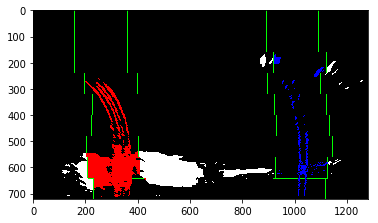

In [270]:

reset_history()

clip3 = VideoFileClip("./project/harder_challenge_video.mp4")
output_clip3 = clip3.fl_image(pipeline_v2)
output3 = './project/harder_challenge_video_output_v2_2.mp4'
%time output_clip3.write_videofile(output3, audio=False)



# Future Work :

* Currently, when the pipeline is executed on a video, after a valid lane detection, I can narrow down the region to search for a valid lane. I can implement this to improve detection quality, and also reduce lane detection time.

* Tweak pipeline so that it produces good results for all the Challenge photos.

* Tweak pipeline so that it produces good results for both Challenge videos.

* Tweak pipeline so that it produces good results for a Self captured video.

* Explore other thresholding techniques ( other than sobel x and s channel thresholding ) for more challenging images, such that they enable the program to run properly on challenging photos and videos.

* If we do not get a lane close to the region of interest, we need 'go back' to our thresholding approach and modify it accordingly to detect the lane lines. Try to find lane line(s) with this new strategy a couple of times.

* For valid radius of curvature(s), we need to predict how quickly the RoC is changing, so that we can modify the size of the smoothing window accordingly. This could be accomplished by taking a derivative of the RoC and understanding it to set a baseline, and then seeing if the current derivative is higher or lower than this. If the derivative is higher, we need to reduce the size of the smoothing window. Else, we can increase the smoothing window ( upto a threshold )

* If we write to disk at each stage of the pipeline, we should be able to produce a compelling visualization showing how the pipeline detected lane lines at different segments of the video.
